In [1]:
%cd ..
%ls

C:\Users\Dongmin Kim\Documents\OnlineTSAD
 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 067D-FB3E

 C:\Users\Dongmin Kim\Documents\OnlineTSAD 디렉터리

2023-05-10  오후 08:09    <DIR>          .
2023-05-10  오후 08:09    <DIR>          ..
2023-04-10  오후 01:01               156 .gitignore
2023-05-15  오전 11:22    <DIR>          .idea
2023-04-14  오후 04:53    <DIR>          .ipynb_checkpoints
2023-05-14  오후 03:07    <DIR>          cfgs
2023-05-04  오후 08:21    <DIR>          checkpoints
2023-05-11  오후 05:27    <DIR>          data
2023-05-11  오후 04:44    <DIR>          EDA
2023-05-14  오후 07:29    <DIR>          Exp
2023-05-15  오후 12:05    <DIR>          figures
2023-05-11  오후 05:30    <DIR>          hptune
2023-05-04  오후 08:21    <DIR>          logs
2023-05-07  오후 01:57    <DIR>          models
2023-05-11  오후 04:21    <DIR>          outputs
2023-05-04  오후 08:21    <DIR>          plots
2023-05-13  오후 04:30    <DIR>          results
2023-05-09  오후 06:11    <DIR>          scripts
2023-05-10  오후 08:09             

In [2]:
import torch
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from utils.metrics import get_summary_stats

from models.MLP import MLP

import wandb
import hydra
from omegaconf import DictConfig

from utils.logger import make_logger
from utils.argpass import prepare_arguments, configure_exp_id
from utils.tools import SEED_everything, plot_interval

import warnings
from data.load_data import DataFactory
from Exp.MLP import MLP

from easydict import EasyDict as edict
import yaml
import re
import copy
import os
import pandas as pd
warnings.filterwarnings("ignore")

# load yaml
cfg = {}
loader = yaml.SafeLoader
loader.add_implicit_resolver(
    u'tag:yaml.org,2002:float',
    re.compile(u'''^(?:
     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
    |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
    |\\.[0-9_]+(?:[eE][-+][0-9]+)?
    |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
    |[-+]?\\.(?:inf|Inf|INF)
    |\\.(?:nan|NaN|NAN))$''', re.X),
    list(u'-+0123456789.'))

# get cfg
model = "MLP"
with open("cfgs/test_defaults.yaml", "r") as file:
    basic_config = yaml.load(file, Loader=loader)
    cfg.update(basic_config)
with open(f"cfgs/model/{model}.yaml", "r") as file:
    model_config = yaml.load(file, Loader=loader)
    cfg.update({"model": model_config})

In [3]:
cfg['dataset'] = 'SWaT'
cfg["RevIN"] = 'SlowRevIN'
cfg["gamma"] = 0.99
args = prepare_arguments(cfg)
print(args)

logger = make_logger(os.path.join(args.log_path, f'{args.exp_id}.log'))
logger.info(f"Configurations: {args}")

# Data
logger.info(f"Preparing {args.dataset} dataset...")
datafactory = DataFactory(args, logger)
train_dataset, train_loader, test_dataset, test_loader = datafactory()
args.num_channels = train_dataset.X.shape[1]
train_X, train_y, test_X, test_y = train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[2023-05-15 12:06:06,530] Configurations: {'exp_id': 'MLP_SWaT_normalization_None', 'infer_options': ['offline_all'], 'thresholding': 'q95.0', 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 12, 'eval_stride': 12, 'scaler': 'std', 'ttlr': 0.001, 'normalization': 'None', 'gamma': 0.99, 'log_freq': 10, 'checkpoint_path': './checkpoints\\MLP_SWaT_normalization_None', 'log_path': './logs\\MLP_SWaT_normalization_None', 'output_path': './outputs\\MLP_SWaT_normalization_None', 'plot_path': './plots\\MLP_SWaT_normalization_None', 'result_path': './results\\MLP_SWaT_normalization_None', 'plot_anomaly_scores': False, 'plot_recon_status': False, 'save_result': True, 'load_anoscs': True, 'save_outputs': False, 'save_roc_curve': False, 'defaults': [{'model': 'MLP'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'RevIN': 'SlowRevIN', 'home_dir': '.', 'device': device(type='cpu')}
[2023-05-15 12:06:06,531] Preparing SWaT dataset...
[2023-05-15 12:06:06,532] cur

{'exp_id': 'MLP_SWaT_normalization_None', 'infer_options': ['offline_all'], 'thresholding': 'q95.0', 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 12, 'eval_stride': 12, 'scaler': 'std', 'ttlr': 0.001, 'normalization': 'None', 'gamma': 0.99, 'log_freq': 10, 'checkpoint_path': './checkpoints\\MLP_SWaT_normalization_None', 'log_path': './logs\\MLP_SWaT_normalization_None', 'output_path': './outputs\\MLP_SWaT_normalization_None', 'plot_path': './plots\\MLP_SWaT_normalization_None', 'result_path': './results\\MLP_SWaT_normalization_None', 'plot_anomaly_scores': False, 'plot_recon_status': False, 'save_result': True, 'load_anoscs': True, 'save_outputs': False, 'save_roc_curve': False, 'defaults': [{'model': 'MLP'}], 'model': {'name': 'MLP', 'latent_dim': 128}, 'RevIN': 'SlowRevIN', 'home_dir': '.', 'device': device(type='cpu')}


[2023-05-15 12:06:14,464] train: X - (496800, 51), y - (496800,) test: X - (449919, 51), y - (449919,)
[2023-05-15 12:06:14,560] Complete.
[2023-05-15 12:06:14,561] Preparing dataloader...
[2023-05-15 12:06:15,144] total train dataset- 647, batch_X - torch.Size([64, 12, 51]), batch_y - torch.Size([64, 12])
[2023-05-15 12:06:15,145] total test dataset- 37494, batch_X - torch.Size([1, 12, 51]), batch_y - torch.Size([1, 12])
[2023-05-15 12:06:15,145] Complete.


(496800, 51) (496800,) (449928, 51) (449928,)


## Visualize

In [4]:
data_df = pd.read_csv("data/SWaT/SWaT_Dataset_Attack_v0.csv", index_col=0)
data_df

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
Timestamp,,,,,,,,,,,,,,,,,,,,,
28/12/2015 10:00:00 AM,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
28/12/2015 10:00:01 AM,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal
28/12/2015 10:00:02 AM,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal
28/12/2015 10:00:03 AM,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal
28/12/2015 10:00:04 AM,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,2,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2/1/2016 2:59:55 PM,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,2,1,251.1535,0.865024,189.0220,0.000000,1,1,1,Normal
2/1/2016 2:59:56 PM,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1,Normal
2/1/2016 2:59:57 PM,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,2,...,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1,Normal


In [5]:
cols = list(data_df.columns)

NameError: name 'np' is not defined

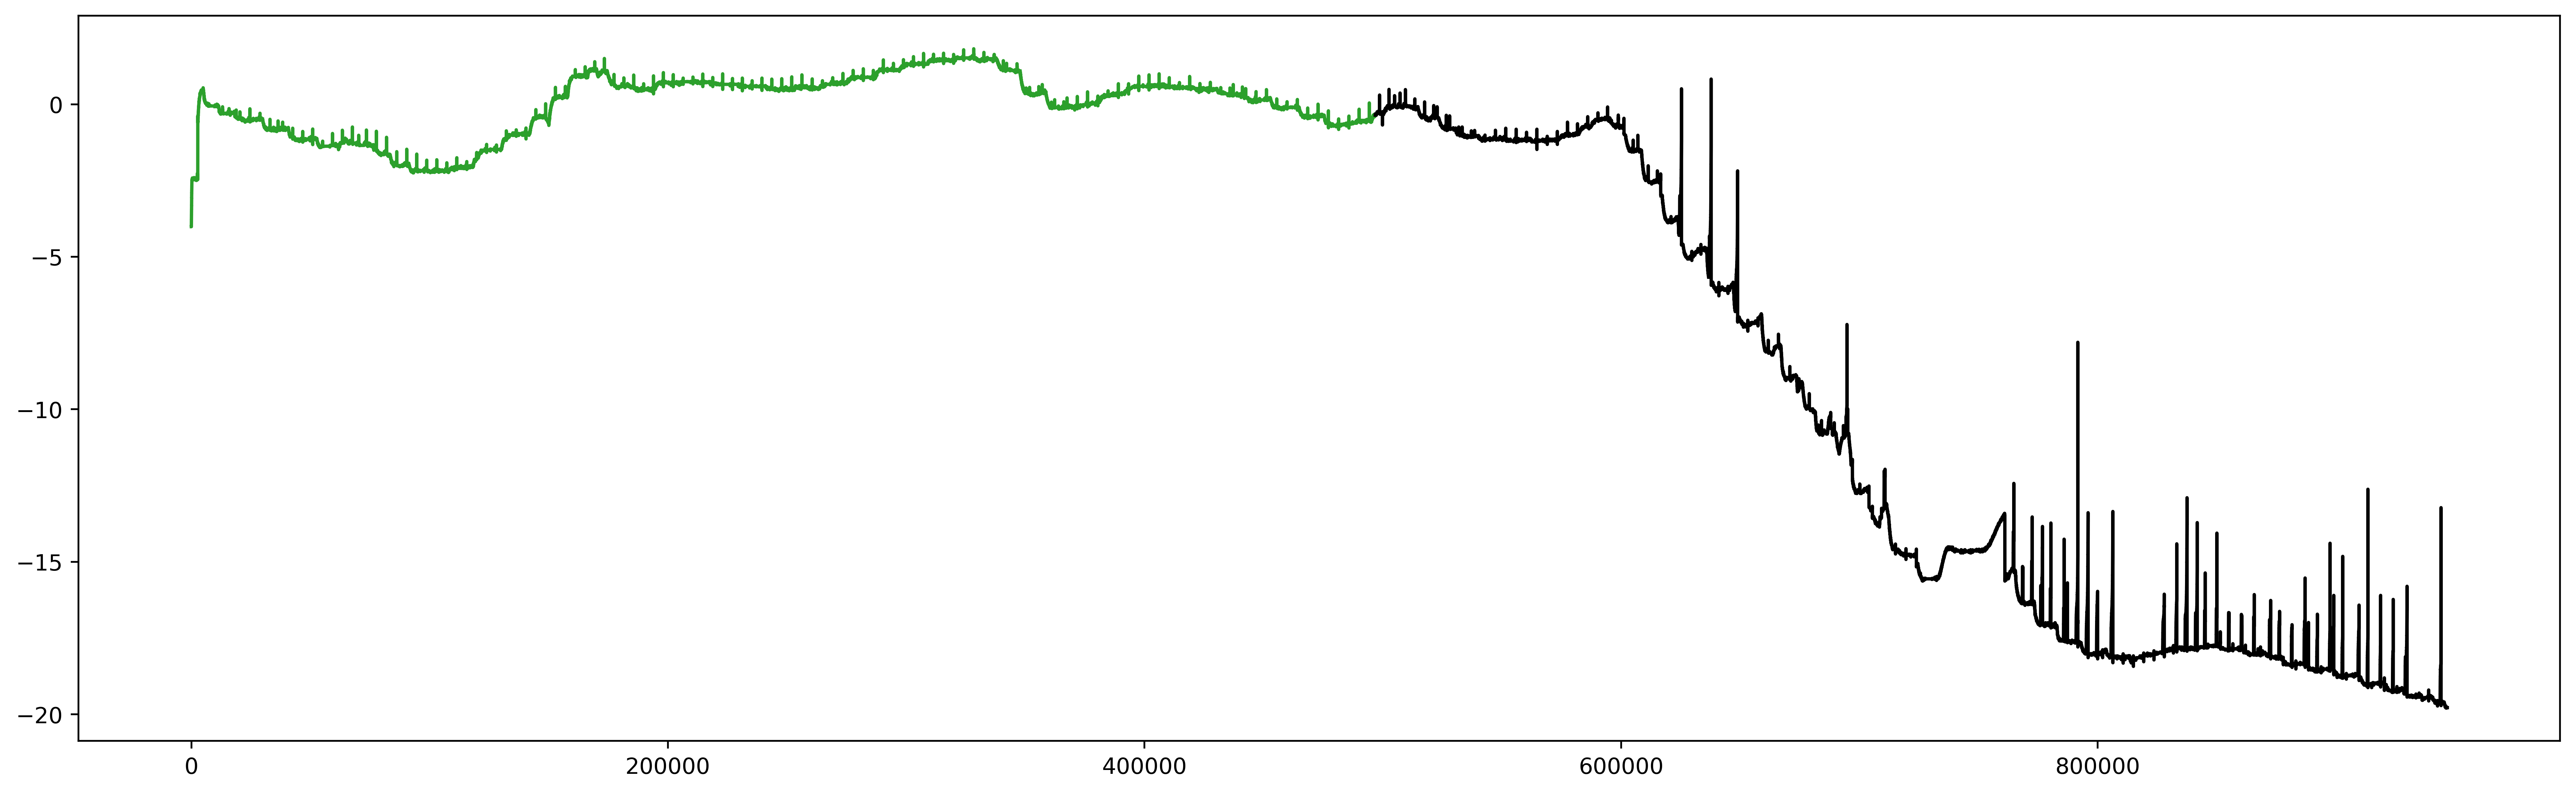

In [6]:
c = 5
dataset_name = "SWaT"

plt.figure(figsize=(20, 6), dpi=500)
plt.plot(train_X[:, c], color="C2", label="Train")
plt.plot(range(len(train_X), len(train_X)+len(test_X)), test_X[:, c], color="black", label="Test")
label = np.concatenate([np.array([0]*len(train_X)), test_y])
plot_interval(plt, label)
#plt.title(f"{dataset_name} ({cols[c]})")
plt.title(f"SWaT (AIT201)")

plt.legend()
plt.ticklabel_format(style="plain")
plt.show()

## PCA plots

In [8]:
from scipy.stats import gaussian_kde, entropy
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [9]:
import scipy

In [10]:
import numpy as np

In [11]:
"https://gist.github.com/ChuaCheowHuan/18977a3e77c0655d945e8af60633e4df"
def kl_mvn(to, fr):
    """Calculate `KL(to||fr)`, where `to` and `fr` are pairs of means and covariance matrices"""
    m_to, S_to = to
    m_fr, S_fr = fr
    
    d = m_fr - m_to
    
    c, lower = scipy.linalg.cho_factor(S_fr)
    def solve(B):
        return scipy.linalg.cho_solve((c, lower), B)
    
    def logdet(S):
        return np.linalg.slogdet(S)[1]

    term1 = np.trace(solve(S_to))
    term2 = logdet(S_fr) - logdet(S_to)
    term3 = d.T @ solve(d)
    return (term1 + term2 + term3 - len(d))/2.

def plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, data, load=True):
    print("="*20)
    print(f"KLD for {data}")
    base_dir = os.path.join("figures", "PCA", "datasearch", data)
    os.makedirs(base_dir, exist_ok=True)
    
    #import pdb;pdb.set_trace();
    if (load==True) and (os.path.exists(os.path.join(base_dir, "Xpca_train.npy"))):
        Xpca_train = np.load(os.path.join(base_dir, "Xpca_train.npy"))
        Xpca_test = np.load(os.path.join(base_dir, "Xpca_test.npy"))
    else:
        print("finding PCA...")
        T, C = train_X.shape

        # filter anomalies
        print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
        mask = (1-test_y).astype(bool)
        test_X = test_X[mask]
        print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

        data = np.concatenate([train_X, test_X])
        print(data.shape)

        if C < 2:
            Xpca_train = train_X
            Xpca_test = test_X
        else:
            x = range(1, min(C, 31))
            d = -1
            evar = []
            for n in x:
                pca = PCA(n_components=n)
                Xpca = pca.fit_transform(data)
                evar.append(sum(pca.explained_variance_ratio_))
                if d == -1 and sum(pca.explained_variance_ratio_) > 0.99 :
                    d = n
            print("Done!")
            plt.plot(x, evar)
            plt.axvline(d)
            plt.show()

            # kde of PCA'ed outputs.
            pca = PCA(n_components=d) 
            pca_data = pca.fit_transform(data)
            Xpca_train = pca_data[:len(train_X)]
            Xpca_test = pca_data[len(train_X):]
        
        print("saving...")
        with open(os.path.join(base_dir, "Xpca_train.npy"), "wb") as f:
            np.save(f, Xpca_train)
        with open(os.path.join(base_dir, "Xpca_test.npy"), "wb") as f:
            np.save(f, Xpca_test)
            
    print("Estimating Gaussian KLD...")
    _, C = Xpca_train.shape
    train_mu = np.mean(Xpca_train, axis=0)
    test_mu = np.mean(Xpca_test, axis=0)
    train_var = np.array([[np.var(Xpca_train)]]) if C < 2 else np.cov(Xpca_train.T)
    test_var = np.array([[np.var(Xpca_test)]]) if C < 2 else np.cov(Xpca_test.T)
    train_stats = (train_mu, train_var)
    test_stats = (test_mu, test_var)
    e = kl_mvn(test_stats, train_stats)    
    print("KLD: ", e)
    print("train_stats: ", train_stats)
    print("test_stats: ", test_stats)
    print("done")
    print("="*20)
    return e, Xpca_train, Xpca_test

In [24]:
data

'A-1'

In [26]:
train_X, train_y, test_X, test_y = DataFactory.load_MSL("P-15")

In [27]:
train_X

array([[0.9984341, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.9979121, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [1.000522 , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [1.0043497, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [1.0046977, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [1.0048717, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

A-1
A-2
A-3
A-4
A-5
A-6
A-7
A-8
A-9
B-1
C-1
KLD for C-1
finding PCA...
(2158, 55) (2158,) (2264, 55) (2264,)
(2158, 55) (2158,) (1954, 55) (2264,)
(4112, 55)
Done!


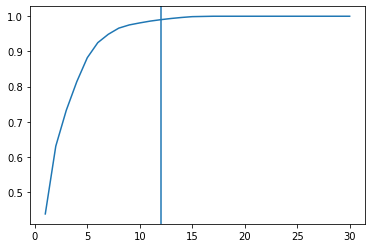

saving...
Estimating Gaussian KLD...
KLD:  190077.96292954046
train_stats:  (array([-2.9246720e-02, -1.5711930e-03,  2.0329180e-04, -1.2552402e-03,
       -1.9572626e-05,  2.2221592e-03,  2.1534879e-03, -7.7871988e-03,
       -5.1586784e-04, -6.0801290e-04, -5.3205219e-04, -3.2138932e-04],
      dtype=float32), array([[ 1.91759920e-01,  1.59544466e-03,  9.27442647e-04,
         2.37341390e-03,  2.01876402e-03,  2.04287797e-04,
         4.65767251e-04,  2.70966142e-03,  3.39204864e-04,
        -2.00452951e-04,  2.41797674e-04,  6.13158674e-05],
       [ 1.59544466e-03,  8.60855478e-02,  1.58198843e-04,
         7.56148200e-04,  5.12528686e-04, -1.99763730e-04,
        -1.15567939e-04,  1.36215157e-03,  1.19551190e-04,
         1.14819387e-05,  9.94433718e-05,  4.22645445e-05],
       [ 9.27442647e-04,  1.58198843e-04,  4.48061339e-02,
         6.38968258e-04,  3.21436560e-04, -1.38108518e-04,
        -8.69724899e-05,  6.58497748e-04,  5.16872178e-05,
         1.29580999e-05,  4.37260082

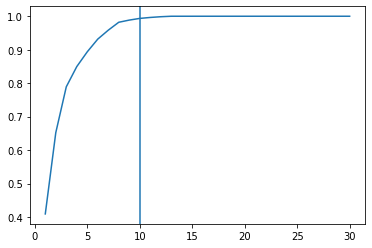

saving...
Estimating Gaussian KLD...
KLD:  12679202419611.594
train_stats:  (array([-0.3758673 , -0.03950028,  0.04673494,  0.00479741,  0.0007495 ,
        0.031145  ,  0.00847825,  0.00081786, -0.00102563, -0.00143435],
      dtype=float32), array([[ 2.55243621e-02, -4.11052020e-02, -4.09906770e-02,
        -4.47335439e-03,  2.33699081e-04,  1.55588756e-03,
         7.26713812e-04, -5.83349826e-04, -1.99329094e-04,
        -2.49169224e-04],
       [-4.11052020e-02,  2.56398996e-01, -2.81381747e-02,
        -2.76356662e-03,  7.00308482e-05, -4.34159706e-03,
        -1.04922089e-03, -4.52149275e-04,  8.99260741e-05,
         8.45291090e-05],
       [-4.09906770e-02, -2.81381747e-02,  1.19065860e-01,
        -1.66821170e-04,  9.27971989e-04, -1.06643034e-02,
        -2.44189589e-03,  2.52553528e-04,  3.41727437e-04,
         4.46642072e-04],
       [-4.47335439e-03, -2.76356662e-03, -1.66821170e-04,
         4.84062328e-02,  1.60127268e-03, -5.63324722e-03,
        -8.12359025e-04,  2.7

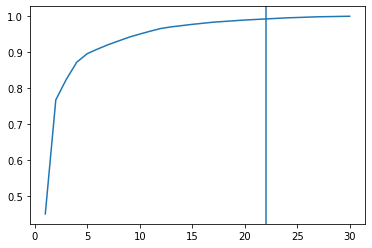

saving...
Estimating Gaussian KLD...
KLD:  43841858585475.04
train_stats:  (array([-1.3252400e-03, -2.0489469e-02, -1.6287541e-02, -1.2911614e-02,
       -7.3162238e-03, -4.2885230e-03, -3.5648518e-03, -5.7739107e-04,
       -5.0973915e-03, -6.2172872e-04, -2.7003526e-03, -3.1143171e-03,
       -1.1573171e-03, -3.8496393e-04, -1.4815048e-03, -7.7008281e-04,
       -8.6449337e-04, -1.0294540e-05,  2.2207346e-04, -1.1560631e-03,
        6.6080407e-05, -1.0997324e-04], dtype=float32), array([[ 1.33704289e-01,  2.01201793e-03,  7.05573734e-04,
         5.45319454e-04,  2.92607180e-04,  1.67453392e-04,
         1.38842513e-04,  2.24484165e-05,  1.97880559e-04,
         2.39518944e-05,  1.04260367e-04,  1.20122824e-04,
         4.43402774e-05,  1.47258505e-05,  5.66422515e-05,
         2.94235539e-05,  3.30093119e-05,  3.92324876e-07,
        -8.46523422e-06,  4.40575941e-05, -2.51586048e-06,
         4.18750721e-06],
       [ 2.01201793e-03,  9.60361174e-02,  3.60889110e-03,
         2.7366

Done!


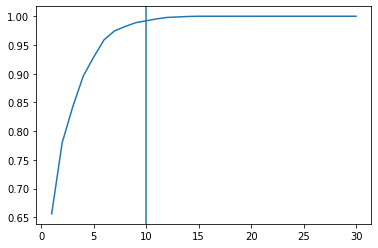

saving...
Estimating Gaussian KLD...
KLD:  0.21377863443186307
train_stats:  (array([-0.0309778 ,  0.00781442,  0.00334696,  0.00014459, -0.00569413,
        0.00090674, -0.00124128,  0.00578694,  0.00188491,  0.00066069],
      dtype=float32), array([[ 4.66499436e-01,  1.72680233e-03, -5.51165167e-04,
         3.30228399e-04,  2.27752718e-03, -4.94402010e-04,
         2.98314472e-03, -9.85359293e-04, -9.96862520e-05,
        -5.57300755e-05],
       [ 1.72680233e-03,  8.24753802e-02, -3.51588479e-04,
        -3.02495974e-05,  3.83505264e-04, -1.93749300e-05,
        -3.67574378e-04, -7.19408934e-04, -1.91416469e-04,
        -4.95035923e-05],
       [-5.51165167e-04, -3.51588479e-04,  4.46283340e-02,
         1.03243103e-03, -3.38618598e-05,  1.05006667e-04,
        -3.06499279e-06, -9.49094434e-06, -4.75516605e-05,
        -2.41071322e-05],
       [ 3.30228399e-04, -3.02495974e-05,  1.03243103e-03,
         3.57658919e-02,  1.38136859e-05,  2.47696939e-05,
         2.23182330e-05, -4.

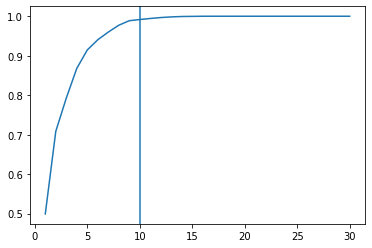

saving...
Estimating Gaussian KLD...
KLD:  0.6958327043577315
train_stats:  (array([-0.00020987,  0.00097534,  0.0098524 ,  0.01410419, -0.01105803,
        0.00356527,  0.00481488, -0.00234527, -0.00330143,  0.00126189],
      dtype=float32), array([[ 7.01419259e-01,  3.93873439e-02,  6.00356419e-03,
        -3.35542469e-03, -2.25458270e-02,  1.87810613e-02,
         1.11653038e-02,  2.55733570e-03, -5.62626733e-04,
         1.23324064e-03],
       [ 3.93873439e-02,  2.21871684e-01, -3.57268612e-03,
        -6.09831438e-03, -9.39693720e-04,  2.72529952e-03,
         9.66027296e-04,  1.12200946e-03,  7.31325302e-04,
        -3.72215362e-05],
       [ 6.00356419e-03, -3.57268612e-03,  9.54122706e-02,
        -2.32208504e-03, -3.52816723e-03,  1.86845378e-03,
         8.60242591e-04,  4.34958010e-04,  1.41987495e-04,
         7.91270076e-05],
       [-3.35542469e-03, -6.09831438e-03, -2.32208504e-03,
         7.79344583e-02, -2.31667638e-03,  3.99882477e-04,
        -3.16443550e-04,  4.5

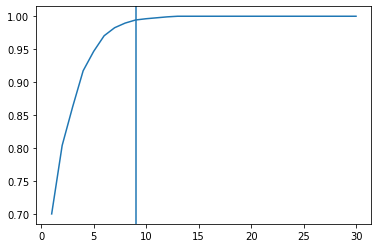

saving...
Estimating Gaussian KLD...
KLD:  0.813584671821018
train_stats:  (array([-0.15199305,  0.00115317,  0.00476636,  0.00442165,  0.00440292,
        0.0002353 , -0.00131465,  0.00105975,  0.00079394], dtype=float32), array([[ 1.50163090e-01,  1.89298389e-03,  8.91911375e-04,
         1.30010903e-04,  3.16717083e-04,  7.47815917e-04,
        -2.68817563e-04, -7.30915962e-04,  5.93669475e-04],
       [ 1.89298389e-03,  3.94513544e-02, -3.94615606e-04,
        -5.18093537e-04, -2.31997014e-04,  4.18269600e-05,
         1.18020935e-05, -6.29722694e-05, -2.65956659e-05],
       [ 8.91911375e-04, -3.94615606e-04,  2.82078512e-02,
         4.66743808e-04, -8.26498426e-05,  5.85039995e-05,
         1.17925018e-05, -2.96742918e-05, -1.10795641e-05],
       [ 1.30010903e-04, -5.18093537e-04,  4.66743808e-04,
         2.49835919e-02, -2.07073545e-04,  1.01585347e-04,
         3.16651992e-05, -7.03363619e-05, -1.46371692e-05],
       [ 3.16717083e-04, -2.31997014e-04, -8.26498426e-05,
     

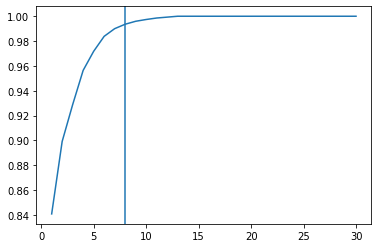

saving...
Estimating Gaussian KLD...
KLD:  0.49415904044094905
train_stats:  (array([-0.10125958,  0.00205865,  0.00401422,  0.00413022,  0.00305889,
       -0.00128828, -0.00052642,  0.00132792], dtype=float32), array([[ 8.10479046e-01, -1.64816261e-03,  1.00539337e-03,
         1.82406877e-03,  5.18374751e-04,  2.44963010e-05,
         1.09030608e-03,  7.96599864e-05],
       [-1.64816261e-03,  4.06760944e-02, -2.76527171e-04,
        -3.50097648e-04, -1.65209991e-04,  6.15915157e-05,
         2.70493768e-06, -6.85068760e-05],
       [ 1.00539337e-03, -2.76527171e-04,  2.44602455e-02,
         2.85867373e-04, -5.55047426e-05,  5.83814168e-05,
         1.13315056e-05, -2.60699784e-05],
       [ 1.82406877e-03, -3.50097648e-04,  2.85867373e-04,
         2.16595206e-02, -1.19434328e-04,  9.79845490e-05,
         2.64853745e-05, -4.90758422e-05],
       [ 5.18374751e-04, -1.65209991e-04, -5.55047426e-05,
        -1.19434328e-04,  1.28869205e-02,  1.78426520e-04,
         1.70944481e-05, 

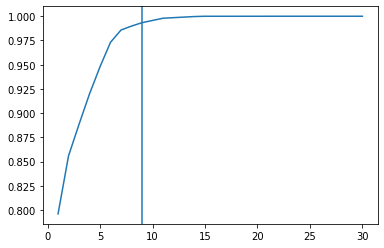

saving...
Estimating Gaussian KLD...
KLD:  0.032823773618531504
train_stats:  (array([-5.9684492e-03, -3.2064199e-04,  1.8688310e-03,  7.0844730e-04,
       -6.5977254e-04,  1.0177187e-03,  2.1204235e-04,  2.9136720e-05,
        3.0973877e-04], dtype=float32), array([[ 3.74814113e-01, -5.75758697e-04, -5.16955559e-04,
         1.46217566e-03,  1.63781676e-04, -8.08764932e-04,
        -1.66142318e-04, -1.16065644e-04, -1.52699990e-04],
       [-5.75758697e-04,  2.88076093e-02, -1.55471777e-04,
         4.99694727e-05,  3.08289414e-05, -8.86202921e-05,
        -1.64439929e-05, -4.41552596e-06, -1.41182831e-05],
       [-5.16955559e-04, -1.55471777e-04,  1.75353881e-02,
         1.63473596e-05,  2.71542527e-04,  5.11463909e-05,
         3.26648840e-06, -1.06704496e-06, -6.69927124e-06],
       [ 1.46217566e-03,  4.99694727e-05,  1.63473596e-05,
         1.53551404e-02, -9.53490442e-06,  4.06684802e-05,
         8.61001117e-06,  6.88214375e-06,  4.42603288e-06],
       [ 1.63781676e-04,  3

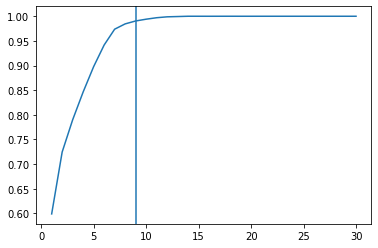

saving...
Estimating Gaussian KLD...
KLD:  1.1921533761924392
train_stats:  (array([ 4.3077581e-02, -5.7289805e-03, -4.1592438e-03, -4.7082035e-03,
       -3.9612395e-03, -1.8158824e-03, -4.6589016e-03, -1.2825718e-03,
       -8.3016814e-05], dtype=float32), array([[ 2.44574404e-01,  2.69511969e-03,  1.27664207e-03,
         2.37250471e-03,  1.36122110e-03,  7.19784054e-04,
         2.59609637e-03,  3.37710312e-04,  5.36896107e-05],
       [ 2.69511969e-03,  3.23005197e-02,  2.66046920e-04,
         2.45208999e-04,  2.03152584e-04,  6.11335764e-05,
         2.44597863e-04,  5.79291195e-05,  4.74708058e-06],
       [ 1.27664207e-03,  2.66046920e-04,  1.53129864e-02,
         5.64407121e-05,  5.47692942e-06, -9.57738064e-05,
         1.41529163e-04,  2.51101848e-05,  3.62434531e-07],
       [ 2.37250471e-03,  2.45208999e-04,  5.64407121e-05,
         1.40919778e-02,  1.01445171e-04,  2.60362798e-05,
        -2.32515026e-04,  2.66354919e-05,  9.36486511e-06],
       [ 1.36122110e-03,  2.0

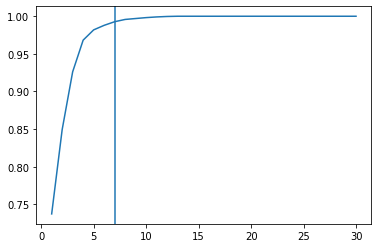

saving...
Estimating Gaussian KLD...
KLD:  0.6255759917740251
train_stats:  (array([-2.9918777e-02, -7.5178890e-04,  2.5422869e-03,  6.2874355e-04,
        7.4249663e-05,  1.6781540e-03,  3.9297936e-04], dtype=float32), array([[ 4.91772952e-01,  6.43059938e-03,  2.44690441e-02,
         1.49023972e-02,  4.13817188e-03, -1.15218094e-03,
         1.61068356e-03],
       [ 6.43059938e-03,  1.08810558e-01, -1.24938612e-03,
        -4.43081469e-04, -1.10996308e-04, -7.55020215e-05,
        -6.39906002e-05],
       [ 2.44690441e-02, -1.24938612e-03,  7.29062453e-02,
        -1.23421831e-03, -3.76997742e-04, -1.09687788e-04,
        -1.94978161e-04],
       [ 1.49023972e-02, -4.43081469e-04, -1.23421831e-03,
         3.97353239e-02, -2.40268420e-04, -9.32506968e-05,
        -1.26886842e-04],
       [ 4.13817188e-03, -1.10996308e-04, -3.76997742e-04,
        -2.40268420e-04,  1.31807568e-02, -5.11163274e-05,
        -3.68507240e-05],
       [-1.15218094e-03, -7.55020215e-05, -1.09687788e-04,
 

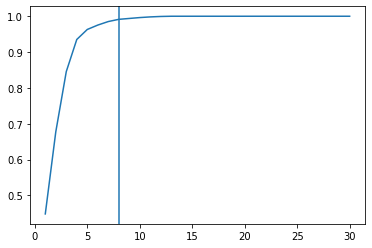

saving...
Estimating Gaussian KLD...
KLD:  1.1633075329601512
train_stats:  (array([-0.09452113, -0.00021653,  0.00058063, -0.00121068, -0.0004615 ,
        0.00134587,  0.0002356 ,  0.00019138], dtype=float32), array([[ 1.15757511e-01,  4.93396473e-03,  1.11976334e-02,
         5.88749095e-03,  1.55339471e-03, -9.83420518e-04,
         6.07379854e-04,  4.03047813e-04],
       [ 4.93396473e-03,  1.09441398e-01, -6.93693929e-04,
        -3.72479961e-05, -2.21459056e-07, -9.63318834e-05,
        -2.65780986e-05, -1.96150991e-05],
       [ 1.11976334e-02, -6.93693929e-04,  8.11006481e-02,
         2.26716313e-04,  4.63066831e-05, -1.77746477e-04,
        -3.58532977e-05, -2.76790016e-05],
       [ 5.88749095e-03, -3.72479961e-05,  2.26716313e-04,
         4.25785195e-02,  3.26240406e-05, -1.18447195e-04,
        -1.83669370e-05, -1.39518979e-05],
       [ 1.55339471e-03, -2.21459056e-07,  4.63066831e-05,
         3.26240406e-05,  1.33379481e-02, -5.66616358e-05,
        -6.70817266e-06, -

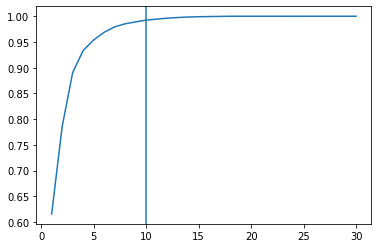

saving...
Estimating Gaussian KLD...
KLD:  1.252577338897872
train_stats:  (array([-0.03862359,  0.01242738, -0.00089923,  0.00724104,  0.00206809,
       -0.00200384,  0.00068365,  0.00170475,  0.00229137,  0.00178926],
      dtype=float32), array([[ 5.35738935e-01, -6.37052869e-03, -2.63780328e-03,
        -4.92669728e-04, -6.98238062e-04,  2.18744823e-03,
        -7.13981918e-04,  1.07861571e-03,  1.19566924e-04,
        -2.31874274e-04],
       [-6.37052869e-03,  1.46771381e-01,  2.85759128e-03,
        -1.28067157e-03, -3.94433704e-04,  3.58012512e-04,
        -1.82996224e-04, -1.13625654e-04, -2.97947141e-04,
        -2.62575289e-04],
       [-2.63780328e-03,  2.85759128e-03,  8.38376466e-02,
        -2.33952260e-03, -5.49454785e-04,  3.78352222e-04,
        -2.22891638e-04, -1.63425955e-04, -3.59803992e-04,
        -3.10228500e-04],
       [-4.92669728e-04, -1.28067157e-03, -2.33952260e-03,
         4.12740780e-02, -1.08928154e-04,  3.67065534e-04,
        -5.40788434e-05, -7.97

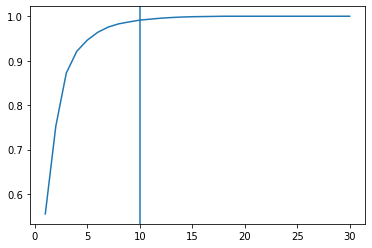

saving...
Estimating Gaussian KLD...
KLD:  1.2070829937689664
train_stats:  (array([-0.02779587,  0.00802806, -0.00490623,  0.00546641,  0.00076899,
       -0.00290696,  0.00042883,  0.00158228,  0.00209918,  0.00162819],
      dtype=float32), array([[ 4.32209780e-01, -3.44317457e-03,  8.88180073e-04,
        -1.13208303e-04, -5.68267447e-05,  2.22141256e-03,
        -4.92911331e-04,  2.69272883e-04,  8.41581654e-05,
        -2.76774669e-04],
       [-3.44317457e-03,  1.44350662e-01,  3.14249239e-03,
        -1.02471078e-03, -1.66640386e-04,  5.13937968e-04,
        -1.45389290e-04, -1.76103943e-04, -2.71730382e-04,
        -2.40331111e-04],
       [ 8.88180073e-04,  3.14249239e-03,  8.24473237e-02,
        -1.96171967e-03, -2.75419363e-04,  5.90629723e-04,
        -1.75077628e-04, -2.23057702e-04, -3.26214498e-04,
        -2.82871608e-04],
       [-1.13208303e-04, -1.02471078e-03, -1.96171967e-03,
         4.01466579e-02,  6.33588050e-05,  4.56855769e-04,
        -3.92830408e-05, -1.0

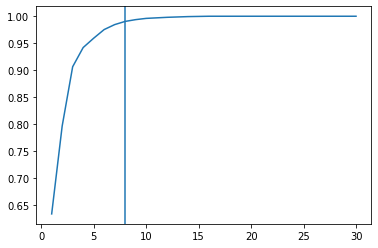

saving...
Estimating Gaussian KLD...
KLD:  0.08749828999596065
train_stats:  (array([ 0.00657946,  0.0107505 ,  0.00677364,  0.00215907,  0.00141555,
       -0.0006739 , -0.00038331,  0.00099628], dtype=float32), array([[ 4.95149427e-01, -2.89103920e-03, -2.23637941e-03,
         2.19993970e-03, -5.50242128e-04,  6.87123984e-04,
        -4.39126863e-04,  2.66222804e-03],
       [-2.89103920e-03,  1.29905172e-01,  1.29145853e-03,
        -1.27261481e-05, -1.69797741e-04,  1.36192954e-04,
         1.74352571e-05,  6.42961158e-05],
       [-2.23637941e-03,  1.29145853e-03,  8.34568725e-02,
        -2.08526661e-04, -2.77927589e-04,  1.80605056e-04,
         3.46868963e-05,  2.97531684e-05],
       [ 2.19993970e-03, -1.27261481e-05, -2.08526661e-04,
         2.78007048e-02, -8.21453601e-05,  1.54439439e-04,
         3.31046461e-05, -8.40071847e-06],
       [-5.50242128e-04, -1.69797741e-04, -2.77927589e-04,
        -8.21453601e-05,  1.33007454e-02,  6.71601296e-04,
         2.64097481e-05, 

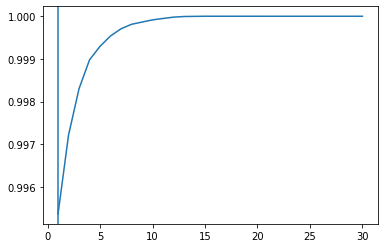

saving...
Estimating Gaussian KLD...
KLD:  1071201727.5
train_stats:  (array([-1.3022984], dtype=float32), array([[8.24927e-08]], dtype=float32))
test_stats:  (array([1.0904697], dtype=float32), array([[171.00731]], dtype=float32))
done
M-7
KLD for M-7
finding PCA...
(1587, 55) (1587,) (2156, 55) (2156,)
(1587, 55) (1587,) (2056, 55) (2156,)
(3643, 55)
Done!


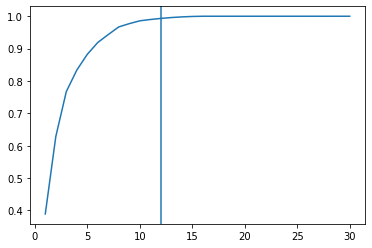

saving...
Estimating Gaussian KLD...
KLD:  55561.562379970266
train_stats:  (array([ 0.00509667,  0.00851183,  0.00335883,  0.00371247, -0.00100917,
        0.00686282,  0.00295294,  0.00656744, -0.00194445,  0.00102174,
        0.0003719 , -0.00127299], dtype=float32), array([[ 1.64925382e-01, -1.71759372e-03, -3.74675655e-04,
        -5.42510440e-04,  1.74500872e-04, -9.84732693e-04,
        -3.03163027e-04, -8.46280938e-04,  2.65199193e-04,
        -1.35719736e-04, -4.89967479e-05,  1.69645288e-04],
       [-1.71759372e-03,  1.01599792e-01,  1.43972538e-04,
        -6.00451863e-04,  2.61454949e-04, -1.13862999e-03,
        -3.71706207e-04, -9.79001682e-04,  3.01593958e-04,
        -1.52149079e-04, -5.47479889e-05,  1.90166346e-04],
       [-3.74675655e-04,  1.43972538e-04,  5.74395535e-02,
        -6.52461246e-04,  2.33875926e-04, -1.00633245e-03,
        -2.48156096e-04, -7.76488030e-04,  2.37813320e-04,
        -1.18774308e-04, -4.20744878e-05,  1.46545549e-04],
       [-5.4251044

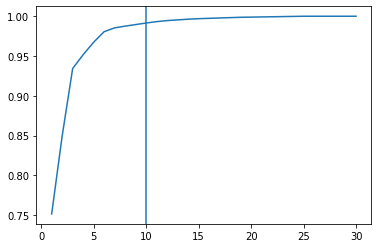

saving...
Estimating Gaussian KLD...
KLD:  1133880.638919639
train_stats:  (array([-2.2721267e-01, -5.5350289e-03,  1.6742187e-03, -6.5422711e-05,
        1.6715071e-03,  7.3690334e-04,  3.2263141e-04, -1.1272958e-04,
       -3.0503140e-04, -3.6319831e-05], dtype=float32), array([[ 1.01019001e-04, -8.16968642e-04, -1.93438964e-03,
         9.82528468e-06,  8.19596599e-05, -1.17349244e-05,
        -3.60293491e-06, -7.33528599e-08, -8.75548332e-07,
         4.18664226e-07],
       [-8.16968642e-04,  4.84694349e-02, -2.71154736e-03,
         1.52448584e-06, -3.50327344e-05, -2.32267024e-05,
        -8.69267724e-06,  2.55159702e-06,  7.16639008e-06,
         8.39650948e-07],
       [-1.93438964e-03, -2.71154736e-03,  4.65091916e-02,
         3.09648893e-05, -8.65008710e-05, -4.59019157e-05,
        -2.22275218e-05,  7.35805690e-06,  2.09062391e-05,
         2.51775375e-06],
       [ 9.82528468e-06,  1.52448584e-06,  3.09648893e-05,
         7.13528421e-03,  1.12228170e-04, -4.21951441e-05,

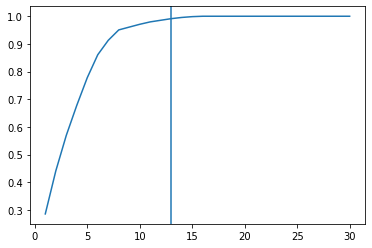

saving...
Estimating Gaussian KLD...
KLD:  4040459.3221268654
train_stats:  (array([ 3.41987447e-03,  7.95457698e-03, -2.92560924e-03, -9.66948573e-04,
       -2.42216722e-03, -1.54608177e-04,  2.37814398e-04,  1.19794789e-03,
       -9.95381997e-05,  1.01282529e-03, -8.56631901e-04, -1.73329769e-04,
        1.14957445e-04], dtype=float32), array([[ 2.92427233e-02, -2.79710522e-04,  1.02026768e-04,
         2.62032097e-05,  8.88462410e-05, -8.73110622e-06,
         3.34706017e-07, -2.38858820e-05,  4.12731740e-06,
        -5.89533908e-05,  2.03968275e-05,  5.46502840e-06,
        -2.60437105e-06],
       [-2.79710522e-04,  1.40850612e-02,  6.54676463e-04,
        -1.18432451e-04,  5.29535357e-04,  8.35420994e-05,
         6.98312751e-05,  1.78106770e-04,  1.51534068e-05,
        -2.75756721e-04, -2.92269140e-05,  3.08247378e-06,
         6.07244900e-06],
       [ 1.02026768e-04,  6.54676463e-04,  1.26191915e-02,
         1.71461154e-04, -1.87070040e-04, -4.59404316e-05,
        -3.4998

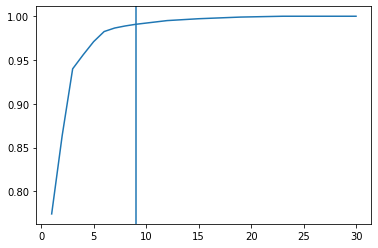

saving...
Estimating Gaussian KLD...
KLD:  6942429309.684866
train_stats:  (array([-2.6227757e-01, -6.7813965e-03,  2.9069632e-03, -6.0322724e-04,
        1.9737226e-03,  5.8720080e-04,  8.4855343e-04, -1.1394163e-04,
       -1.3353945e-04], dtype=float32), array([[ 9.73578923e-05, -9.04341391e-04, -1.87336814e-03,
         3.32906966e-07,  8.74257215e-05, -1.22298055e-05,
        -2.04525819e-06, -1.73639912e-08, -1.61764372e-07],
       [-9.04341391e-04,  4.81257621e-02, -3.16655485e-03,
         1.80322253e-05, -4.44668075e-05, -2.18920720e-05,
        -2.42670537e-05,  3.33210023e-06,  3.77247860e-06],
       [-1.87336814e-03, -3.16655485e-03,  4.74430844e-02,
         7.39325974e-05, -9.55013806e-05, -3.41033015e-05,
        -5.87770668e-05,  8.36420674e-06,  9.50930925e-06],
       [ 3.32906966e-07,  1.80322253e-05,  7.39325974e-05,
         6.53322667e-03,  1.45107972e-04, -3.77797228e-05,
        -1.11828056e-05,  8.54995308e-06,  6.86700114e-06],
       [ 8.74257215e-05, -4.44

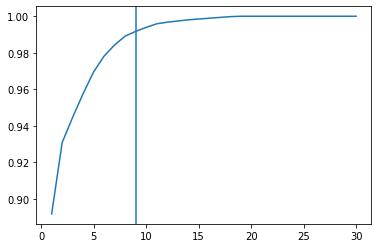

saving...
Estimating Gaussian KLD...
KLD:  743.2574419266186
train_stats:  (array([-4.3744165e-01,  7.4432470e-04,  2.5386838e-04, -4.2299533e-04,
        1.2056691e-03, -1.1084885e-03, -7.5301173e-04, -1.7610122e-04,
        8.4817450e-04], dtype=float32), array([[ 1.30069061e-03, -4.31169845e-04, -8.92566120e-05,
        -3.51030651e-04, -3.03782912e-04, -2.18356379e-05,
         1.09420576e-05, -1.17634942e-04,  1.05901445e-06],
       [-4.31169845e-04,  2.82373050e-02, -6.94124079e-06,
         1.52903408e-05, -2.93813210e-05,  3.60588694e-05,
         1.74678011e-05,  4.71710521e-06, -4.32520345e-05],
       [-8.92566120e-05, -6.94124079e-06,  9.95836763e-03,
         6.89311014e-05, -3.21288924e-05,  2.36599160e-05,
         8.27685670e-06,  2.17636677e-06, -1.45174277e-05],
       [-3.51030651e-04,  1.52903408e-05,  6.89311014e-05,
         8.90331005e-03, -1.23182262e-04,  2.33276071e-05,
         7.72818275e-06,  1.33862656e-06, -1.68328790e-05],
       [-3.03782912e-04, -2.93

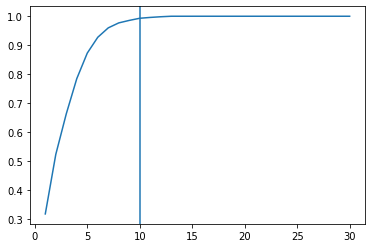

saving...
Estimating Gaussian KLD...
KLD:  4.495233892116223
train_stats:  (array([-0.00943197, -0.00951546,  0.02144333, -0.04064734, -0.02903659,
       -0.00038566, -0.01554896, -0.0047305 , -0.00450961, -0.00251825],
      dtype=float32), array([[ 1.98385066e-01,  1.01769641e-03, -4.88288891e-03,
         8.03364957e-03,  5.12695429e-03,  4.14080574e-04,
         1.88404620e-03,  5.50824936e-04,  5.29756293e-04,
         2.92540632e-04],
       [ 1.01769641e-03,  1.37684195e-01, -9.46975174e-03,
         1.31231950e-02,  7.14383406e-03,  7.01003378e-04,
         2.04561887e-03,  5.82584513e-04,  5.61668272e-04,
         3.08296451e-04],
       [-4.88288891e-03, -9.46975174e-03,  1.14568910e-01,
         8.18211025e-03, -4.29229687e-05, -2.49141302e-03,
         1.96969180e-03,  4.86792057e-04,  3.31197346e-04,
         1.95056269e-04],
       [ 8.03364957e-03,  1.31231950e-02,  8.18211025e-03,
         7.01554395e-02,  6.39862513e-03,  6.09344708e-03,
        -3.26891427e-03, -7.63

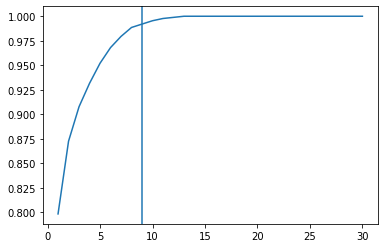

saving...
Estimating Gaussian KLD...
KLD:  0.7247977342330225
train_stats:  (array([-0.05982347, -0.00512486, -0.00204357,  0.00378366, -0.00140585,
        0.0030053 , -0.00129201, -0.00064261, -0.00127776], dtype=float32), array([[ 2.27948288e-01,  2.44421986e-04,  7.39769400e-04,
         7.50824871e-04,  1.36507420e-04,  5.44417341e-04,
         3.49106615e-04,  3.45583557e-04, -1.32619064e-05],
       [ 2.44421986e-04,  1.37949874e-02,  2.33110614e-05,
        -9.50054973e-05,  2.29655015e-05, -6.15369898e-05,
         1.71794517e-05,  7.98032600e-06,  1.81800537e-05],
       [ 7.39769400e-04,  2.33110614e-05,  6.94468552e-03,
        -1.26700244e-04,  1.19431181e-05, -5.23208666e-05,
         1.13421849e-05,  4.34757314e-06,  1.04170992e-05],
       [ 7.50824871e-04, -9.50054973e-05, -1.26700244e-04,
         9.49725181e-03,  2.18747405e-04, -3.63703564e-05,
         2.34549811e-05,  1.12051260e-05,  1.34497582e-05],
       [ 1.36507420e-04,  2.29655015e-05,  1.19431181e-05,
    

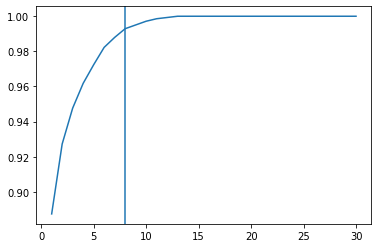

saving...
Estimating Gaussian KLD...
KLD:  0.46405467336621875
train_stats:  (array([-0.0099353 , -0.00321072, -0.00189689,  0.00352647,  0.00258518,
       -0.00048112, -0.00064806, -0.00037152], dtype=float32), array([[ 2.79674550e-01,  1.18021318e-03,  2.81704758e-04,
         3.19555011e-04,  1.45561727e-04,  6.08234920e-04,
         3.92193612e-04, -3.70767007e-04],
       [ 1.18021318e-03,  1.38001129e-02,  3.34769555e-05,
        -9.23524522e-05, -5.75860341e-05,  4.16397986e-06,
         1.11917453e-05,  4.40589254e-06],
       [ 2.81704758e-04,  3.34769555e-05,  6.94735887e-03,
        -1.14173546e-04, -5.00784590e-05,  8.42348131e-08,
         5.96683101e-06,  1.55360487e-06],
       [ 3.19555011e-04, -9.23524522e-05, -1.14173546e-04,
         9.51352743e-03, -2.37322508e-05,  5.53173552e-05,
         1.28000828e-05,  9.40960606e-06],
       [ 1.45561727e-04, -5.75860341e-05, -5.00784590e-05,
        -2.37322508e-05,  6.92388178e-03,  2.22902381e-04,
         1.37443957e-05, 

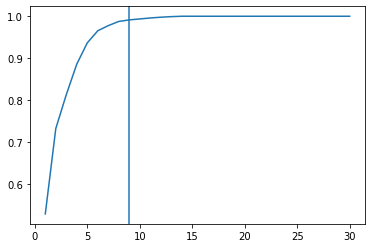

saving...
Estimating Gaussian KLD...
KLD:  1.0656423634628975
train_stats:  (array([ 0.02742856,  0.00472033,  0.00480615,  0.00072467, -0.00446381,
       -0.00494607,  0.00211822, -0.00161087,  0.00130136], dtype=float32), array([[ 2.64554055e-01,  5.44444063e-03,  9.33883279e-04,
         9.69355230e-05, -2.23812842e-03,  1.78716329e-03,
        -8.67678128e-04,  1.04121194e-03, -2.55161289e-04],
       [ 5.44444063e-03,  1.05843239e-01, -9.02656719e-04,
        -3.33478878e-05,  1.27424121e-03,  3.06160350e-04,
        -2.27201330e-05, -1.91135804e-05, -1.01350970e-04],
       [ 9.33883279e-04, -9.02656719e-04,  4.19856984e-02,
         1.32331703e-03,  1.28486601e-04,  3.39743808e-04,
        -8.52339160e-05,  1.15330796e-04, -4.31586975e-05],
       [ 9.69355230e-05, -3.33478878e-05,  1.32331703e-03,
         3.47254034e-02,  1.02720864e-03,  3.64363556e-04,
        -6.79790631e-05,  5.57039404e-05, -6.23342611e-05],
       [-2.23812842e-03,  1.27424121e-03,  1.28486601e-04,
    

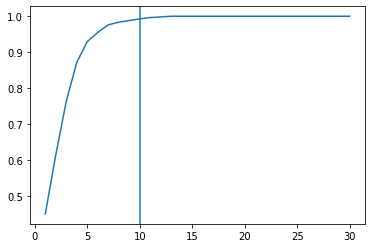

saving...
Estimating Gaussian KLD...
KLD:  5.790249212409352
train_stats:  (array([ 0.01170751,  0.00392111,  0.00266702, -0.00212745, -0.00488543,
        0.00174302, -0.00198675,  0.00129821, -0.00093256,  0.00062251],
      dtype=float32), array([[ 1.18452454e-01, -6.90376142e-04, -1.56965662e-04,
         5.11621279e-04,  7.47990138e-04, -2.30534468e-04,
         2.71221692e-04, -1.69057108e-04,  1.21099839e-04,
        -8.05754769e-05],
       [-6.90376142e-04,  4.17274522e-02,  1.94638803e-03,
         4.06154999e-04,  1.49487579e-04, -2.43732520e-05,
         3.81839139e-05, -2.02157932e-05,  1.46522214e-05,
        -9.53674341e-06],
       [-1.56965662e-04,  1.94638803e-03,  3.62172556e-02,
         7.63814201e-04,  5.15864387e-04, -1.23572889e-04,
         1.44439266e-04, -8.33650027e-05,  5.90330713e-05,
        -3.92189394e-05],
       [ 5.11621279e-04,  4.06154999e-04,  7.63814201e-04,
         2.33672779e-02,  3.89616695e-04, -1.00113802e-04,
         9.81165514e-05, -5.75

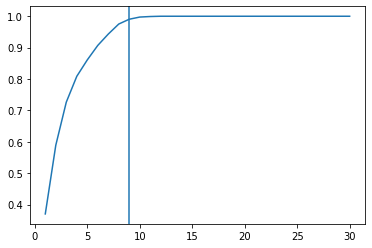

saving...
Estimating Gaussian KLD...
KLD:  796882.030922801
train_stats:  (array([ 0.03099026,  0.0142136 ,  0.04709954, -0.0005601 , -0.016684  ,
       -0.00053313, -0.00124063, -0.01166307, -0.00785071], dtype=float32), array([[ 2.25993814e-01, -8.46711852e-04, -9.77107810e-03,
        -6.33351555e-04,  3.62031931e-03,  3.35959658e-04,
         3.27075748e-04,  2.55643067e-03,  1.53968247e-03],
       [-8.46711852e-04,  1.34502178e-01, -1.09032878e-02,
         3.55897284e-03,  3.17038677e-03,  1.89807393e-04,
         1.31366734e-04,  1.95536758e-03,  1.13781714e-03],
       [-9.77107810e-03, -1.09032878e-02,  7.72757668e-02,
         1.38156482e-03,  6.77260101e-03,  1.47511126e-03,
         5.19091184e-04,  4.52177018e-03,  2.19228551e-03],
       [-6.33351555e-04,  3.55897284e-03,  1.38156482e-03,
         3.49772584e-02,  1.28800337e-03,  2.22890690e-03,
        -5.64595844e-04,  1.00263423e-03,  4.97856732e-04],
       [ 3.62031931e-03,  3.17038677e-03,  6.77260101e-03,
      

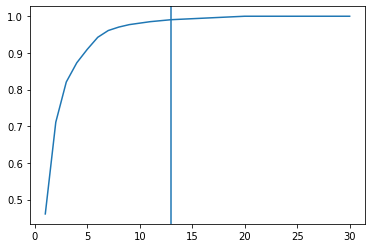

saving...
Estimating Gaussian KLD...
KLD:  163276373475316.72
train_stats:  (array([ 2.4342110e-02,  1.3858783e-01,  2.5313920e-01, -1.3610911e-02,
        1.0918350e-03, -6.9821863e-03, -4.2779162e-03, -2.5373681e-03,
        2.3737707e-04,  1.2042157e-04,  5.4246546e-05, -5.1886908e-04,
        3.6606975e-04], dtype=float32), array([[ 2.91173057e-01,  1.31757436e-02, -3.13003378e-03,
         2.86844395e-04,  5.63776244e-04,  1.53821986e-04,
        -2.06036952e-04, -1.14606170e-04,  5.04075660e-05,
        -3.97276242e-07,  2.56939952e-05, -1.29775363e-06,
        -5.05525710e-05],
       [ 1.31757436e-02,  1.19897311e-01, -1.95397160e-02,
         2.15746737e-03, -5.72113606e-03,  1.22849141e-03,
         3.20129249e-03,  1.65607701e-03, -6.48836838e-04,
        -4.21789357e-06, -3.48490484e-04,  5.31640678e-05,
         5.90993501e-04],
       [-3.13003378e-03, -1.95397160e-02,  4.59384297e-02,
         1.37393148e-03, -4.22230638e-05,  5.85699927e-04,
        -9.44482236e-06, -5.

In [33]:
MSL_list = [file[:-4] for file in os.listdir(os.path.join("data", "MSL", "train"))]
dlist = []
kld = []
for data in MSL_list:
    print(data)
    try:
        train_X, train_y, test_X, test_y = DataFactory.load_MSL(data)
        e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, data, False)
        dlist.append(data)
        kld.append(e)
    except Exception as e:
        pass

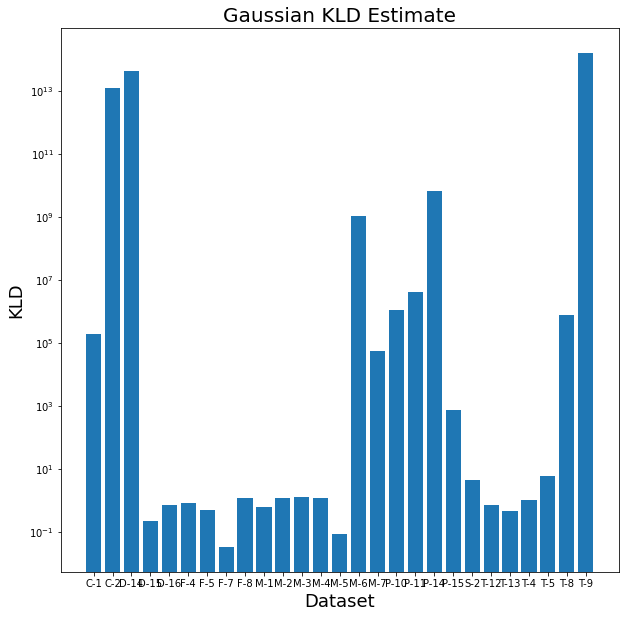

In [34]:
# Basic Bar Chart
plt.figure(figsize=(10, 10))
plt.bar(dlist, kld)
plt.title('Gaussian KLD Estimate', fontsize=20)
plt.xlabel('Dataset', fontsize=18)
plt.yscale('log', base=10)
plt.ylabel('KLD', fontsize=18)
plt.show()   

In [40]:
dlist

['A-1',
 'A-2',
 'A-3',
 'A-4',
 'A-5',
 'A-6',
 'A-7',
 'A-8',
 'A-9',
 'B-1',
 'D-1',
 'D-11',
 'D-12',
 'D-13',
 'D-2',
 'D-3',
 'D-4',
 'D-5',
 'D-6',
 'D-7',
 'D-8',
 'D-9',
 'E-1',
 'E-10',
 'E-11',
 'E-12',
 'E-13',
 'E-2',
 'E-3',
 'E-4',
 'E-5',
 'E-6',
 'E-7',
 'E-8',
 'E-9',
 'F-1',
 'F-2',
 'F-3',
 'G-1',
 'G-2',
 'G-3',
 'G-4',
 'G-6',
 'G-7',
 'P-1',
 'P-2',
 'P-3',
 'P-4',
 'P-7',
 'R-1',
 'S-1',
 'T-1',
 'T-2',
 'T-3']

A-1
KLD for A-1
finding PCA...
(2880, 25) (2880,) (8640, 25) (8640,)
(2880, 25) (2880,) (8556, 25) (8640,)
(11436, 25)
Done!


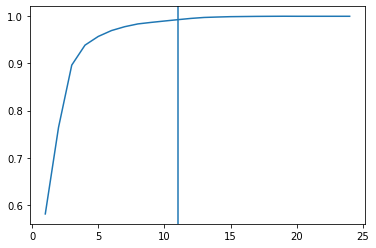

saving...
Estimating Gaussian KLD...
KLD:  0.269132428661373
train_stats:  (array([ 7.3457806e-04, -1.2139183e-03, -1.9348782e-03, -9.7975170e-04,
        1.0169351e-03,  5.3438096e-04,  6.0465513e-04, -7.2500604e-04,
        6.6141918e-04, -2.4191329e-05, -7.9032627e-04], dtype=float32), array([[ 2.83939307e-01, -1.97378037e-03, -1.75126912e-03,
        -3.05021282e-04, -8.96621150e-05,  2.83208139e-04,
         4.89754937e-04, -4.75514017e-04,  6.08330831e-04,
        -2.53871313e-04, -3.40087824e-04],
       [-1.97378037e-03,  8.96318893e-02, -6.56434128e-06,
        -8.78531052e-04,  5.09336613e-04,  6.82412281e-04,
         4.75627446e-04,  5.45973310e-04,  1.85949310e-05,
         6.95805839e-05,  1.88256604e-05],
       [-1.75126912e-03, -6.56434128e-06,  6.62038760e-02,
        -1.04277238e-03, -1.66927259e-04, -3.31619554e-04,
         1.48875869e-04,  5.28049250e-06,  3.36584570e-04,
         1.01444295e-04, -2.11517815e-04],
       [-3.05021282e-04, -8.78531052e-04, -1.04277

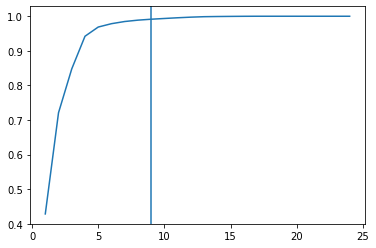

saving...
Estimating Gaussian KLD...
KLD:  0.2641892620918478
train_stats:  (array([ 4.1214678e-02, -4.8217248e-02,  3.0435058e-03, -1.9291379e-03,
       -1.9212846e-04,  8.4895780e-04, -1.0899797e-03, -1.2308441e-03,
        3.2308741e-05], dtype=float32), array([[ 3.59090857e-01, -2.43169737e-02,  2.10990294e-03,
         1.40882614e-03,  1.76285645e-03,  7.36865073e-04,
        -1.20982703e-03, -5.01794157e-04, -7.27660752e-06],
       [-2.43169737e-02,  2.50591839e-01,  9.26887384e-05,
        -2.13554936e-03, -2.41213478e-03, -2.18365786e-04,
        -3.27461178e-04,  3.02541665e-04,  2.84311240e-04],
       [ 2.10990294e-03,  9.26887384e-05,  9.78260650e-02,
         5.91119188e-04, -5.59729459e-04, -4.76955976e-04,
         2.54511305e-04,  3.36986295e-04, -4.05191998e-05],
       [ 1.40882614e-03, -2.13554936e-03,  5.91119188e-04,
         7.22147635e-02, -4.84200718e-04,  3.13126017e-04,
        -3.82964678e-05, -2.41704993e-04,  6.34233506e-05],
       [ 1.76285645e-03, -2.4

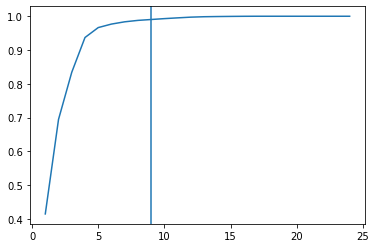

saving...
Estimating Gaussian KLD...
KLD:  0.04705367489627932
train_stats:  (array([-0.00320278,  0.03693106, -0.00143643, -0.00191318,  0.0007602 ,
        0.00058268,  0.00019218, -0.00070664,  0.0001631 ], dtype=float32), array([[ 2.90605120e-01, -9.27647549e-03,  3.63487925e-04,
        -1.27122509e-03,  7.66626943e-04,  1.23529441e-04,
         3.20982069e-04, -2.54838800e-04, -1.47690779e-04],
       [-9.27647549e-03,  2.14466941e-01,  1.27479675e-04,
        -9.12763706e-04, -1.79624120e-03, -3.87803802e-05,
        -6.07758934e-04, -5.21819463e-04, -1.69861817e-04],
       [ 3.63487925e-04,  1.27479675e-04,  9.43142304e-02,
         3.92516268e-04,  4.27845843e-04, -1.41611273e-04,
        -5.32128071e-04,  1.66907150e-04, -3.87389985e-05],
       [-1.27122509e-03, -9.12763706e-04,  3.92516268e-04,
         7.03002710e-02,  1.38480591e-04,  2.35090767e-04,
         1.83130836e-05,  9.85232352e-05, -1.11221721e-04],
       [ 7.66626943e-04, -1.79624120e-03,  4.27845843e-04,
   

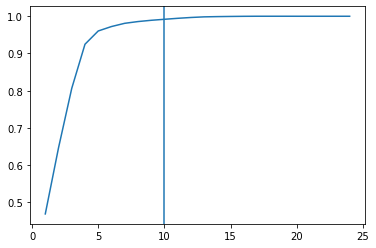

saving...
Estimating Gaussian KLD...
KLD:  0.050494256627687584
train_stats:  (array([ 8.5149379e-03, -1.7058942e-02,  1.5525173e-03, -2.7338588e-03,
        4.2224883e-06,  2.6190857e-04,  3.0165576e-04, -2.6851462e-04,
        1.1343273e-04, -3.5906913e-05], dtype=float32), array([[ 2.82189562e-01, -2.06337488e-03, -3.48834510e-03,
        -3.52645373e-03,  1.06405435e-03, -1.72895167e-04,
         4.33307943e-04,  6.85558741e-05, -2.69564194e-04,
        -6.16510724e-05],
       [-2.06337488e-03,  1.23066036e-01, -4.15905250e-03,
        -8.50470354e-04, -1.01628438e-03,  6.55234113e-05,
        -3.44450553e-04,  4.13535174e-05,  9.65635990e-05,
        -1.20987054e-04],
       [-3.48834510e-03, -4.15905250e-03,  9.93005113e-02,
         3.86629073e-03,  1.78662272e-04,  8.47308281e-05,
         1.46055272e-04, -8.83128682e-06,  1.29182799e-04,
         5.11015697e-05],
       [-3.52645373e-03, -8.50470354e-04,  3.86629073e-03,
         7.27229503e-02, -2.16772519e-04, -5.89819829e-

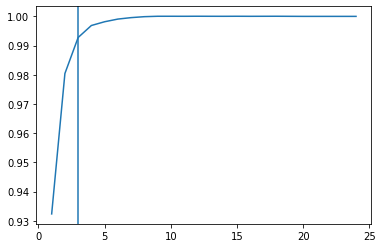

saving...
Estimating Gaussian KLD...
KLD:  58420324.74532637
train_stats:  (array([-0.5308247 ,  0.12326696,  0.00750073], dtype=float32), array([[ 9.06330076e-05, -4.03555940e-03, -4.05065530e-05],
       [-4.03555940e-03,  1.79877559e-01, -1.17062430e-03],
       [-4.05065530e-05, -1.17062430e-03,  5.10602765e-02]]))
test_stats:  (array([ 0.08059104, -0.01871805, -0.00113895], dtype=float32), array([[5.36729115e-01, 1.20584367e-02, 7.02660452e-04],
       [1.20584367e-02, 2.70911138e-04, 1.57863368e-05],
       [7.02660452e-04, 1.57863368e-05, 9.19889935e-07]]))
done
A-6
KLD for A-6
finding PCA...
(682, 25) (682,) (4453, 25) (4453,)
(682, 25) (682,) (4413, 25) (4453,)
(5095, 25)
Done!


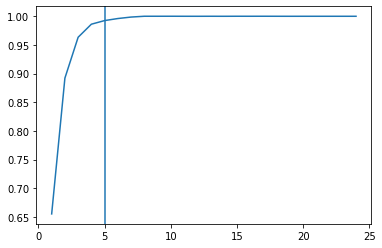

saving...
Estimating Gaussian KLD...
KLD:  83.52387536606021
train_stats:  (array([-5.2518189e-01, -6.1480822e-03,  3.0058811e-03,  3.7439106e-04,
        3.6668737e-04], dtype=float32), array([[ 6.21602372e-02, -3.59793073e-02,  5.03894839e-04,
         8.05107553e-04,  9.87424394e-06],
       [-3.59793073e-02,  1.70848844e-01, -3.45839694e-04,
         1.63200873e-04, -5.65150741e-05],
       [ 5.03894839e-04, -3.45839694e-04,  5.40731570e-02,
         5.31454616e-06, -3.71589553e-06],
       [ 8.05107553e-04,  1.63200873e-04,  5.31454616e-06,
         1.72569956e-02,  8.50403479e-07],
       [ 9.87424394e-06, -5.65150741e-05, -3.71589553e-06,
         8.50403479e-07,  4.79559202e-03]]))
test_stats:  (array([ 8.1159703e-02,  9.4931590e-04, -4.6457429e-04, -5.7819478e-05,
       -5.6693007e-05], dtype=float32), array([[ 1.79116731e-02,  4.97734143e-03,  2.03957627e-04,
        -8.91833965e-05,  3.28471600e-05],
       [ 4.97734143e-03,  1.38311634e-03,  5.66762661e-05,
        -2.4782

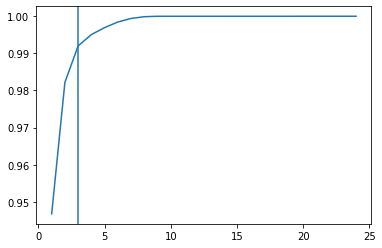

saving...
Estimating Gaussian KLD...
KLD:  4.04977341002652
train_stats:  (array([-0.06194104,  0.00491261, -0.00136169], dtype=float32), array([[ 0.15094163, -0.00078098,  0.00022996],
       [-0.00078098,  0.01666701, -0.00223497],
       [ 0.00022996, -0.00223497,  0.00349542]]))
test_stats:  (array([ 0.02861525, -0.00226987,  0.00062926], dtype=float32), array([[ 1.67113425e-01,  5.66363175e-04, -1.63217269e-04],
       [ 5.66363175e-04,  1.24996561e-03,  1.03698294e-03],
       [-1.63217269e-04,  1.03698294e-03,  8.65593080e-04]]))
done
A-8
KLD for A-8
finding PCA...
(762, 25) (762,) (8375, 25) (8375,)
(762, 25) (762,) (4570, 25) (8375,)
(5332, 25)
Done!


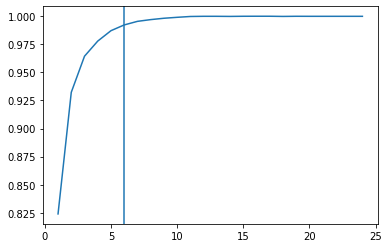

saving...
Estimating Gaussian KLD...
KLD:  790.8923073747063
train_stats:  (array([ 0.12443659,  0.00015243, -0.02092148,  0.00802967, -0.0132799 ,
        0.00770872], dtype=float32), array([[ 9.43194976e-01, -2.28791348e-02, -1.32304491e-02,
         5.31282131e-03, -1.02169241e-02,  6.98337909e-03],
       [-2.28791348e-02,  1.69952652e-02, -1.42763713e-02,
         4.97327517e-03, -6.79745224e-03,  4.94609870e-03],
       [-1.32304491e-02, -1.42763713e-02,  2.00089499e-02,
        -4.46825104e-03,  9.87600913e-03, -5.45995029e-03],
       [ 5.31282131e-03,  4.97327517e-03, -4.46825104e-03,
         2.38135868e-03, -3.55987941e-03,  1.00903562e-03],
       [-1.02169241e-02, -6.79745224e-03,  9.87600913e-03,
        -3.55987941e-03,  7.85750871e-03, -8.11111301e-04],
       [ 6.98337909e-03,  4.94609870e-03, -5.45995029e-03,
         1.00903562e-03, -8.11111301e-04,  3.59212293e-03]]))
test_stats:  (array([-2.0754531e-02, -2.5235191e-05,  3.4886012e-03, -1.3388059e-03,
        2.2141

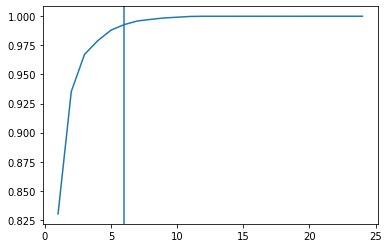

saving...
Estimating Gaussian KLD...
KLD:  1120.5047870224837
train_stats:  (array([ 0.3588632 ,  0.00428212, -0.02844734,  0.00873055, -0.01975011,
        0.00872272], dtype=float32), array([[ 9.31750981e-01, -4.94099084e-02,  2.55310908e-02,
        -5.66796681e-03,  1.31360038e-02, -3.02611768e-03],
       [-4.94099084e-02,  1.99671507e-02, -1.62840644e-02,
         4.39713709e-03, -8.68575340e-03,  4.94292690e-03],
       [ 2.55310908e-02, -1.62840644e-02,  2.02156690e-02,
        -3.17471206e-03,  1.06697718e-02, -4.43837936e-03],
       [-5.66796681e-03,  4.39713709e-03, -3.17471206e-03,
         1.73082417e-03, -2.98688769e-03,  4.28268401e-04],
       [ 1.31360038e-02, -8.68575340e-03,  1.06697718e-02,
        -2.98688769e-03,  8.30444177e-03, -4.02326483e-04],
       [-3.02611768e-03,  4.94292690e-03, -4.43837936e-03,
         4.28268401e-04, -4.02326483e-04,  3.60191924e-03]]))
test_stats:  (array([-0.05983762, -0.00071403,  0.00474344, -0.00145575,  0.00329323,
       -0.00

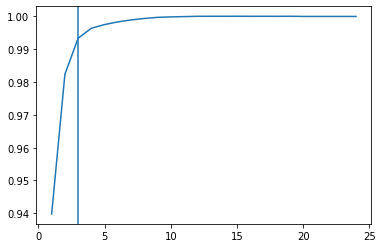

saving...
Estimating Gaussian KLD...
KLD:  5111385329.129162
train_stats:  (array([-0.56031203,  0.01355946,  0.00183258], dtype=float32), array([[ 2.90706427e-05, -1.40139916e-03, -4.40211011e-05],
       [-1.40139916e-03,  6.76485977e-02,  8.35098596e-04],
       [-4.40211011e-05,  8.35098596e-04,  1.81765729e-02]]))
test_stats:  (array([ 0.17112081, -0.00414063, -0.00055954], dtype=float32), array([[ 9.27935540e-01,  3.45645824e-03,  4.22779513e-04],
       [ 3.45645824e-03,  2.69891686e-02, -2.64838338e-04],
       [ 4.22779513e-04, -2.64838338e-04,  6.73814577e-03]]))
done
C-1
C-2
D-1
KLD for D-1
finding PCA...
(2849, 25) (2849,) (8509, 25) (8509,)
(2849, 25) (2849,) (5251, 25) (8509,)
(8100, 25)
Done!


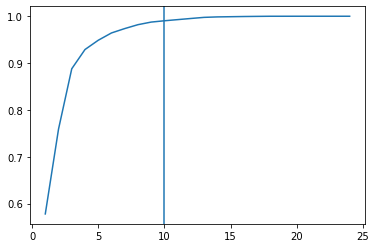

saving...
Estimating Gaussian KLD...
KLD:  0.9890064678439607
train_stats:  (array([ 4.0239734e-03,  1.4481307e-03,  4.6362532e-03,  7.0022099e-04,
        4.3687471e-03,  7.3201866e-03, -2.3789378e-02, -3.4582302e-02,
        6.4293250e-05, -7.3129439e-04], dtype=float32), array([[ 2.80359422e-01,  2.22187066e-03,  3.62483258e-03,
         3.94187481e-03,  2.51310046e-04, -3.83047117e-05,
         7.45383061e-04,  6.52304681e-04,  5.50573293e-04,
        -5.69697146e-04],
       [ 2.22187066e-03,  8.83726296e-02, -8.31769991e-04,
         2.26504483e-04,  5.06863989e-04,  2.62672226e-04,
        -8.31723317e-04,  5.27685993e-04,  2.90963297e-04,
        -2.56884654e-04],
       [ 3.62483258e-03, -8.31769991e-04,  6.26727273e-02,
         2.18087042e-03,  9.37234046e-06,  8.71330637e-05,
         1.12039015e-03, -3.76025463e-04,  5.37166898e-04,
        -5.35234548e-04],
       [ 3.94187481e-03,  2.26504483e-04,  2.18087042e-03,
         2.35787299e-02,  2.47312991e-03,  4.88917423e-04

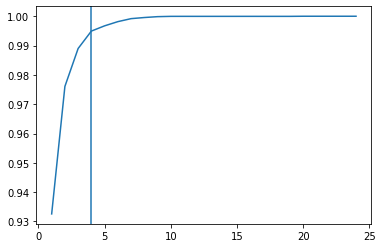

saving...
Estimating Gaussian KLD...
KLD:  2494.0876554876713
train_stats:  (array([-0.0875597 ,  0.01038952,  0.00781274, -0.01561716], dtype=float32), array([[ 0.30734424, -0.01624949, -0.00532666,  0.01138646],
       [-0.01624949,  0.03521214,  0.00949583, -0.01416282],
       [-0.00532666,  0.00949583,  0.01101563,  0.00130316],
       [ 0.01138646, -0.01416282,  0.00130316,  0.00890276]]))
test_stats:  (array([ 0.03102627, -0.0036799 , -0.00276745,  0.0055318 ], dtype=float32), array([[ 7.50390473e-01,  6.19103223e-03,  2.21460318e-03,
        -4.68847767e-03],
       [ 6.19103223e-03,  2.77177075e-02, -3.40179416e-03,
         5.09343811e-03],
       [ 2.21460318e-03, -3.40179416e-03,  8.03548946e-03,
        -4.02976672e-04],
       [-4.68847767e-03,  5.09343811e-03, -4.02976672e-04,
         2.22285490e-03]]))
done
D-12
KLD for D-12
finding PCA...
(312, 25) (312,) (7918, 25) (7918,)
(312, 25) (312,) (5179, 25) (7918,)
(5491, 25)
Done!


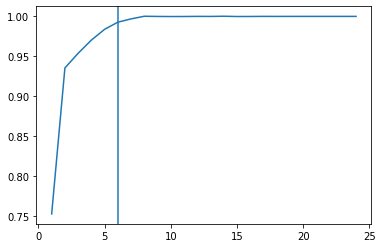

saving...
Estimating Gaussian KLD...
KLD:  16890869250590.963
train_stats:  (array([-2.5350140e-02, -1.4588414e-03,  3.2041947e-04, -3.7166124e-04,
       -1.7613128e-07, -3.8392955e-04], dtype=float32), array([[ 1.56128161e-13, -2.69916781e-12,  6.04055859e-12,
        -1.00853826e-13,  7.91862582e-12, -4.19636967e-12],
       [-2.69916781e-12,  2.66762512e-10, -6.00085901e-10,
         9.95288066e-12, -7.69855614e-10,  4.15366063e-10],
       [ 6.04055859e-12, -6.00085901e-10,  1.35763063e-09,
        -1.72876238e-11,  1.63319493e-09, -9.27597893e-10],
       [-1.00853826e-13,  9.95288066e-12, -1.72876238e-11,
         5.42723616e-12, -7.65789239e-11,  3.24151472e-11],
       [ 7.91862582e-12, -7.69855614e-10,  1.63319493e-09,
        -7.65789239e-11,  3.65817272e-09, -1.15772932e-09],
       [-4.19636967e-12,  4.15366063e-10, -9.27597893e-10,
         3.24151472e-11, -1.15772932e-09,  7.44589766e-10]]))
test_stats:  (array([ 1.5263442e-03,  8.8008994e-05, -1.9398618e-05,  2.2391114e

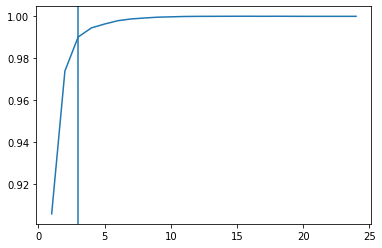

saving...
Estimating Gaussian KLD...
KLD:  8.681611291431582e+18
train_stats:  (array([-0.5391282 , -0.06548836, -0.00346059], dtype=float32), array([[2.88508963e-16, 2.00331551e-15, 6.35297917e-16],
       [2.00331551e-15, 1.40726791e-14, 6.53922203e-15],
       [6.35297917e-16, 6.53922203e-15, 2.98977707e-14]]))
test_stats:  (array([0.10707662, 0.01300421, 0.00068721], dtype=float32), array([[ 8.78151805e-01, -8.40499910e-03, -4.44164344e-04],
       [-8.40499910e-03,  7.03307182e-02, -5.39550392e-05],
       [-4.44164344e-04, -5.39550392e-05,  1.69687592e-02]]))
done
D-14
D-15
D-16
D-2
KLD for D-2
finding PCA...
(2880, 25) (2880,) (8595, 25) (8595,)
(2880, 25) (2880,) (4378, 25) (8595,)
(7258, 25)
Done!


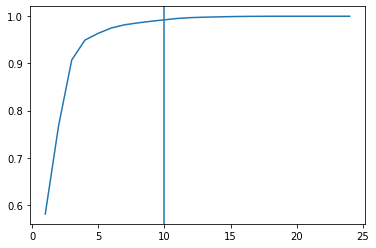

saving...
Estimating Gaussian KLD...
KLD:  0.0638239902847193
train_stats:  (array([-2.7946844e-03, -3.0629404e-04,  4.1782786e-04, -5.8005343e-04,
       -1.5849980e-04, -2.9339144e-04, -3.7938327e-04,  1.7851533e-04,
       -7.6340722e-05, -5.2778320e-05], dtype=float32), array([[ 2.72613818e-01, -1.71269043e-03,  1.72856240e-04,
        -5.66029530e-04, -1.92508647e-04, -7.94394820e-04,
        -5.17733818e-04,  3.09414539e-05, -6.78013097e-04,
        -5.45741244e-04],
       [-1.71269043e-03,  8.94286141e-02,  5.31658976e-04,
        -5.44495879e-04, -1.16465545e-04,  1.42690275e-04,
        -1.29635749e-04,  2.31952411e-04,  2.13271098e-04,
        -1.33458655e-04],
       [ 1.72856240e-04,  5.31658976e-04,  6.69450802e-02,
        -4.76567120e-04, -1.01898113e-05, -1.47589300e-04,
        -7.14226371e-05,  9.53984285e-05,  2.65125782e-04,
         3.92170662e-06],
       [-5.66029530e-04, -5.44495879e-04, -4.76567120e-04,
         1.88173239e-02,  7.06973023e-05, -7.42600773e-04

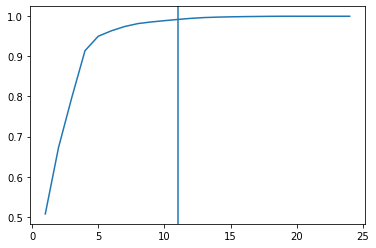

saving...
Estimating Gaussian KLD...
KLD:  651.5986376607303
train_stats:  (array([-0.01212546,  0.00431976,  0.00118362, -0.03309223,  0.00069958,
        0.00014784, -0.00010955, -0.00040076,  0.00116335,  0.00086407,
        0.00018144], dtype=float32), array([[ 2.63307891e-01,  6.27565353e-04,  1.19342182e-03,
        -2.71933406e-03, -1.11658310e-03,  9.03909100e-05,
         1.20589335e-04, -6.48933412e-04,  1.46340367e-03,
         1.39738570e-03, -1.49159089e-04],
       [ 6.27565353e-04,  9.08445973e-02,  2.60641522e-03,
         1.68926951e-03, -8.60686377e-05, -5.22932346e-04,
         7.46737506e-04,  4.75852579e-04,  4.56682002e-04,
         7.79229680e-04,  3.70559567e-04],
       [ 1.19342182e-03,  2.60641522e-03,  6.66286253e-02,
        -1.37765142e-03, -1.80729273e-04,  3.71602980e-04,
        -7.92482399e-04,  1.53531285e-04,  1.08624053e-03,
         7.64407202e-04,  3.23741747e-04],
       [-2.71933406e-03,  1.68926951e-03, -1.37765142e-03,
         1.65986835e-04,

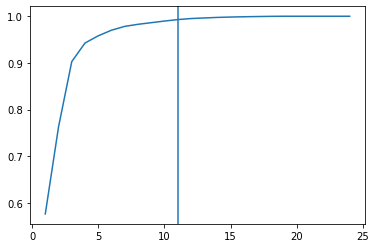

saving...
Estimating Gaussian KLD...
KLD:  0.4300585258299563
train_stats:  (array([-0.00920625,  0.00323618,  0.00267151,  0.00063566, -0.00037785,
        0.00064535,  0.00018937, -0.00102413,  0.00019087,  0.00097321,
       -0.00013648], dtype=float32), array([[ 2.69489969e-01,  1.43479954e-03,  1.83852148e-03,
        -1.47331870e-03, -2.74694971e-04,  4.28258131e-04,
        -1.83925525e-04, -1.40586969e-03, -7.65153744e-05,
         1.64750004e-03, -1.60793311e-04],
       [ 1.43479954e-03,  9.03250232e-02,  2.29234374e-03,
         3.72933685e-04, -4.16137958e-05,  4.45259312e-04,
         5.96206243e-05, -3.66915964e-04,  4.57366307e-04,
         8.46285416e-04,  5.53250027e-05],
       [ 1.83852148e-03,  2.29234374e-03,  6.63204588e-02,
         7.94198342e-04, -1.12637032e-04, -4.46324405e-04,
         4.54240996e-04, -9.06076189e-04,  5.20362150e-04,
         9.34843454e-04,  6.63039302e-05],
       [-1.47331870e-03,  3.72933685e-04,  7.94198342e-04,
         1.76735399e-02

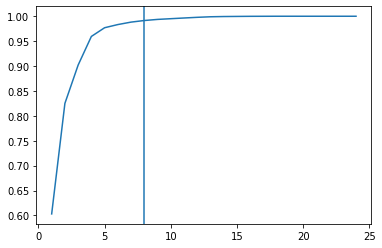

saving...
Estimating Gaussian KLD...
KLD:  38931294.02512912
train_stats:  (array([ 1.4927579e+00,  1.9436855e-03, -1.3486846e-04, -8.7222048e-05,
       -7.4747450e-06,  2.8934954e-05, -2.8746330e-05, -8.1860753e-06],
      dtype=float32), array([[ 3.60907066e-06, -9.75288240e-04,  7.10109099e-05,
         3.30563754e-05,  1.21342142e-07, -2.09574170e-06,
         3.28895131e-06,  6.55059245e-07],
       [-9.75288240e-04,  2.74000630e-01,  5.64792583e-04,
         1.29116954e-03,  1.19528686e-03, -8.28825575e-04,
         8.80006457e-04, -6.50222902e-04],
       [ 7.10109099e-05,  5.64792583e-04,  9.43027016e-02,
         4.43110976e-05, -1.99616069e-05,  2.29231886e-04,
         2.35805955e-04, -4.87708361e-04],
       [ 3.30563754e-05,  1.29116954e-03,  4.43110976e-05,
         6.91259661e-02, -1.14717143e-04, -7.38823897e-05,
         3.83169997e-04, -2.64958516e-05],
       [ 1.21342142e-07,  1.19528686e-03, -1.99616069e-05,
        -1.14717143e-04,  2.18382695e-02,  4.91393577e-0

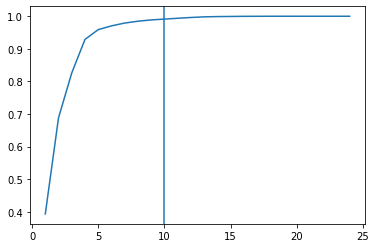

saving...
Estimating Gaussian KLD...
KLD:  7.267946564693412
train_stats:  (array([ 3.8236685e-03,  6.7635798e-01, -3.6718156e-03, -1.4660652e-03,
       -1.3968528e-03, -2.0707420e-03,  6.0648593e-04, -3.3651871e-04,
        4.7175752e-04,  1.3548046e-04], dtype=float32), array([[ 2.66898649e-01,  5.98611931e-03,  1.27681682e-03,
         2.49838766e-03,  1.57230775e-03, -5.82510127e-04,
         1.26533659e-04,  2.00379244e-04,  4.05360402e-04,
         1.75206403e-04],
       [ 5.98611931e-03,  1.99166049e-01,  9.05356615e-04,
         2.37914533e-04,  1.06166535e-03,  1.83466380e-03,
        -5.74350379e-04,  2.94140765e-04, -4.32136837e-04,
        -1.31572299e-04],
       [ 1.27681682e-03,  9.05356615e-04,  9.27262968e-02,
        -9.34202128e-04, -1.59458333e-04, -1.31587118e-04,
         5.95790762e-04,  6.12788864e-05,  1.36829033e-04,
        -1.49061658e-04],
       [ 2.49838766e-03,  2.37914533e-04, -9.34202128e-04,
         6.91949976e-02,  2.08485469e-04, -4.64882666e-04,

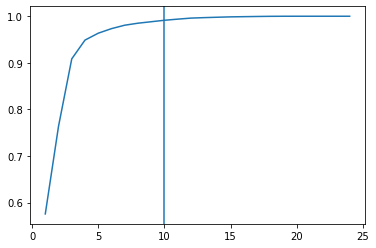

saving...
Estimating Gaussian KLD...
KLD:  0.09710100738407501
train_stats:  (array([ 6.9745868e-03, -1.8369781e-03, -1.5557524e-03,  5.3145821e-05,
       -2.9936595e-05, -1.9856170e-04, -2.4348634e-04, -2.5110511e-04,
       -4.4112888e-08, -5.0318169e-05], dtype=float32), array([[ 3.04766583e-01, -1.95296720e-04, -2.37388642e-03,
         5.21647424e-04,  7.57107659e-05,  6.02543641e-05,
        -4.55611259e-04, -3.35915087e-04,  8.77433176e-05,
         5.16730310e-04],
       [-1.95296720e-04,  1.01470067e-01,  1.73529567e-03,
         5.28946936e-04,  1.37109905e-07, -9.28486741e-04,
        -1.09351985e-04, -7.31361625e-05, -3.11303445e-04,
        -1.28509157e-04],
       [-2.37388642e-03,  1.73529567e-03,  7.61628449e-02,
         3.11130653e-04, -3.12479509e-04, -3.00834467e-04,
        -7.35421631e-04, -2.97227228e-05,  6.76475875e-05,
         3.63137845e-04],
       [ 5.21647424e-04,  5.28946936e-04,  3.11130653e-04,
         2.12242201e-02,  1.84367594e-04, -7.25730567e-0

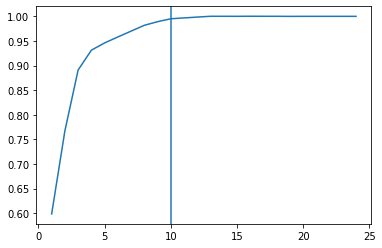

saving...
Estimating Gaussian KLD...
KLD:  2.007410967655278
train_stats:  (array([ 1.3205573e-02, -8.3549385e-04,  1.7388629e-03,  8.8704092e-04,
        5.5400960e-05, -1.4274547e-04,  1.4430202e-04,  2.1957302e-04,
        1.0903096e-04,  3.2711925e-04], dtype=float32), array([[ 4.36560529e-02,  1.09429048e-03,  1.49302067e-03,
         3.90426419e-04,  5.80154316e-04, -4.71694020e-04,
        -5.81004491e-05, -3.76671972e-04, -1.60740935e-04,
         5.44461939e-05],
       [ 1.09429048e-03,  1.27353055e-02,  9.38875476e-05,
         4.61555033e-04,  1.93454635e-04,  1.69318761e-04,
         1.33050257e-04,  2.68475653e-05, -7.12855400e-05,
         6.24012608e-05],
       [ 1.49302067e-03,  9.38875476e-05,  9.78950980e-03,
         5.81822323e-04,  2.85988913e-04,  1.86852126e-04,
         1.94820015e-04,  1.39470813e-06,  5.98192954e-05,
        -1.32552232e-05],
       [ 3.90426419e-04,  4.61555033e-04,  5.81822323e-04,
         3.32415299e-03,  3.03212452e-04, -1.52331696e-05,

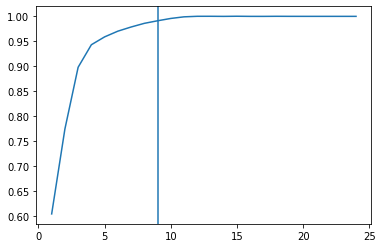

saving...
Estimating Gaussian KLD...
KLD:  1.8627420261657273
train_stats:  (array([ 0.01741741, -0.00213468,  0.00124737,  0.00085011, -0.00013778,
        0.00015884,  0.00111718,  0.00013915,  0.00043968], dtype=float32), array([[ 6.27093594e-02, -3.44383380e-04, -2.54605076e-04,
        -4.59415980e-04, -5.72981496e-04, -1.39619929e-04,
         1.79729665e-04,  1.65125102e-04, -2.03153583e-05],
       [-3.44383380e-04,  1.82734262e-02,  3.69848046e-04,
         1.61806934e-04,  4.98701545e-05,  1.00012492e-04,
         2.21638799e-04,  1.49860778e-04,  2.39693953e-06],
       [-2.54605076e-04,  3.69848046e-04,  1.39364596e-02,
         4.98043745e-04, -1.18988053e-04, -1.45887345e-04,
         3.45848339e-04,  5.29263220e-05, -1.32210675e-06],
       [-4.59415980e-04,  1.61806934e-04,  4.98043745e-04,
         4.76624400e-03, -1.85131772e-04, -9.89187087e-05,
         2.46144894e-04,  8.01793033e-05, -1.07357598e-06],
       [-5.72981496e-04,  4.98701545e-05, -1.18988053e-04,
    

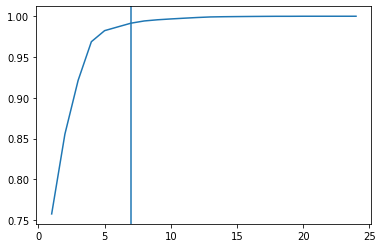

saving...
Estimating Gaussian KLD...
KLD:  0.43460990836258784
train_stats:  (array([ 0.03362904,  0.04593488,  0.01606657, -0.00792873,  0.00190053,
       -0.00202935,  0.00198782], dtype=float32), array([[ 8.54592486e-01,  6.90317227e-02,  1.34929847e-02,
        -1.78301951e-02,  4.43759572e-03, -4.60003046e-03,
         4.58977299e-03],
       [ 6.90317227e-02,  9.24979829e-02, -9.20882758e-03,
         1.10704170e-02,  6.08646434e-04,  3.34367060e-03,
        -9.47650948e-04],
       [ 1.34929847e-02, -9.20882758e-03,  8.64959830e-02,
         4.12899327e-03,  2.61748481e-04,  6.45330311e-04,
        -2.68609569e-04],
       [-1.78301951e-02,  1.10704170e-02,  4.12899327e-03,
         6.14814737e-02,  1.55795640e-03, -8.88913179e-04,
         8.04260239e-04],
       [ 4.43759572e-03,  6.08646434e-04,  2.61748481e-04,
         1.55795640e-03,  2.19415804e-02, -2.43014216e-04,
        -2.54810201e-04],
       [-4.60003046e-03,  3.34367060e-03,  6.45330311e-04,
        -8.88913179e-

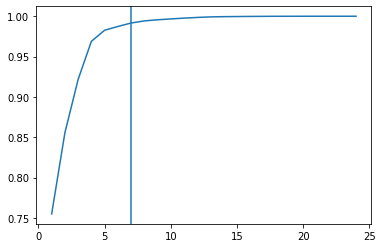

saving...
Estimating Gaussian KLD...
KLD:  0.43807170324557587
train_stats:  (array([ 0.03711778,  0.05008855, -0.01535584, -0.0080497 ,  0.00243627,
       -0.00235815, -0.00055735], dtype=float32), array([[ 8.46811183e-01,  7.71319386e-02, -1.13064092e-02,
        -1.87936533e-02,  5.96057553e-03, -5.84359175e-03,
        -1.56557954e-03],
       [ 7.71319386e-02,  9.74732660e-02,  9.88620708e-03,
         1.13756131e-02,  1.31554513e-03,  3.48075450e-03,
        -3.41317659e-04],
       [-1.13064092e-02,  9.88620708e-03,  8.71514581e-02,
        -3.73350377e-03, -1.62720724e-04, -7.91812665e-04,
        -2.78332873e-05],
       [-1.87936533e-02,  1.13756131e-02, -3.73350377e-03,
         6.12726477e-02,  1.53794553e-03, -8.74760917e-04,
        -3.29276375e-04],
       [ 5.96057553e-03,  1.31554513e-03, -1.62720724e-04,
         1.53794553e-03,  2.21041610e-02, -2.18840987e-04,
         7.47480204e-05],
       [-5.84359175e-03,  3.48075450e-03, -7.91812665e-04,
        -8.74760917e-

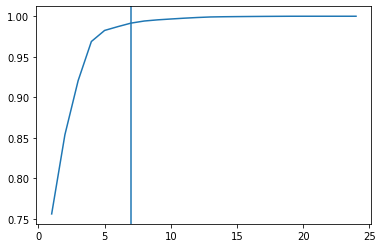

saving...
Estimating Gaussian KLD...
KLD:  0.44226838380492906
train_stats:  (array([ 0.04086912,  0.04849803, -0.01682942, -0.00839017,  0.00145373,
       -0.00281778, -0.00073604], dtype=float32), array([[ 8.55566068e-01,  7.27597719e-02, -1.38285465e-02,
        -1.93104680e-02,  4.77537269e-03, -6.44825447e-03,
        -2.09985715e-03],
       [ 7.27597719e-02,  9.25559958e-02,  1.09778686e-02,
         1.25376376e-02,  1.67591052e-03,  3.42396327e-03,
        -6.71888320e-04],
       [-1.38285465e-02,  1.09778686e-02,  8.86366820e-02,
        -3.58765410e-03, -1.29059411e-03, -8.01396851e-04,
        -3.50098944e-04],
       [-1.93104680e-02,  1.25376376e-02, -3.58765410e-03,
         6.26475875e-02,  3.27725345e-04, -1.28173159e-03,
        -5.28836018e-04],
       [ 4.77537269e-03,  1.67591052e-03, -1.29059411e-03,
         3.27725345e-04,  2.05057459e-02, -4.98228123e-04,
        -1.02842446e-03],
       [-6.44825447e-03,  3.42396327e-03, -8.01396851e-04,
        -1.28173159e-

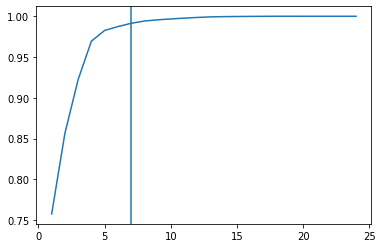

saving...
Estimating Gaussian KLD...
KLD:  0.43329133798920383
train_stats:  (array([ 0.03491601,  0.04605286,  0.01684159, -0.00962483,  0.00191968,
       -0.00225124, -0.00137598], dtype=float32), array([[ 8.57009884e-01,  7.03715907e-02,  1.43857083e-02,
        -2.00404381e-02,  5.23777945e-03, -5.24447878e-03,
        -3.33832718e-03],
       [ 7.03715907e-02,  9.61276840e-02, -1.00617635e-02,
         1.19985625e-02,  1.98610948e-03,  3.48415604e-03,
         8.35719262e-05],
       [ 1.43857083e-02, -1.00617635e-02,  8.52748109e-02,
         4.77957099e-03,  4.83342196e-04,  9.99968295e-04,
         1.80918506e-04],
       [-2.00404381e-02,  1.19985625e-02,  4.77957099e-03,
         5.96357773e-02,  1.10418304e-03, -9.29728201e-04,
        -6.18429965e-04],
       [ 5.23777945e-03,  1.98610948e-03,  4.83342196e-04,
         1.10418304e-03,  2.12538839e-02, -3.39686049e-04,
         4.40142954e-04],
       [-5.24447878e-03,  3.48415604e-03,  9.99968295e-04,
        -9.29728201e-

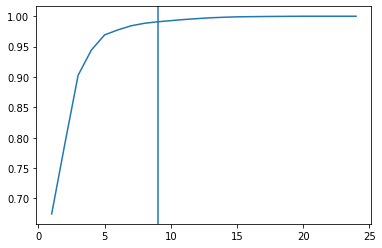

saving...
Estimating Gaussian KLD...
KLD:  0.07726833063132688
train_stats:  (array([ 1.8293380e-03, -2.6085274e-04,  2.4306274e-03, -5.5100871e-05,
       -2.3308550e-03, -8.8058534e-04, -9.0914237e-04, -1.6630775e-03,
       -3.3595186e-04], dtype=float32), array([[ 5.13061534e-01,  1.44543702e-03,  5.25843448e-03,
        -6.80118524e-03, -2.55310833e-04, -8.32456109e-04,
        -2.01625013e-03, -2.17041311e-03,  2.88694407e-04],
       [ 1.44543702e-03,  9.34616552e-02,  5.57061930e-05,
        -4.80756297e-04, -1.53062710e-03, -1.64445719e-05,
        -1.10880552e-03, -2.38932667e-04, -1.24021512e-05],
       [ 5.25843448e-03,  5.57061930e-05,  9.32796045e-02,
        -3.15407967e-05, -1.13135858e-04, -2.23535903e-04,
        -5.37193283e-04,  6.06518545e-06, -7.05387308e-04],
       [-6.80118524e-03, -4.80756297e-04, -3.15407967e-05,
         3.38807350e-02,  5.71665820e-04, -1.57148086e-05,
         7.93548991e-04,  8.13644834e-05, -2.80766678e-04],
       [-2.55310833e-04, -1.

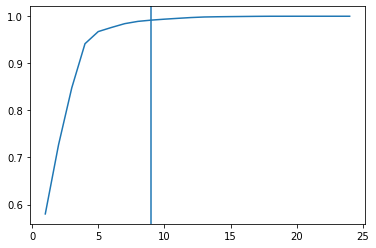

saving...
Estimating Gaussian KLD...
KLD:  0.5385773415747614
train_stats:  (array([-8.0387294e-03,  4.1960400e-02,  5.2864015e-02, -3.3772342e-02,
        3.0192707e-03, -7.9434300e-03,  4.6826459e-05,  6.6526799e-04,
        4.3625836e-04], dtype=float32), array([[ 4.79823895e-01, -3.82322099e-02, -4.55235317e-02,
         3.35878780e-02,  1.36591760e-03,  6.14439931e-03,
         1.58670540e-03, -4.49065978e-04, -1.04909680e-03],
       [-3.82322099e-02,  1.09502953e-01,  7.01768781e-03,
        -3.67951220e-03,  3.89720659e-04,  1.66110427e-05,
         2.56989862e-04,  1.39076966e-04, -5.22059339e-05],
       [-4.55235317e-02,  7.01768781e-03,  8.76775112e-02,
        -1.45463868e-03,  5.66009272e-04,  9.31081713e-05,
        -1.74582348e-04, -2.18466462e-04,  1.22435543e-04],
       [ 3.35878780e-02, -3.67951220e-03, -1.45463868e-03,
         6.44912058e-02,  1.33617146e-03, -6.90362859e-04,
         7.77273928e-04,  4.15485394e-04, -4.10856101e-04],
       [ 1.36591760e-03,  3.8

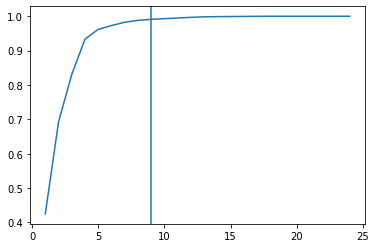

saving...
Estimating Gaussian KLD...
KLD:  2.424919147075167
train_stats:  (array([ 4.5259375e-02,  4.1979793e-01,  2.3926552e-03,  1.8907154e-03,
       -6.7682570e-04,  2.6624196e-04,  5.3570932e-04, -5.4870866e-04,
        9.2047630e-05], dtype=float32), array([[ 2.75651506e-01,  2.51952299e-04,  1.77618944e-04,
         1.11485812e-03,  3.17857008e-03,  5.90033213e-04,
         1.90391240e-03,  3.72512797e-04, -3.31670287e-04],
       [ 2.51952299e-04,  1.73075229e-01,  4.11748498e-04,
        -4.82382984e-04,  2.08818772e-05, -2.24761606e-04,
        -3.38194294e-04,  3.53993992e-04, -9.90373757e-05],
       [ 1.77618944e-04,  4.11748498e-04,  8.98205605e-02,
        -2.72670003e-04, -2.71215222e-04, -2.93480961e-05,
        -5.55099791e-05,  1.57739907e-04, -9.33986084e-05],
       [ 1.11485812e-03, -4.82382984e-04, -2.72670003e-04,
         6.73045139e-02,  1.31820643e-03,  2.03847954e-04,
         5.06834403e-04,  2.09252536e-04, -2.79121124e-04],
       [ 3.17857008e-03,  2.08

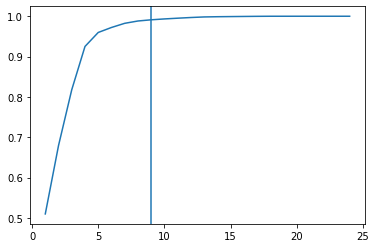

saving...
Estimating Gaussian KLD...
KLD:  0.925620189714814
train_stats:  (array([-0.09761208,  0.19753392, -0.05556049, -0.04871352,  0.00451545,
        0.0044719 , -0.01150483,  0.00148858,  0.00043287], dtype=float32), array([[ 3.60149443e-01, -3.31658825e-02,  1.09526557e-02,
         1.09888362e-02,  4.54335400e-03,  2.48417335e-03,
         2.80484197e-03, -2.86741764e-04, -8.93659969e-04],
       [-3.31658825e-02,  1.20031073e-01, -1.60768665e-03,
        -4.15134942e-04,  7.47656192e-04, -6.99235870e-05,
         4.60697768e-04,  2.51892648e-04, -1.05147669e-06],
       [ 1.09526557e-02, -1.60768665e-03,  9.03314711e-02,
         7.17193113e-04,  4.47199850e-04, -9.53546470e-05,
        -5.11037640e-04,  5.47439054e-04, -2.66374409e-04],
       [ 1.09888362e-02, -4.15134942e-04,  7.17193113e-04,
         7.05257611e-02,  1.78367249e-03,  1.04696526e-03,
         2.76360144e-04,  3.47336457e-04, -4.89015471e-04],
       [ 4.54335400e-03,  7.47656192e-04,  4.47199850e-04,
     

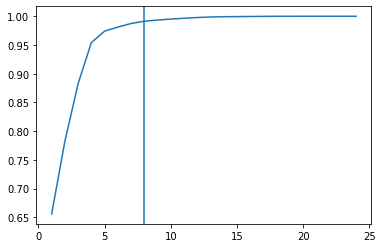

saving...
Estimating Gaussian KLD...
KLD:  0.6368034986484883
train_stats:  (array([ 1.5484397e-01, -4.8243247e-02, -1.1275845e-02,  2.2000993e-02,
        2.7753095e-04,  5.9154485e-03,  1.1933197e-03,  6.7473717e-05],
      dtype=float32), array([[ 8.33371847e-01, -9.50928528e-02, -3.59880384e-02,
         3.43721601e-02,  1.80528730e-03,  7.87593489e-03,
         2.33068220e-03, -1.70828662e-04],
       [-9.50928528e-02,  1.08672564e-01, -3.18769804e-03,
         4.81016963e-03,  6.84661680e-04,  1.66591710e-03,
         1.37737152e-04,  3.58505872e-04],
       [-3.59880384e-02, -3.18769804e-03,  8.72265379e-02,
         2.22574080e-03,  7.34294092e-04,  6.25902231e-04,
         1.70767521e-04,  5.06255564e-05],
       [ 3.43721601e-02,  4.81016963e-03,  2.22574080e-03,
         6.04217146e-02,  8.89144946e-04, -9.70781925e-04,
        -1.14264094e-05,  2.53097352e-05],
       [ 1.80528730e-03,  6.84661680e-04,  7.34294092e-04,
         8.89144946e-04,  1.98817940e-02, -1.52497340e-

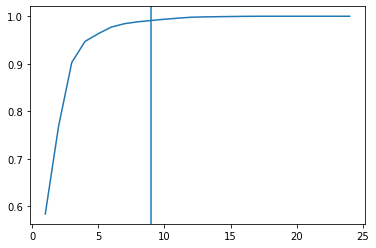

saving...
Estimating Gaussian KLD...
KLD:  0.42352402356012053
train_stats:  (array([ 6.2395435e-02, -7.8775436e-03,  2.2808036e-03,  4.8117898e-04,
        1.3879277e-03, -9.4313647e-05,  2.1120691e-04, -1.6844916e-04,
        4.4911433e-04], dtype=float32), array([[ 2.85654324e-01,  3.89748992e-03,  1.81410602e-03,
         2.21922368e-03,  2.27373434e-03,  4.63030513e-04,
        -1.13289386e-05, -5.22890130e-04,  2.37813460e-04],
       [ 3.89748992e-03,  9.24071441e-02, -1.20850801e-03,
        -2.90736798e-04,  1.16523430e-04,  8.06615089e-05,
         2.55475947e-04, -2.55543740e-04, -7.45027331e-06],
       [ 1.81410602e-03, -1.20850801e-03,  6.85794262e-02,
         8.75457295e-04,  8.19578254e-04,  9.66497643e-05,
         1.14216800e-04, -3.07925026e-04, -1.83816657e-04],
       [ 2.21922368e-03, -2.90736798e-04,  8.75457295e-04,
         2.37277339e-02,  1.17087061e-03, -3.27082187e-06,
         6.83414662e-04, -5.14545468e-04, -6.34749682e-05],
       [ 2.27373434e-03,  1.

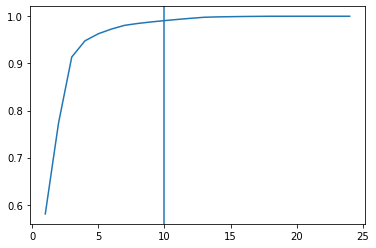

saving...
Estimating Gaussian KLD...
KLD:  0.6710293299872117
train_stats:  (array([ 6.3149646e-02, -8.5801426e-03,  2.0339733e-03,  1.4537267e-03,
       -1.3432159e-05, -8.7702333e-04,  7.7426480e-04,  1.2481298e-04,
       -2.4179199e-03,  7.0837600e-04], dtype=float32), array([[ 2.81482714e-01,  2.83959489e-03,  9.82295256e-04,
         2.94204057e-03,  9.76166239e-05, -1.22323544e-03,
         1.02323213e-03, -9.24872557e-04,  6.84080643e-04,
         3.67674683e-05],
       [ 2.83959489e-03,  9.49245641e-02, -1.87808415e-03,
         3.65364586e-04,  2.29132939e-04,  2.18786666e-04,
        -5.49756484e-04, -1.17465338e-05, -1.57968669e-04,
        -4.41475097e-05],
       [ 9.82295256e-04, -1.87808415e-03,  7.06916599e-02,
         8.41438750e-04, -7.64297032e-05, -3.31629191e-04,
         3.49738158e-04, -2.11765914e-04, -1.08109669e-04,
        -4.06523969e-04],
       [ 2.94204057e-03,  3.65364586e-04,  8.41438750e-04,
         1.96102303e-02,  2.01377747e-04,  9.12820535e-04

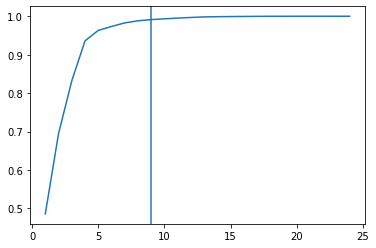

saving...
Estimating Gaussian KLD...
KLD:  0.6614481960464884
train_stats:  (array([ 0.07992412, -0.02627767, -0.00012089,  0.00403932,  0.0022625 ,
        0.00212599,  0.00112491, -0.0003833 , -0.00059159], dtype=float32), array([[ 3.35396171e-01, -4.61548315e-02,  1.17035849e-02,
         2.41751847e-03,  4.41371615e-03,  1.72263348e-03,
         1.05554564e-03, -6.81747896e-04, -7.65662097e-04],
       [-4.61548315e-02,  1.97616509e-01, -1.05107956e-02,
        -5.80297637e-04,  1.05196265e-03, -4.35162756e-04,
         1.32966525e-04,  8.48625705e-06, -8.03904615e-05],
       [ 1.17035849e-02, -1.05107956e-02,  9.21642048e-02,
        -1.44598771e-04, -1.86411724e-04, -7.17995286e-06,
         2.59107691e-04,  3.92696363e-04, -2.92527782e-04],
       [ 2.41751847e-03, -5.80297637e-04, -1.44598771e-04,
         6.96889435e-02,  1.34600163e-03, -1.89059750e-05,
         1.01716523e-03,  7.50563039e-05, -5.84525786e-04],
       [ 4.41371615e-03,  1.05196265e-03, -1.86411724e-04,
    

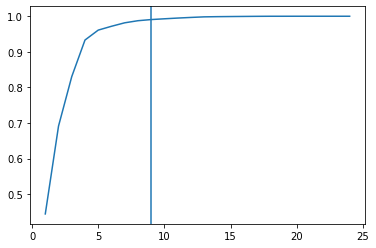

saving...
Estimating Gaussian KLD...
KLD:  0.6908139597195104
train_stats:  (array([ 0.07781222,  0.09580489, -0.00119777,  0.00040469,  0.00170764,
        0.00280199,  0.00136683, -0.00026933, -0.00045668], dtype=float32), array([[ 2.77954042e-01,  1.15362628e-02,  4.64539808e-04,
        -1.05933789e-03,  3.07310365e-03,  2.76030287e-05,
         1.36229281e-03, -1.61314200e-04, -4.29824872e-04],
       [ 1.15362628e-02,  2.67948874e-01,  8.26562623e-03,
        -9.66977435e-04, -5.70977280e-04,  2.82631313e-04,
        -2.92616851e-04, -5.60611030e-05,  9.51860738e-05],
       [ 4.64539808e-04,  8.26562623e-03,  9.18538334e-02,
         7.64993677e-04, -1.33485876e-04, -4.57182347e-06,
         1.13190686e-04,  3.71317132e-04, -2.16232085e-04],
       [-1.05933789e-03, -9.66977435e-04,  7.64993677e-04,
         6.91426208e-02,  1.35075049e-03,  1.28952978e-05,
         5.77396634e-04,  2.19908607e-04, -3.56048167e-04],
       [ 3.07310365e-03, -5.70977280e-04, -1.33485876e-04,
    

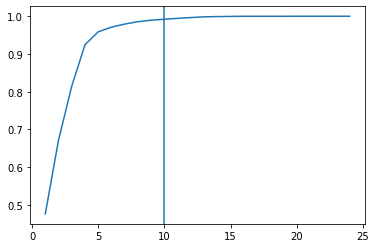

saving...
Estimating Gaussian KLD...
KLD:  5.11732390837399
train_stats:  (array([ 0.1378177 , -0.03009588, -0.00576586,  0.00528842, -0.00051586,
       -0.00099527,  0.00066006,  0.00024739,  0.00132439,  0.00059645],
      dtype=float32), array([[ 2.66660113e-01, -8.54585066e-03,  8.38573953e-03,
        -2.90355061e-03,  4.07538301e-04,  5.33885846e-04,
        -3.86030628e-04, -7.21319346e-04, -1.13975124e-04,
         3.41456455e-04],
       [-8.54585066e-03,  5.77126753e-02,  2.63425258e-02,
        -2.07327785e-04,  5.59654553e-05, -1.23695552e-04,
        -6.34970450e-05,  4.16628297e-04,  3.61492201e-04,
         6.86804368e-05],
       [ 8.38573953e-03,  2.63425258e-02,  7.69021802e-02,
         1.08112192e-03,  3.06327647e-04, -2.22576644e-04,
         5.96918111e-05,  6.42499422e-05, -2.45774879e-04,
         1.21849653e-04],
       [-2.90355061e-03, -2.07327785e-04,  1.08112192e-03,
         6.82559111e-02,  5.69905111e-04,  1.62439210e-04,
         2.15154744e-05, -9.132

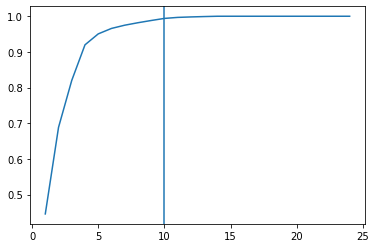

saving...
Estimating Gaussian KLD...
KLD:  1.8135940241718815
train_stats:  (array([ 2.2601174e-02,  2.1327719e-02, -4.5955940e-03,  3.3664127e-04,
        5.1231577e-06, -7.0716284e-04,  2.6979798e-04,  5.6012486e-05,
       -1.9123836e-05,  3.0786108e-04], dtype=float32), array([[ 5.93241257e-02, -1.13531674e-03,  2.09627050e-04,
        -5.55377949e-04, -9.13225540e-04, -4.41744763e-04,
        -4.54027706e-05,  6.97307228e-05, -1.64227054e-04,
         1.43447274e-04],
       [-1.13531674e-03,  2.92957759e-02,  5.73367503e-04,
         1.24390140e-04, -1.53462810e-04,  1.01288833e-04,
        -1.73087413e-05, -9.19918339e-06,  2.54161265e-05,
        -5.77443677e-05],
       [ 2.09627050e-04,  5.73367503e-04,  1.88673753e-02,
         3.97496090e-04, -1.37215525e-04,  2.36646083e-05,
         4.85583349e-05, -4.50953591e-05, -8.53266198e-06,
        -6.82738777e-05],
       [-5.55377949e-04,  1.24390140e-04,  3.97496090e-04,
         1.38171208e-02, -3.69818390e-04, -2.62381178e-05

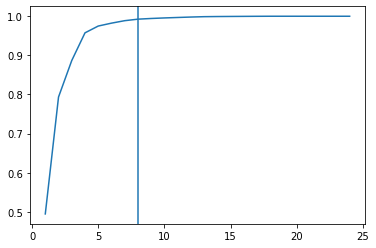

saving...
Estimating Gaussian KLD...
KLD:  0.3129094070868188
train_stats:  (array([ 0.0118731 ,  0.06478284, -0.00878562,  0.00209887,  0.00229419,
        0.00033541,  0.00107251, -0.00015733], dtype=float32), array([[ 3.33818407e-01, -5.92746306e-03,  5.52870586e-03,
        -5.45921224e-04,  1.59110680e-03,  1.17309035e-03,
         1.17260409e-03, -5.52176536e-04],
       [-5.92746306e-03,  2.95291345e-01,  1.80843285e-03,
         3.10057424e-03,  4.04347546e-03,  3.90280969e-04,
         9.47880845e-04,  3.53154848e-04],
       [ 5.52870586e-03,  1.80843285e-03,  9.26829718e-02,
         6.82258707e-05, -3.53258568e-04, -2.15546045e-04,
        -4.59612878e-04,  2.19352619e-04],
       [-5.45921224e-04,  3.10057424e-03,  6.82258707e-05,
         7.02177020e-02,  1.03315818e-03,  3.16403879e-04,
         6.51619532e-04,  1.82480287e-04],
       [ 1.59110680e-03,  4.04347546e-03, -3.53258568e-04,
         1.03315818e-03,  1.87704896e-02, -1.61315313e-04,
         8.50508270e-04,  

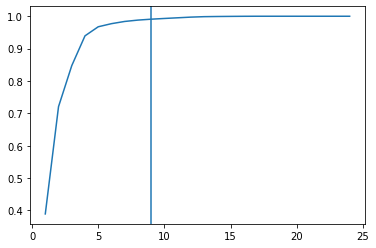

saving...
Estimating Gaussian KLD...
KLD:  0.043525971865175705
train_stats:  (array([ 4.2715291e-03, -3.1999415e-03,  6.0779650e-05, -1.2344763e-03,
       -5.0803670e-04,  4.1473922e-04,  3.0260655e-04,  8.2136190e-04,
        2.3979356e-04], dtype=float32), array([[ 2.94781060e-01, -2.37672747e-03, -1.53089746e-03,
        -4.19256518e-04,  7.11611303e-04,  2.10061491e-04,
         9.31721093e-05,  5.58344349e-04,  3.55982797e-04],
       [-2.37672747e-03,  2.17481458e-01,  1.50151127e-03,
        -2.11637511e-03, -1.79032326e-03, -7.74898248e-05,
        -2.95607653e-04,  2.97924285e-04,  3.66535373e-04],
       [-1.53089746e-03,  1.50151127e-03,  9.14723010e-02,
         8.56764647e-04, -3.21877313e-04, -1.62752814e-04,
        -4.26592624e-04, -1.84464437e-04, -4.14197338e-05],
       [-4.19256518e-04, -2.11637511e-03,  8.56764647e-04,
         6.63857273e-02, -9.46551986e-04,  9.25876486e-05,
         1.57336668e-04,  5.83155477e-05,  1.02277868e-04],
       [ 7.11611303e-04, -1

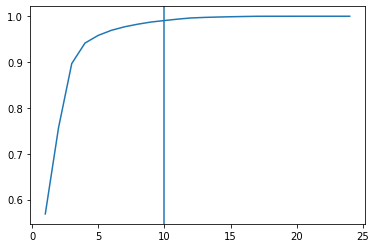

saving...
Estimating Gaussian KLD...
KLD:  0.4339849370262625
train_stats:  (array([-1.0428108e-02,  3.6832952e-04,  6.1730520e-05, -2.5999129e-03,
       -2.5440956e-04,  4.8376332e-04, -1.0227888e-03, -2.8718120e-04,
       -3.8342763e-04, -4.2497131e-04], dtype=float32), array([[ 2.93778007e-01, -3.27666080e-04,  8.50596750e-04,
        -3.18956489e-03,  1.32208552e-04,  5.19455413e-04,
        -5.45239321e-04,  1.02337106e-03,  4.09784244e-04,
        -6.07916468e-04],
       [-3.27666080e-04,  9.82851551e-02, -9.82864776e-04,
        -4.11560548e-04, -3.44274509e-04, -7.33288438e-04,
        -6.11984936e-04, -1.53472893e-04, -1.37556260e-04,
        -3.01906391e-04],
       [ 8.50596750e-04, -9.82864776e-04,  7.26160187e-02,
        -1.56769622e-03, -4.52473104e-06,  3.25085903e-04,
         1.58565793e-04, -4.75300235e-05, -2.80344257e-04,
        -2.69881943e-04],
       [-3.18956489e-03, -4.11560548e-04, -1.56769622e-03,
         2.15902233e-02, -4.28024863e-04, -1.18131312e-03

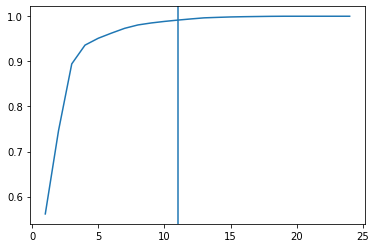

saving...
Estimating Gaussian KLD...
KLD:  3.2772753494846363
train_stats:  (array([-4.7427407e-03,  2.3200773e-03,  2.0772589e-03,  1.8182847e-03,
       -1.9726798e-05,  7.7400464e-03,  4.7146906e-03,  6.2527123e-04,
       -2.7714341e-04,  7.2374765e-04,  2.0208003e-04], dtype=float32), array([[ 3.02731664e-01,  3.82558834e-04,  2.01402024e-03,
         2.76941516e-03, -2.24841702e-04, -2.23965270e-03,
        -8.20391750e-04, -4.67975882e-04,  4.53186132e-04,
         4.40102639e-04,  1.65960542e-03],
       [ 3.82558834e-04,  1.01061491e-01, -5.12382113e-04,
         3.93089739e-04, -2.97610968e-05, -3.46083612e-04,
         5.49380168e-04, -2.41581386e-04, -3.79307715e-04,
        -9.25716180e-05, -4.74783722e-04],
       [ 2.01402024e-03, -5.12382113e-04,  8.16064112e-02,
         8.05579877e-04, -1.16059139e-04,  2.42431295e-04,
         7.03811296e-04,  8.36723467e-05, -2.34383389e-05,
        -1.07334384e-04,  2.52148216e-04],
       [ 2.76941516e-03,  3.93089739e-04,  8.0557

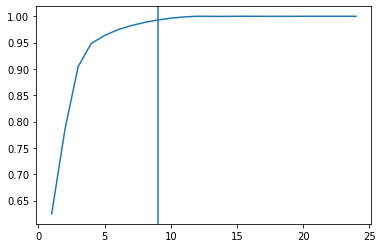

saving...
Estimating Gaussian KLD...
KLD:  133.21669924963265
train_stats:  (array([ 3.9766889e-02,  5.6158467e-03,  1.6404119e-04, -3.0997934e-04,
        1.4577972e-04,  3.6655489e-04,  8.0261219e-05,  5.9239409e-04,
        2.1226106e-04], dtype=float32), array([[ 7.51880520e-02, -2.58467731e-04, -2.55225401e-04,
        -1.68890238e-04,  1.03330563e-04,  1.02531690e-05,
        -1.70041849e-04, -3.17237263e-05, -7.25795082e-05],
       [-2.58467731e-04,  1.97221438e-02,  9.70261623e-05,
         7.92599544e-05, -4.62316409e-05, -1.48056174e-05,
         6.78614384e-05, -4.33988889e-06,  2.35342869e-05],
       [-2.55225401e-04,  9.70261623e-05,  1.42402225e-02,
        -4.69871662e-04,  2.82008056e-04,  7.54630276e-05,
        -4.20556248e-04, -7.74602949e-07, -1.55573663e-04],
       [-1.68890238e-04,  7.92599544e-05, -4.69871662e-04,
         5.10341878e-03,  2.11913457e-04,  5.68724995e-05,
        -3.16255034e-04, -2.38253917e-07, -1.16810972e-04],
       [ 1.03330563e-04, -4.6

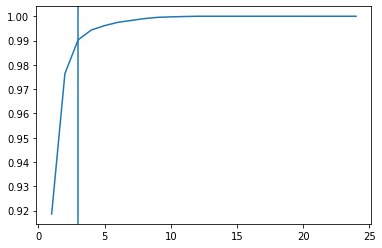

saving...
Estimating Gaussian KLD...
KLD:  0.49158785368806557
train_stats:  (array([0.14404774, 0.01776609, 0.00228288], dtype=float32), array([[0.33475246, 0.03529593, 0.0028941 ],
       [0.03529593, 0.05692228, 0.00054463],
       [0.0028941 , 0.00054463, 0.0142284 ]]))
test_stats:  (array([-0.04859522, -0.00599346, -0.00077014], dtype=float32), array([[ 6.04031377e-01, -1.30592015e-02, -1.12449250e-03],
       [-1.30592015e-02,  2.63187395e-02, -2.01991361e-04],
       [-1.12449250e-03, -2.01991361e-04,  6.19759632e-03]]))
done
G-7
KLD for G-7
finding PCA...
(2446, 25) (2446,) (8029, 25) (8029,)
(2446, 25) (2446,) (7764, 25) (8029,)
(10210, 25)
Done!


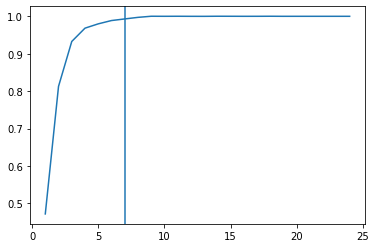

saving...
Estimating Gaussian KLD...
KLD:  27335461986.770664
train_stats:  (array([-1.6099669e-02,  5.0216326e-03, -1.1137397e-03,  9.3551469e-05,
        8.6156528e-05, -1.3642188e-04, -5.5807682e-06], dtype=float32), array([[ 2.56585272e-05, -8.91726340e-04, -1.05047098e-06,
         6.37401315e-08,  5.45170430e-08, -8.53640998e-08,
        -2.90742913e-09],
       [-8.91726340e-04,  3.09910174e-02,  3.65007488e-05,
        -2.21562117e-06, -1.89313200e-06,  2.96692601e-06,
         1.07587087e-07],
       [-1.05047098e-06,  3.65007488e-05,  4.35832490e-08,
        -2.66325533e-09, -2.34211373e-09,  3.48727606e-09,
        -3.31769753e-10],
       [ 6.37401315e-08, -2.21562117e-06, -2.66325533e-09,
         1.74089348e-10,  1.63091786e-10, -2.09641557e-10,
         1.02455810e-10],
       [ 5.45170430e-08, -1.89313200e-06, -2.34211373e-09,
         1.63091786e-10,  2.38344683e-10, -1.73907708e-10,
         4.93352155e-10],
       [-8.53640998e-08,  2.96692601e-06,  3.48727606e-09,
 

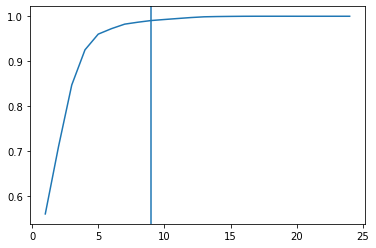

saving...
Estimating Gaussian KLD...
KLD:  0.23560509636521765
train_stats:  (array([-0.01278038,  0.00706242,  0.0054605 , -0.01080801, -0.00118137,
        0.000595  , -0.00018716, -0.00022278, -0.00027499], dtype=float32), array([[ 3.47817301e-01, -1.16153885e-03,  9.90136092e-04,
        -7.23770397e-04, -2.29487108e-03,  8.34384320e-05,
        -9.96598542e-05,  8.07312027e-04,  3.33033846e-04],
       [-1.16153885e-03,  9.00707390e-02,  6.86389624e-04,
        -5.25319114e-04, -2.45805283e-04,  7.56192863e-05,
        -1.54242375e-04, -2.82252422e-04, -7.47442154e-05],
       [ 9.90136092e-04,  6.86389624e-04,  8.54615194e-02,
         5.53087051e-04,  6.89905758e-05,  2.20667013e-04,
        -3.56025837e-04,  2.23577974e-04, -5.25941547e-05],
       [-7.23770397e-04, -5.25319114e-04,  5.53087051e-04,
         4.86249697e-02, -1.30923909e-03, -8.78633562e-04,
        -4.08130136e-04, -7.82006012e-05, -2.26799472e-04],
       [-2.29487108e-03, -2.45805283e-04,  6.89905758e-05,
   

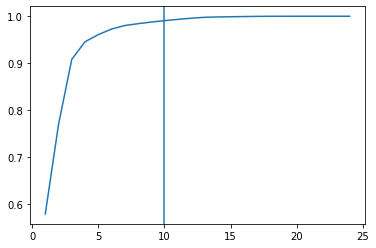

saving...
Estimating Gaussian KLD...
KLD:  0.924542056637649
train_stats:  (array([ 0.0439149 , -0.00521721,  0.00207929,  0.00228248, -0.00022346,
       -0.00012629, -0.00032298, -0.00141654, -0.01903098,  0.00071968],
      dtype=float32), array([[ 2.76508976e-01,  4.81049219e-03,  1.66629601e-03,
         1.99157375e-03,  2.87755006e-04,  1.43060890e-04,
         3.87037373e-04, -9.79405794e-05,  2.29341792e-03,
         3.60181891e-04],
       [ 4.81049219e-03,  9.13057398e-02, -1.22950334e-04,
         6.55349041e-04,  5.59034590e-05,  1.36385189e-04,
         1.36865438e-04, -2.40842080e-04, -2.81075785e-04,
         1.03467568e-04],
       [ 1.66629601e-03, -1.22950334e-04,  6.69021761e-02,
         2.17771596e-03,  1.41702264e-05,  7.43011677e-05,
        -2.99992609e-04, -3.86702092e-04,  9.47787988e-05,
        -3.50725924e-05],
       [ 1.99157375e-03,  6.55349041e-04,  2.17771596e-03,
         2.20698426e-02,  1.81418547e-05, -1.27615927e-04,
        -5.94389448e-04, -2.72

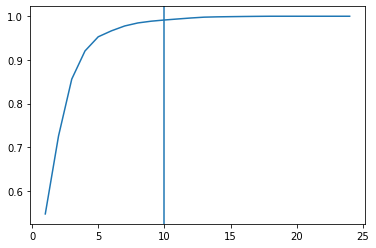

saving...
Estimating Gaussian KLD...
KLD:  1.6833260235072407
train_stats:  (array([ 0.04727563, -0.00671852,  0.00155139, -0.01899774,  0.00164449,
       -0.00029785,  0.00096832,  0.00028271, -0.00030138,  0.00051217],
      dtype=float32), array([[ 2.73824555e-01,  7.90955635e-05,  6.98630334e-04,
        -8.08482460e-03,  3.87327355e-03,  1.42366634e-04,
         1.55230822e-03,  2.11919300e-04, -4.67211613e-04,
        -8.60026883e-05],
       [ 7.90955635e-05,  9.30237215e-02,  3.48192961e-04,
         1.49477014e-03, -6.73542149e-05,  8.43245874e-05,
         1.95028566e-04,  2.46794550e-04, -4.52628627e-04,
         1.03690038e-04],
       [ 6.98630334e-04,  3.48192961e-04,  6.92980153e-02,
         2.60820100e-04,  1.47948215e-03,  1.65001985e-05,
         5.48282661e-04,  2.97763342e-05, -4.36017584e-04,
         2.30893914e-05],
       [-8.08482460e-03,  1.49477014e-03,  2.60820100e-04,
         8.65809076e-02,  3.56161632e-04,  1.21797831e-04,
         7.91107497e-05, -5.0

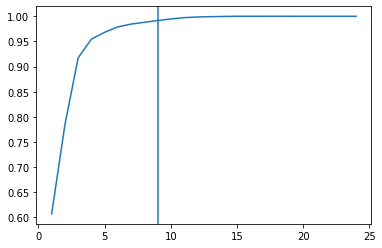

saving...
Estimating Gaussian KLD...
KLD:  6.356813369815239
train_stats:  (array([ 1.5964136e-01, -2.0901281e-02,  2.7198619e-03, -6.3192646e-04,
       -1.1409563e-03,  9.3349125e-05, -6.9642492e-04,  1.2705183e-03,
        4.9159973e-04], dtype=float32), array([[ 2.92654522e-01,  5.14166184e-03, -1.49471103e-03,
         3.09430906e-04,  4.58136933e-05,  1.45319448e-03,
        -4.36243940e-04, -8.42771718e-04,  2.93502167e-04],
       [ 5.14166184e-03,  9.52613789e-02,  1.43342560e-03,
         1.01816931e-04,  9.73232719e-05,  6.76149340e-05,
        -2.50520049e-05,  1.08198474e-04, -8.18525900e-05],
       [-1.49471103e-03,  1.43342560e-03,  7.23011130e-02,
         7.38064846e-04, -8.64661508e-05, -1.64217388e-06,
         2.75804374e-06,  9.28877136e-05, -1.38683704e-04],
       [ 3.09430906e-04,  1.01816931e-04,  7.38064846e-04,
         2.11451968e-02,  1.05605909e-04,  3.60982073e-04,
        -1.32066460e-04,  5.58585932e-05, -3.51944704e-06],
       [ 4.58136933e-05,  9.73

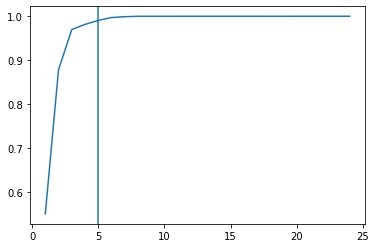

saving...
Estimating Gaussian KLD...
KLD:  0.7107815182401227
train_stats:  (array([ 5.2787378e-02,  2.1071615e-02,  4.4806761e-04, -8.1171838e-06,
        1.3402993e-04], dtype=float32), array([[ 5.80989953e-02,  4.82766883e-04, -5.30962774e-05,
         1.89080753e-04, -1.50131280e-04],
       [ 4.82766883e-04,  5.79307477e-02, -4.49067707e-04,
         1.68735063e-04,  3.42931918e-04],
       [-5.30962774e-05, -4.49067707e-04,  1.55672858e-02,
        -1.33940890e-04,  1.65133463e-04],
       [ 1.89080753e-04,  1.68735063e-04, -1.33940890e-04,
         9.61635698e-04, -1.77394504e-04],
       [-1.50131280e-04,  3.42931918e-04,  1.65133463e-04,
        -1.77394504e-04,  1.46068226e-03]]))
test_stats:  (array([-2.3453778e-02, -9.3623921e-03, -1.9909753e-04,  3.5198543e-06,
       -5.9508238e-05], dtype=float32), array([[ 4.66204895e-02, -9.28384138e-04,  8.40608929e-06,
        -8.37033328e-05,  6.21588077e-05],
       [-9.28384138e-04,  1.82436707e-02,  1.93350191e-04,
        -7.485

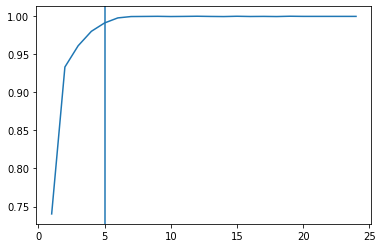

saving...
Estimating Gaussian KLD...
KLD:  1.101149429517367
train_stats:  (array([ 0.02535623,  0.00064658, -0.00039801, -0.00022851,  0.00017029],
      dtype=float32), array([[ 6.22816363e-02, -7.90303198e-04, -1.27806939e-05,
         2.13351764e-04, -3.98393365e-05],
       [-7.90303198e-04,  1.51107471e-02, -3.42978241e-04,
         1.38599011e-04, -3.09319301e-05],
       [-1.27806939e-05, -3.42978241e-04,  9.39740875e-04,
        -1.64114428e-05, -1.90296213e-04],
       [ 2.13351764e-04,  1.38599011e-04, -1.64114428e-05,
         1.64385307e-03, -1.32681968e-04],
       [-3.98393365e-05, -3.09319301e-05, -1.90296213e-04,
        -1.32681968e-04,  8.58886869e-04]]))
test_stats:  (array([-1.0172383e-02, -2.5920308e-04,  1.5948086e-04,  9.1331254e-05,
       -6.7615947e-05], dtype=float32), array([[ 1.72888180e-02,  3.07772590e-04,  1.02386313e-05,
        -8.23454313e-05,  1.33274947e-05],
       [ 3.07772590e-04,  5.05785993e-03,  1.37717368e-04,
        -5.55178584e-05,  1.234

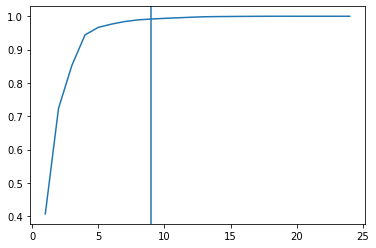

saving...
Estimating Gaussian KLD...
KLD:  0.2613911708814163
train_stats:  (array([ 4.7157034e-02,  1.0261568e-02, -5.9243557e-03,  1.9547553e-03,
        3.0475692e-03, -4.7792350e-05, -7.8558573e-04,  7.5509772e-05,
       -5.9820979e-04], dtype=float32), array([[ 2.90630742e-01,  1.27228814e-02,  4.70461268e-03,
         2.35730758e-03,  4.90653729e-03,  4.38496213e-05,
        -1.49518967e-03,  1.70493779e-04, -1.12075932e-03],
       [ 1.27228814e-02,  1.95266363e-01,  2.05103677e-03,
         3.39751044e-03,  2.41375812e-03,  7.71192708e-04,
        -1.32767678e-04,  2.36440635e-04, -3.91355019e-04],
       [ 4.70461268e-03,  2.05103677e-03,  9.32007921e-02,
        -7.32858826e-04,  7.36195280e-04,  1.18326156e-04,
        -1.05744224e-04,  2.32813863e-04, -2.03148522e-05],
       [ 2.35730758e-03,  3.39751044e-03, -7.32858826e-04,
         6.78976837e-02,  1.64386986e-03,  1.05928231e-04,
        -9.94683980e-04,  1.50284744e-04, -5.40987076e-04],
       [ 4.90653729e-03,  2.4

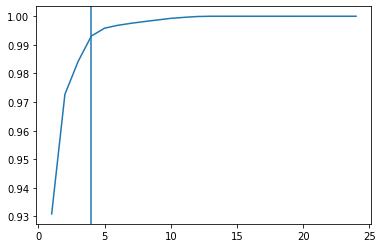

saving...
Estimating Gaussian KLD...
KLD:  9970886087052.408
train_stats:  (array([-7.8005448e-02, -1.0129429e-02,  1.2828454e-03, -2.5914762e-05],
      dtype=float32), array([[ 3.69129580e-01, -1.43495887e-03,  1.11320807e-04,
         4.32094590e-05],
       [-1.43495887e-03,  5.22986296e-05,  2.08254931e-05,
         1.13781564e-04],
       [ 1.11320807e-04,  2.08254931e-05,  9.70629182e-06,
         5.18612471e-05],
       [ 4.32094590e-05,  1.13781564e-04,  5.18612471e-05,
         2.77924557e-04]]))
test_stats:  (array([ 3.1679649e-02,  4.1143480e-03, -5.2107975e-04,  1.0524031e-05],
      dtype=float32), array([[ 3.16590419e-01,  1.31386726e-04,  1.19542945e-05,
        -1.87023090e-05],
       [ 1.31386726e-04,  2.10217908e-02, -1.03521373e-06,
        -4.63548602e-05],
       [ 1.19542945e-05, -1.03521373e-06,  5.81006167e-03,
        -2.10456032e-05],
       [-1.87023090e-05, -4.63548602e-05, -2.10456032e-05,
         4.37342080e-03]]))
done
T-10
T-12
T-13
T-2
KLD for T-2
fi

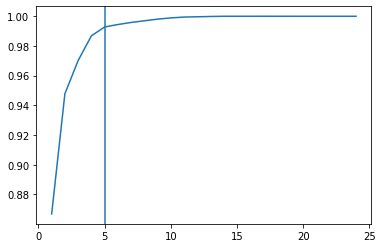

saving...
Estimating Gaussian KLD...
KLD:  1.0536031825357832
train_stats:  (array([-0.08161397,  0.02311841, -0.00373576, -0.00043951, -0.0010758 ],
      dtype=float32), array([[ 3.70166257e-01,  3.23575672e-03, -7.47973132e-04,
        -5.11217022e-04, -1.55408827e-04],
       [ 3.23575672e-03,  6.41132162e-02, -2.86018894e-04,
        -9.56458889e-04, -1.09161450e-03],
       [-7.47973132e-04, -2.86018894e-04,  1.76367458e-02,
        -1.56189944e-04, -1.92184232e-04],
       [-5.11217022e-04, -9.56458889e-04, -1.56189944e-04,
         1.29655718e-02, -4.47000872e-04],
       [-1.55408827e-04, -1.09161450e-03, -1.92184232e-04,
        -4.47000872e-04,  4.31888605e-03]]))
test_stats:  (array([ 0.03405767, -0.00964815,  0.00155907,  0.00018341,  0.00044897],
      dtype=float32), array([[ 3.22078757e-01, -2.33942417e-04,  1.31726060e-04,
         1.92085315e-04,  1.29041915e-05],
       [-2.33942417e-04,  1.78342068e-02,  1.70434705e-04,
         4.05096983e-04,  4.70191843e-04],
   

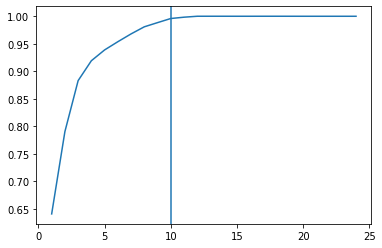

saving...
Estimating Gaussian KLD...
KLD:  2.9274060276775042
train_stats:  (array([ 1.4367059e-02,  1.2281439e-03, -1.2145536e-04,  1.6137147e-03,
        4.6758758e-04,  2.4056000e-04,  2.9363489e-04,  5.7915113e-05,
       -2.2114555e-03,  1.5043105e-03], dtype=float32), array([[ 3.50016640e-02,  1.56042177e-04, -6.56184299e-04,
         2.14777522e-04, -3.09268120e-04,  2.38134891e-04,
        -7.30824487e-06, -2.76198507e-04,  8.92213315e-07,
        -9.62980979e-05],
       [ 1.56042177e-04,  8.49628788e-03,  1.71933526e-04,
         1.68225767e-04,  7.92262673e-06, -1.59290985e-05,
        -4.29655139e-07, -2.97606774e-04, -6.80176181e-05,
        -8.65820271e-05],
       [-6.56184299e-04,  1.71933526e-04,  5.22517249e-03,
        -1.25350970e-05,  1.05245642e-04, -5.39995308e-05,
        -5.04678116e-08, -2.43059009e-05, -7.53708131e-06,
        -1.45329452e-05],
       [ 2.14777522e-04,  1.68225767e-04, -1.25350970e-05,
         2.35566360e-03,  5.82031884e-04,  1.76535881e-05

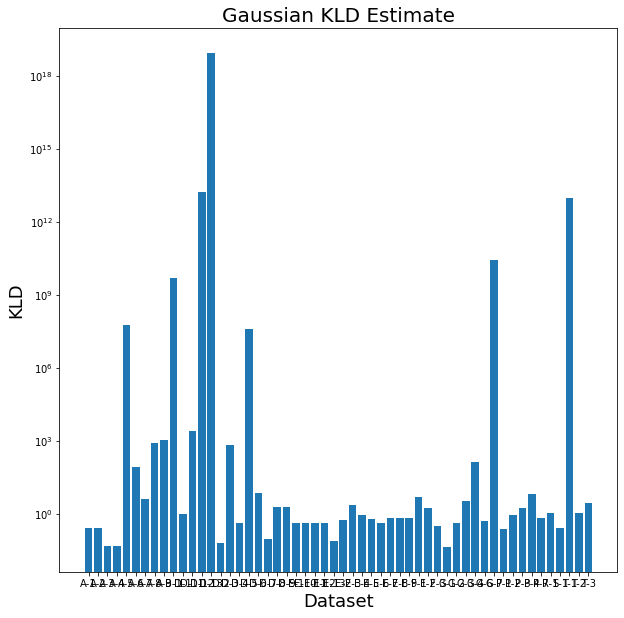

In [35]:
SMAP_list = [file[:-4] for file in os.listdir(os.path.join("data", "SMAP", "train"))]
dlist = []
kld = []
for data in SMAP_list:
    print(data)
    try:
        train_X, train_y, test_X, test_y = DataFactory.load_SMAP(data)
        e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, data, False)
        dlist.append(data)
        kld.append(e)
    except Exception as e:
        pass
    


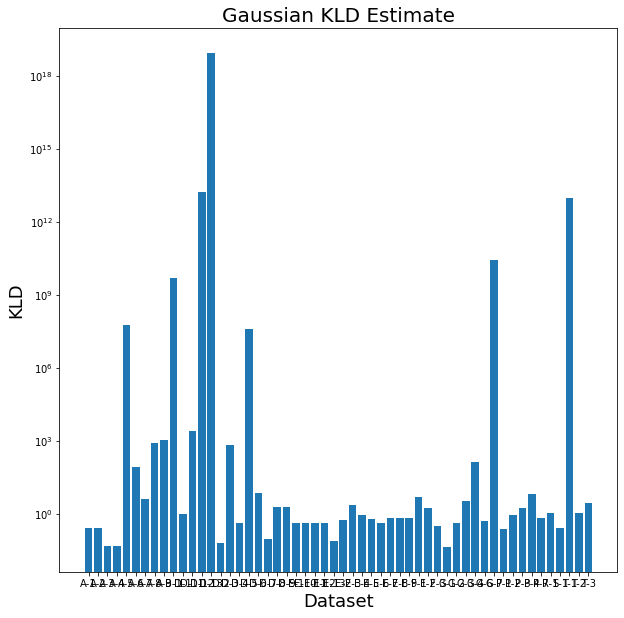

In [41]:
    
# Basic Bar Chart
plt.figure(figsize=(10, 10))
plt.bar(dlist, kld)
plt.title('Gaussian KLD Estimate', fontsize=20)
plt.xlabel('Dataset', fontsize=18)
plt.yscale('log', base=10)
plt.ylabel('KLD', fontsize=18)
plt.show()   

In [55]:
datasets_label = ["SWaT", "WADI", "PSM", "CreditCard", "MSL\n(P-15)", "SMD\n(1-4)", "Yahoo\n(Data-20)", "Pump"]
datasets = ["SWaT", "WADI", "PSM", "CreditCard", "MSL_P-15", "SMD_machine-1-4", "yahoo_20", "Pump"]

KLD for SMAP_T-3
finding PCA...
(2876, 25) (2876,) (8579, 25) (8579,)
(2876, 25) (2876,) (8397, 25) (8579,)
(11273, 25)
Done!


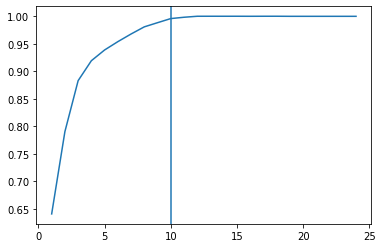

saving...
Estimating Gaussian KLD...
KLD:  2.9273628044691646
train_stats:  (array([ 1.43666845e-02,  1.22826570e-03, -1.21347017e-04,  1.61317654e-03,
        4.68180311e-04,  2.40571273e-04,  2.93686811e-04,  5.80896121e-05,
       -2.20737117e-03,  1.51037867e-03], dtype=float32), array([[ 3.50002894e-02,  1.56160887e-04, -6.56114506e-04,
         2.14435186e-04, -3.08710431e-04,  2.38137535e-04,
        -7.40710593e-06, -2.75959391e-04,  9.08966954e-07,
        -9.59235542e-05],
       [ 1.56160887e-04,  8.49635440e-03,  1.71584671e-04,
         1.68237132e-04,  7.84501599e-06, -1.59259226e-05,
        -5.30866175e-07, -2.97657651e-04, -6.82566614e-05,
        -8.64343962e-05],
       [-6.56114506e-04,  1.71584671e-04,  5.22485676e-03,
        -1.24473106e-05,  1.05113743e-04, -5.39996132e-05,
        -6.79951541e-08, -2.43900343e-05, -7.64034247e-06,
        -1.46085097e-05],
       [ 2.14435186e-04,  1.68237132e-04, -1.24473106e-05,
         2.35537567e-03,  5.82018718e-04,  1.76

In [39]:
# MSL_P-15
train_X, train_y, test_X, test_y = DataFactory.load_SMAP("T-3")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, "SMAP_T-3", False)
print(e)

KLD for MSL_P-15
finding PCA...
(3682, 55) (3682,) (2856, 55) (2856,)
(3682, 55) (3682,) (2836, 55) (2856,)
(6518, 55)
Done!


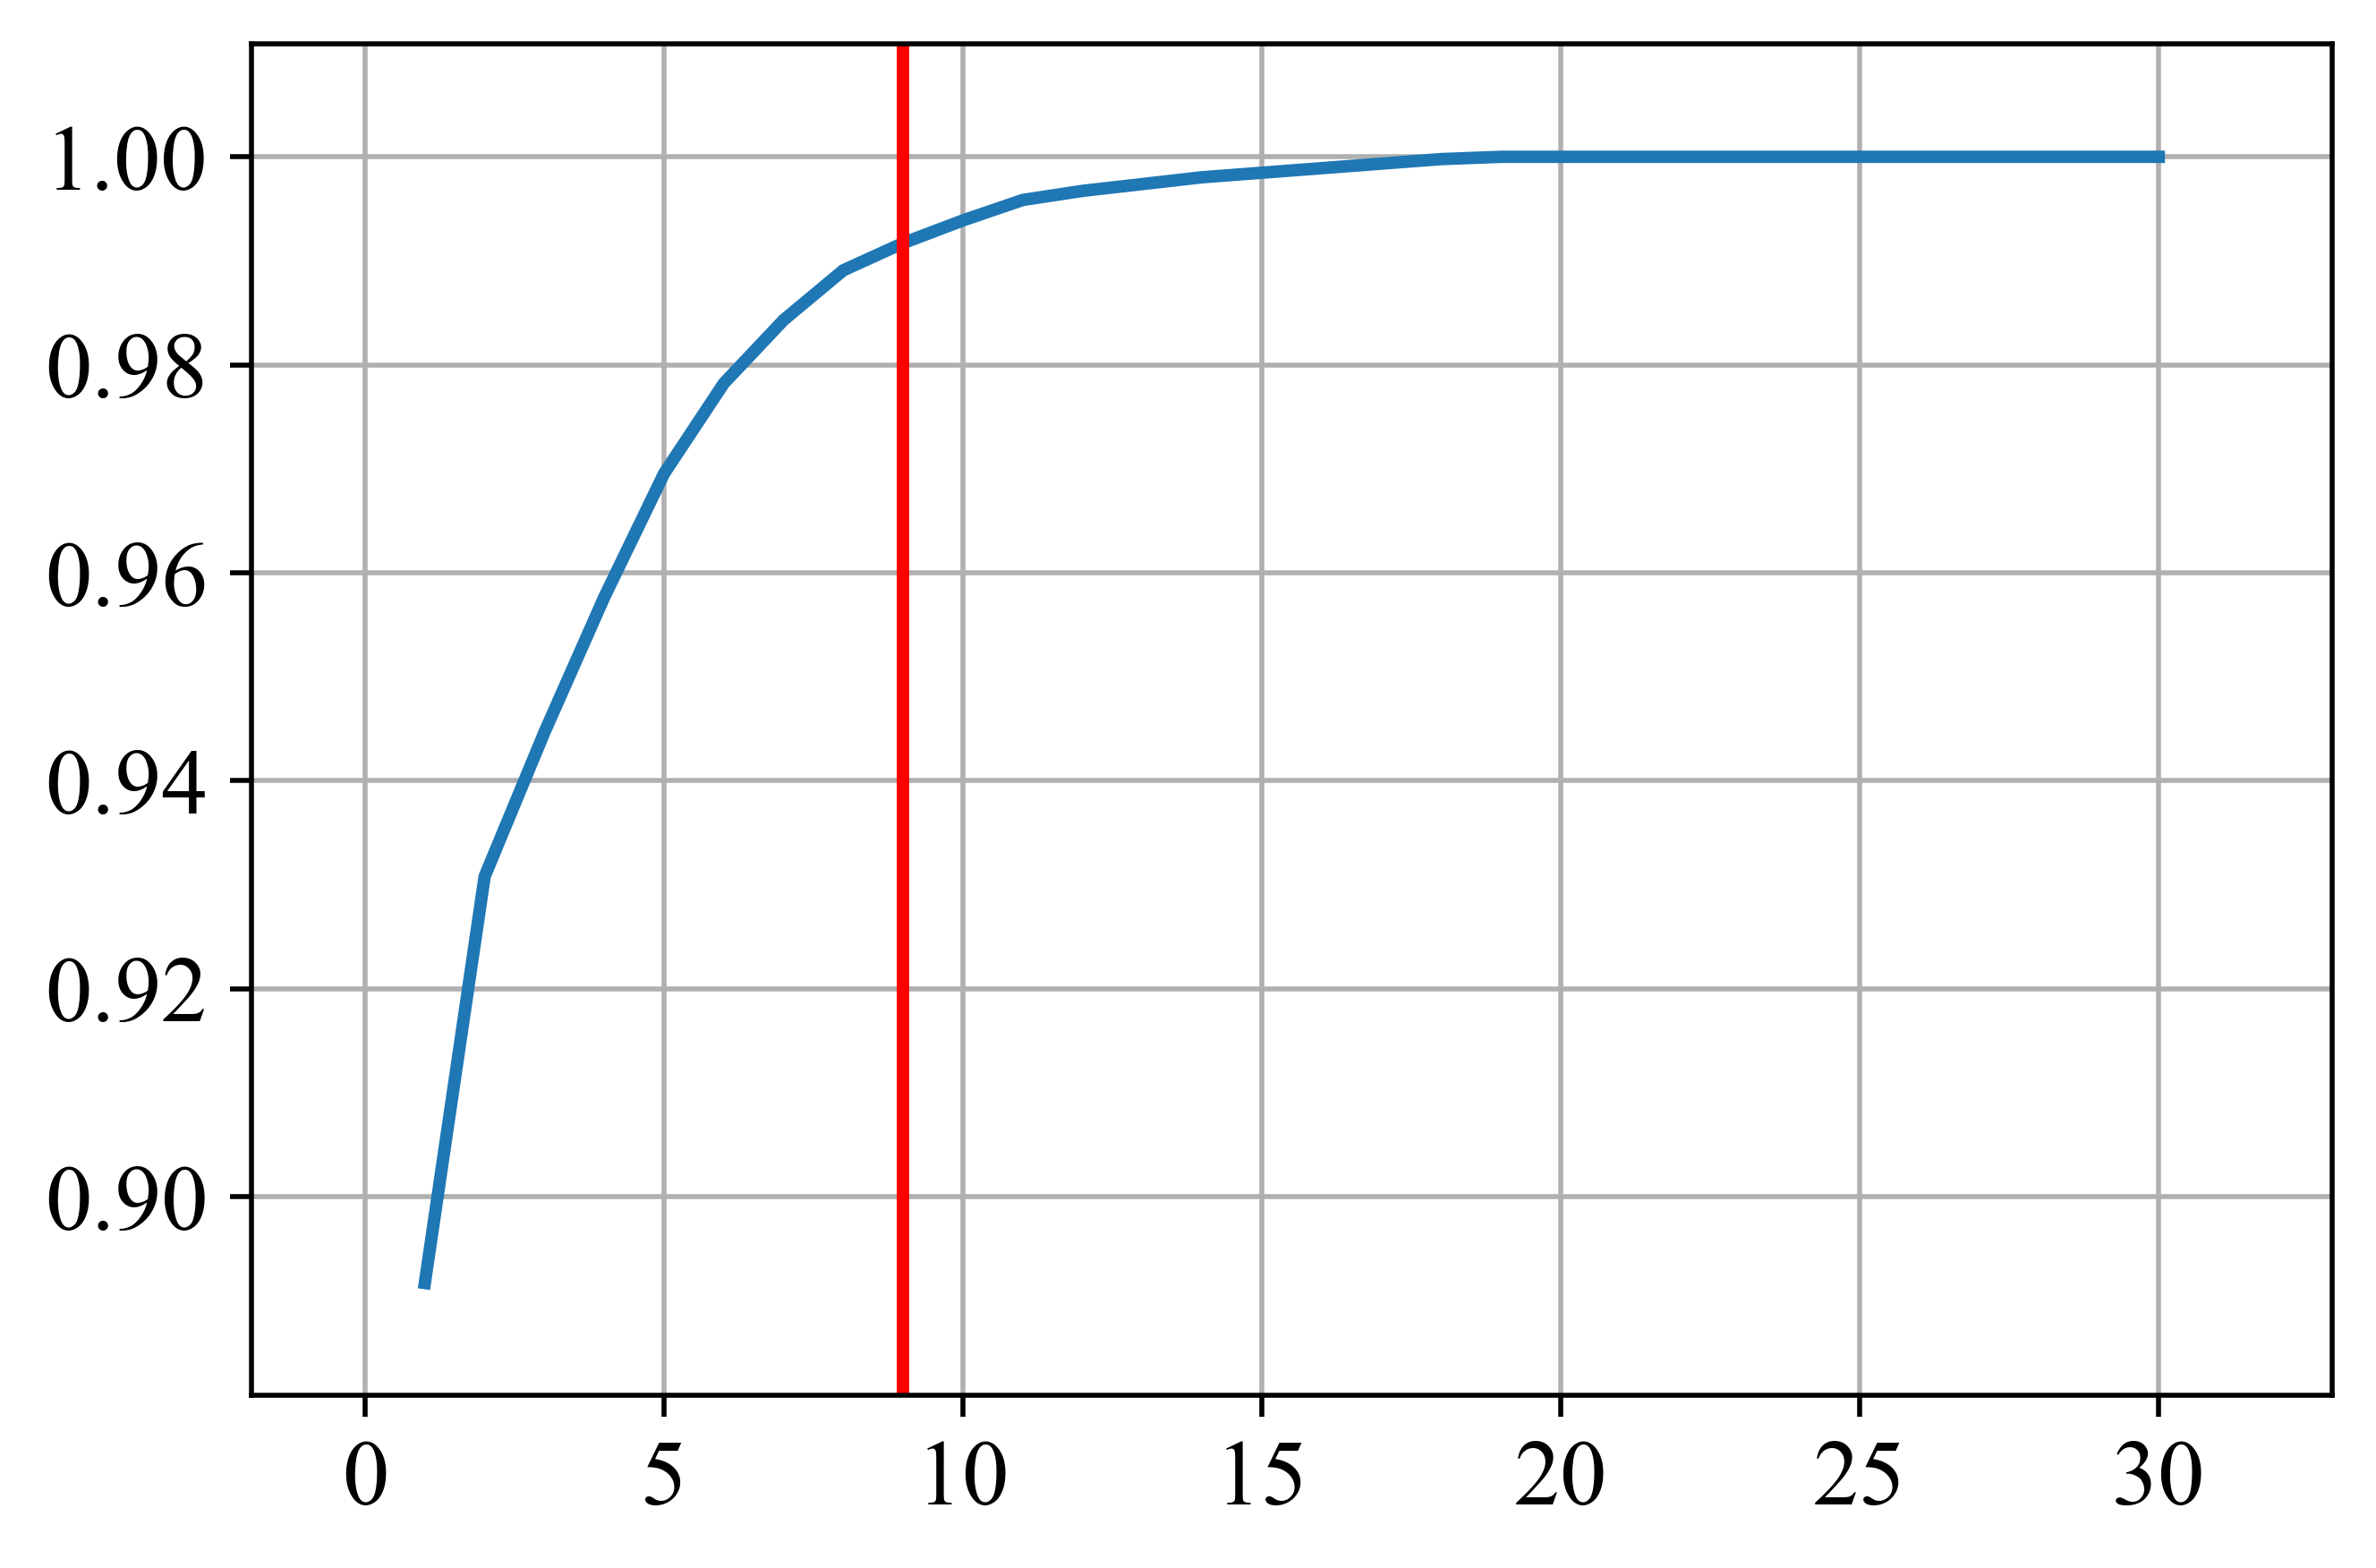

saving...
Estimating Gaussian KLD...
KLD:  743.257307142401
train_stats:  (array([-4.3744165e-01,  7.4433000e-04,  2.5386352e-04, -4.2300168e-04,
        1.2056667e-03, -1.1084882e-03, -7.5301010e-04, -1.7610076e-04,
        8.4817543e-04], dtype=float32), array([[ 1.30069127e-03, -4.31164565e-04, -8.92586545e-05,
        -3.51031234e-04, -3.03782771e-04, -2.18353075e-05,
         1.09421577e-05, -1.17634325e-04,  1.05897046e-06],
       [-4.31164565e-04,  2.82373113e-02, -6.94166885e-06,
         1.52896629e-05, -2.93804729e-05,  3.60588945e-05,
         1.74677533e-05,  4.71707156e-06, -4.32521504e-05],
       [-8.92586545e-05, -6.94166885e-06,  9.95836409e-03,
         6.89273275e-05, -3.21317585e-05,  2.36620394e-05,
         8.27725729e-06,  2.17596169e-06, -1.45170798e-05],
       [-3.51031234e-04,  1.52896629e-05,  6.89273275e-05,
         8.90331162e-03, -1.23183079e-04,  2.33256989e-05,
         7.72779365e-06,  1.33941963e-06, -1.68340432e-05],
       [-3.03782771e-04, -2.938

In [58]:
# MSL_P-15
train_X, train_y, test_X, test_y = DataFactory.load_MSL("P-15")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[4], False)

KLD for SWaT
Estimating Gaussian KLD...
KLD:  143.91222208812337
train_stats:  (array([ -1.6705731,   5.2914505,   7.6528034,  24.086998 , -17.860296 ,
         3.4094663], dtype=float32), array([[14969.14370043,  -983.66328347,   281.46421761,   -32.0104241 ,
           51.99849803,    67.15677732],
       [ -983.66328347, 18588.12709894,  -690.95972503,   518.08851302,
          426.54607852,   563.25074743],
       [  281.46421761,  -690.95972503,  2834.33070887,  1006.80290905,
          637.85931237,   110.76374396],
       [  -32.0104241 ,   518.08851302,  1006.80290905,  3749.17332058,
         1331.5161391 ,  -206.2802673 ],
       [   51.99849803,   426.54607852,   637.85931237,  1331.5161391 ,
          560.95310297,    80.69730099],
       [   67.15677732,   563.25074743,   110.76374396,  -206.2802673 ,
           80.69730099,   520.23971867]]))
test_stats:  (array([  2.7904286,  -6.267043 , -10.202734 , -29.617435 ,  22.932138 ,
         0.5329458], dtype=float32), array([[

KLD for CreditCard
Estimating Gaussian KLD...
KLD:  0.0010342001914978027
train_stats:  (array([2.3955376], dtype=float32), array([[60743.574]], dtype=float32))
test_stats:  (array([-2.3459609], dtype=float32), array([[64353.152]], dtype=float32))
done
KLD for MSL_P-15
Estimating Gaussian KLD...
KLD:  743.2572453162252
train_stats:  (array([-4.3744171e-01,  7.4432162e-04,  2.5386436e-04, -4.2299682e-04,
        1.2056696e-03, -1.1084866e-03, -7.5301330e-04, -1.7610066e-04,
        8.4817637e-04], dtype=float32), array([[ 1.30069183e-03, -4.31173024e-04, -8.92581984e-05,
        -3.51030100e-04, -3.03781871e-04, -2.18355052e-05,
         1.09416823e-05, -1.17634924e-04,  1.05882338e-06],
       [-4.31173024e-04,  2.82372872e-02, -6.94085833e-06,
         1.52892741e-05, -2.93797205e-05,  3.60589522e-05,
         1.74677714e-05,  4.71707085e-06, -4.32520197e-05],
       [-8.92581984e-05, -6.94085833e-06,  9.95837196e-03,
         6.89280741e-05, -3.21341253e-05,  2.36621451e-05,
        

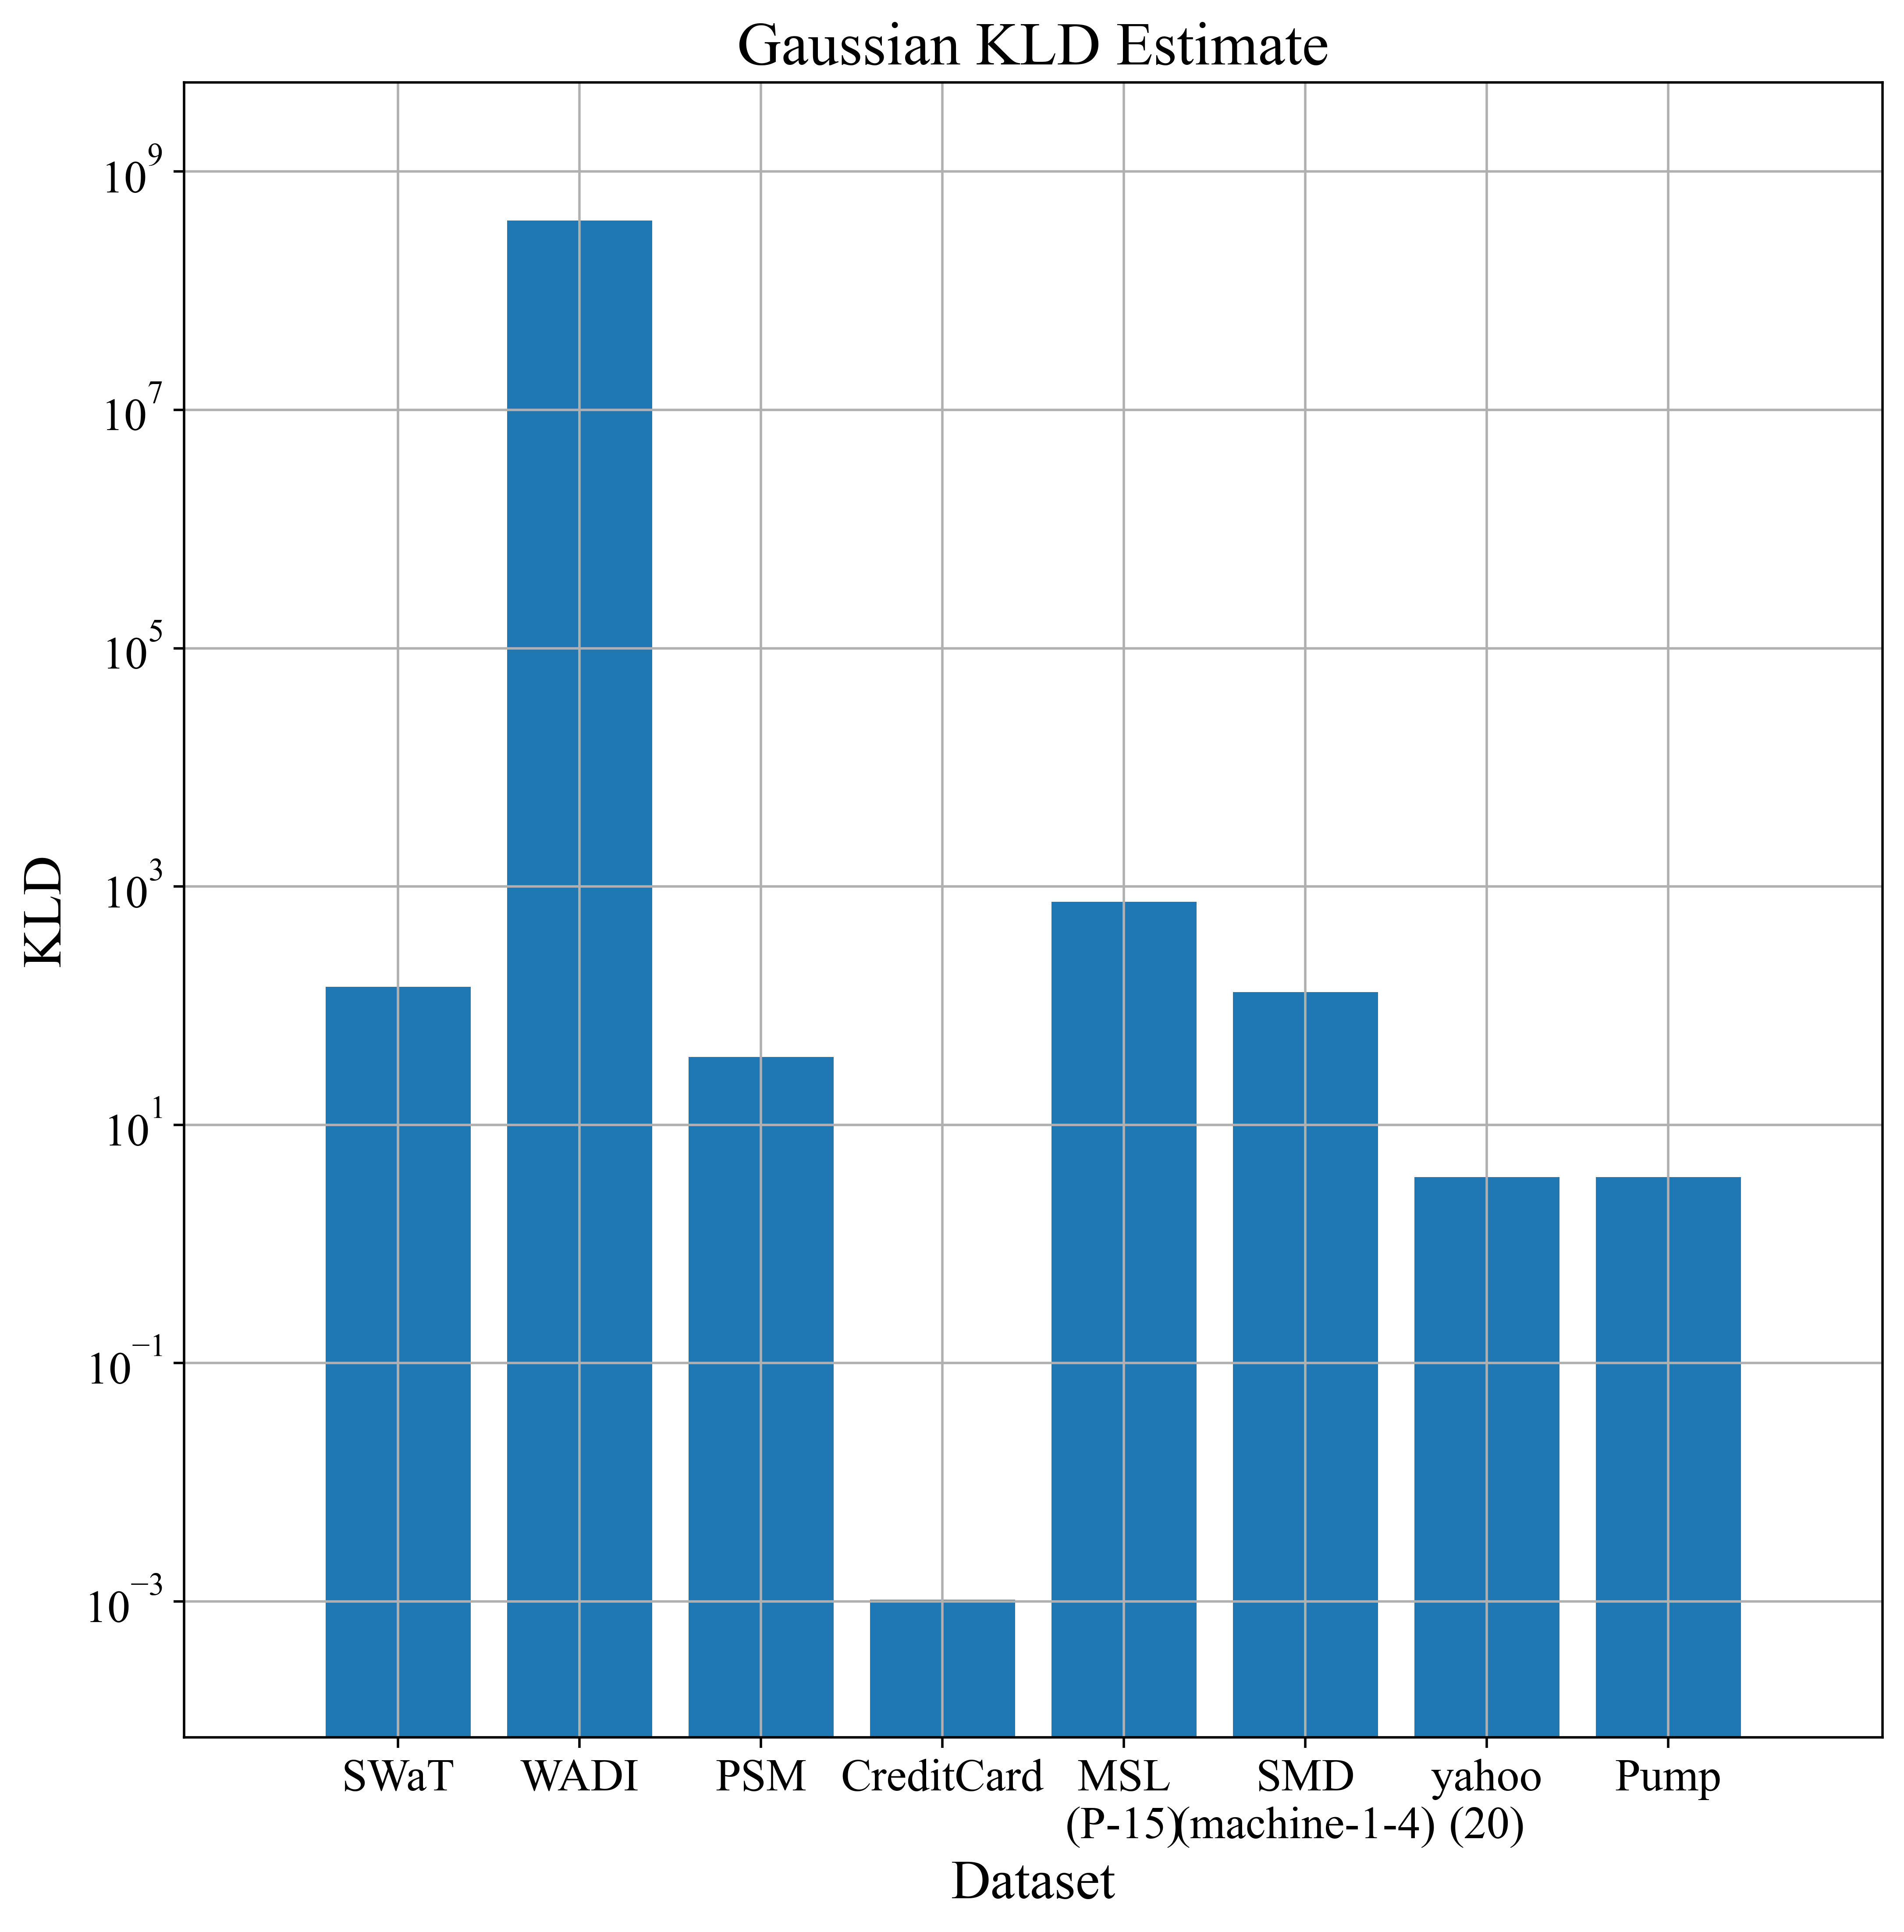

In [52]:
entropies = []

# SWaT
train_X, train_y, test_X, test_y = DataFactory.load_SWaT()
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[0])
entropies.append(e)

# WADI
train_X, train_y, test_X, test_y = DataFactory.load_WADI()
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[1])
entropies.append(e)

# PSM
train_X, train_y, test_X, test_y = DataFactory.load_PSM()
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[2])
entropies.append(e)

# CreditCard
train_X, train_y, test_X, test_y = DataFactory.load_CreditCard()
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[3])
entropies.append(e)

# MSL_P-15
train_X, train_y, test_X, test_y = DataFactory.load_MSL("P-15")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[4])
entropies.append(e)

# SMD_machine-1-4
train_X, train_y, test_X, test_y = DataFactory.load_SMD("machine-1-4")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[5])
entropies.append(e)

# yahoo_20
train_X, train_y, test_X, test_y = DataFactory.load_yahoo("20")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[6])
entropies.append(e)

# Pump
train_X, train_y, test_X, test_y = DataFactory.load_Pump()
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[7])
entropies.append(e)



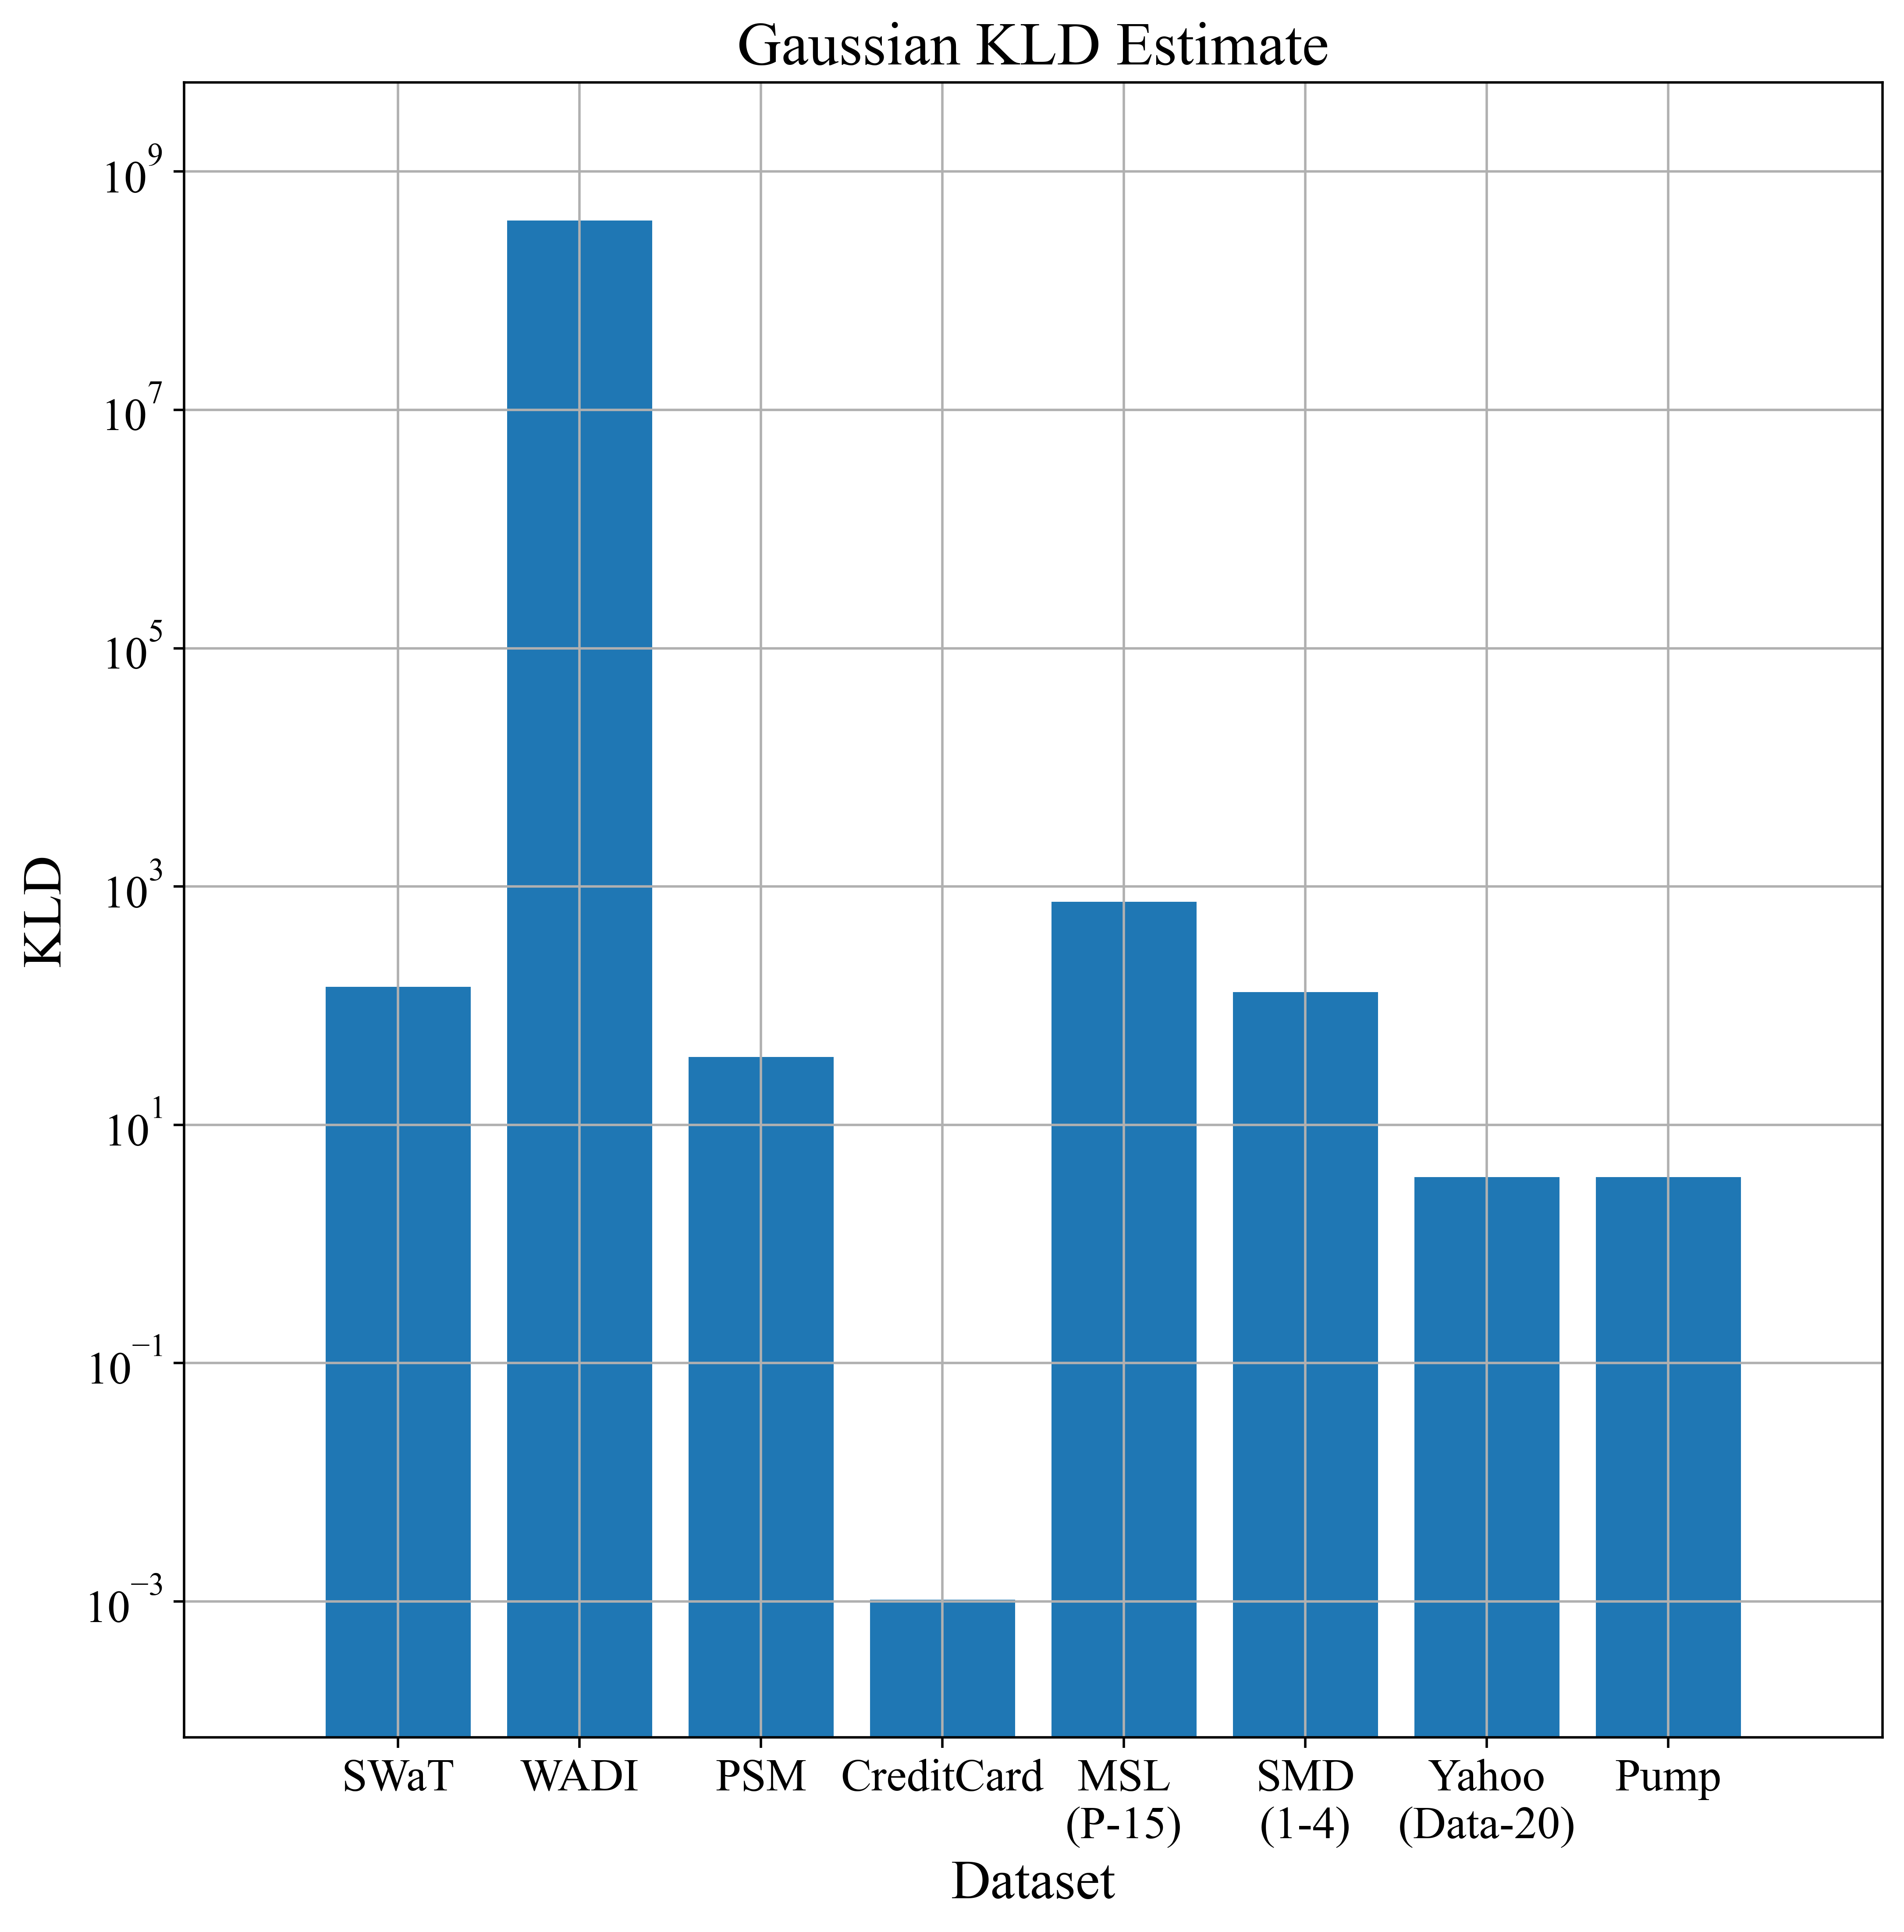

In [56]:
# Basic Bar Chart
plt.figure(figsize=(10, 10))
plt.bar(datasets_label, entropies)
plt.title('Gaussian KLD Estimate', fontsize=20)
plt.xlabel('Dataset', fontsize=18)
plt.yscale('log', base=10)
plt.ylabel('KLD', fontsize=18)
plt.show()

In [62]:
with open(os.path.join("figures", "PCA", "KLD.npy"), "wb") as f:
    np.save(f, entropies)

In [63]:
kld = np.load(os.path.join("figures", "PCA", "KLD.npy"))

In [64]:
kld

array([1.43912222e+02, 3.88179916e+08, 3.70687401e+01, 1.03420019e-03,
       7.43257245e+02, 1.30357132e+02, 3.62813282e+00, 3.62813282e+00])

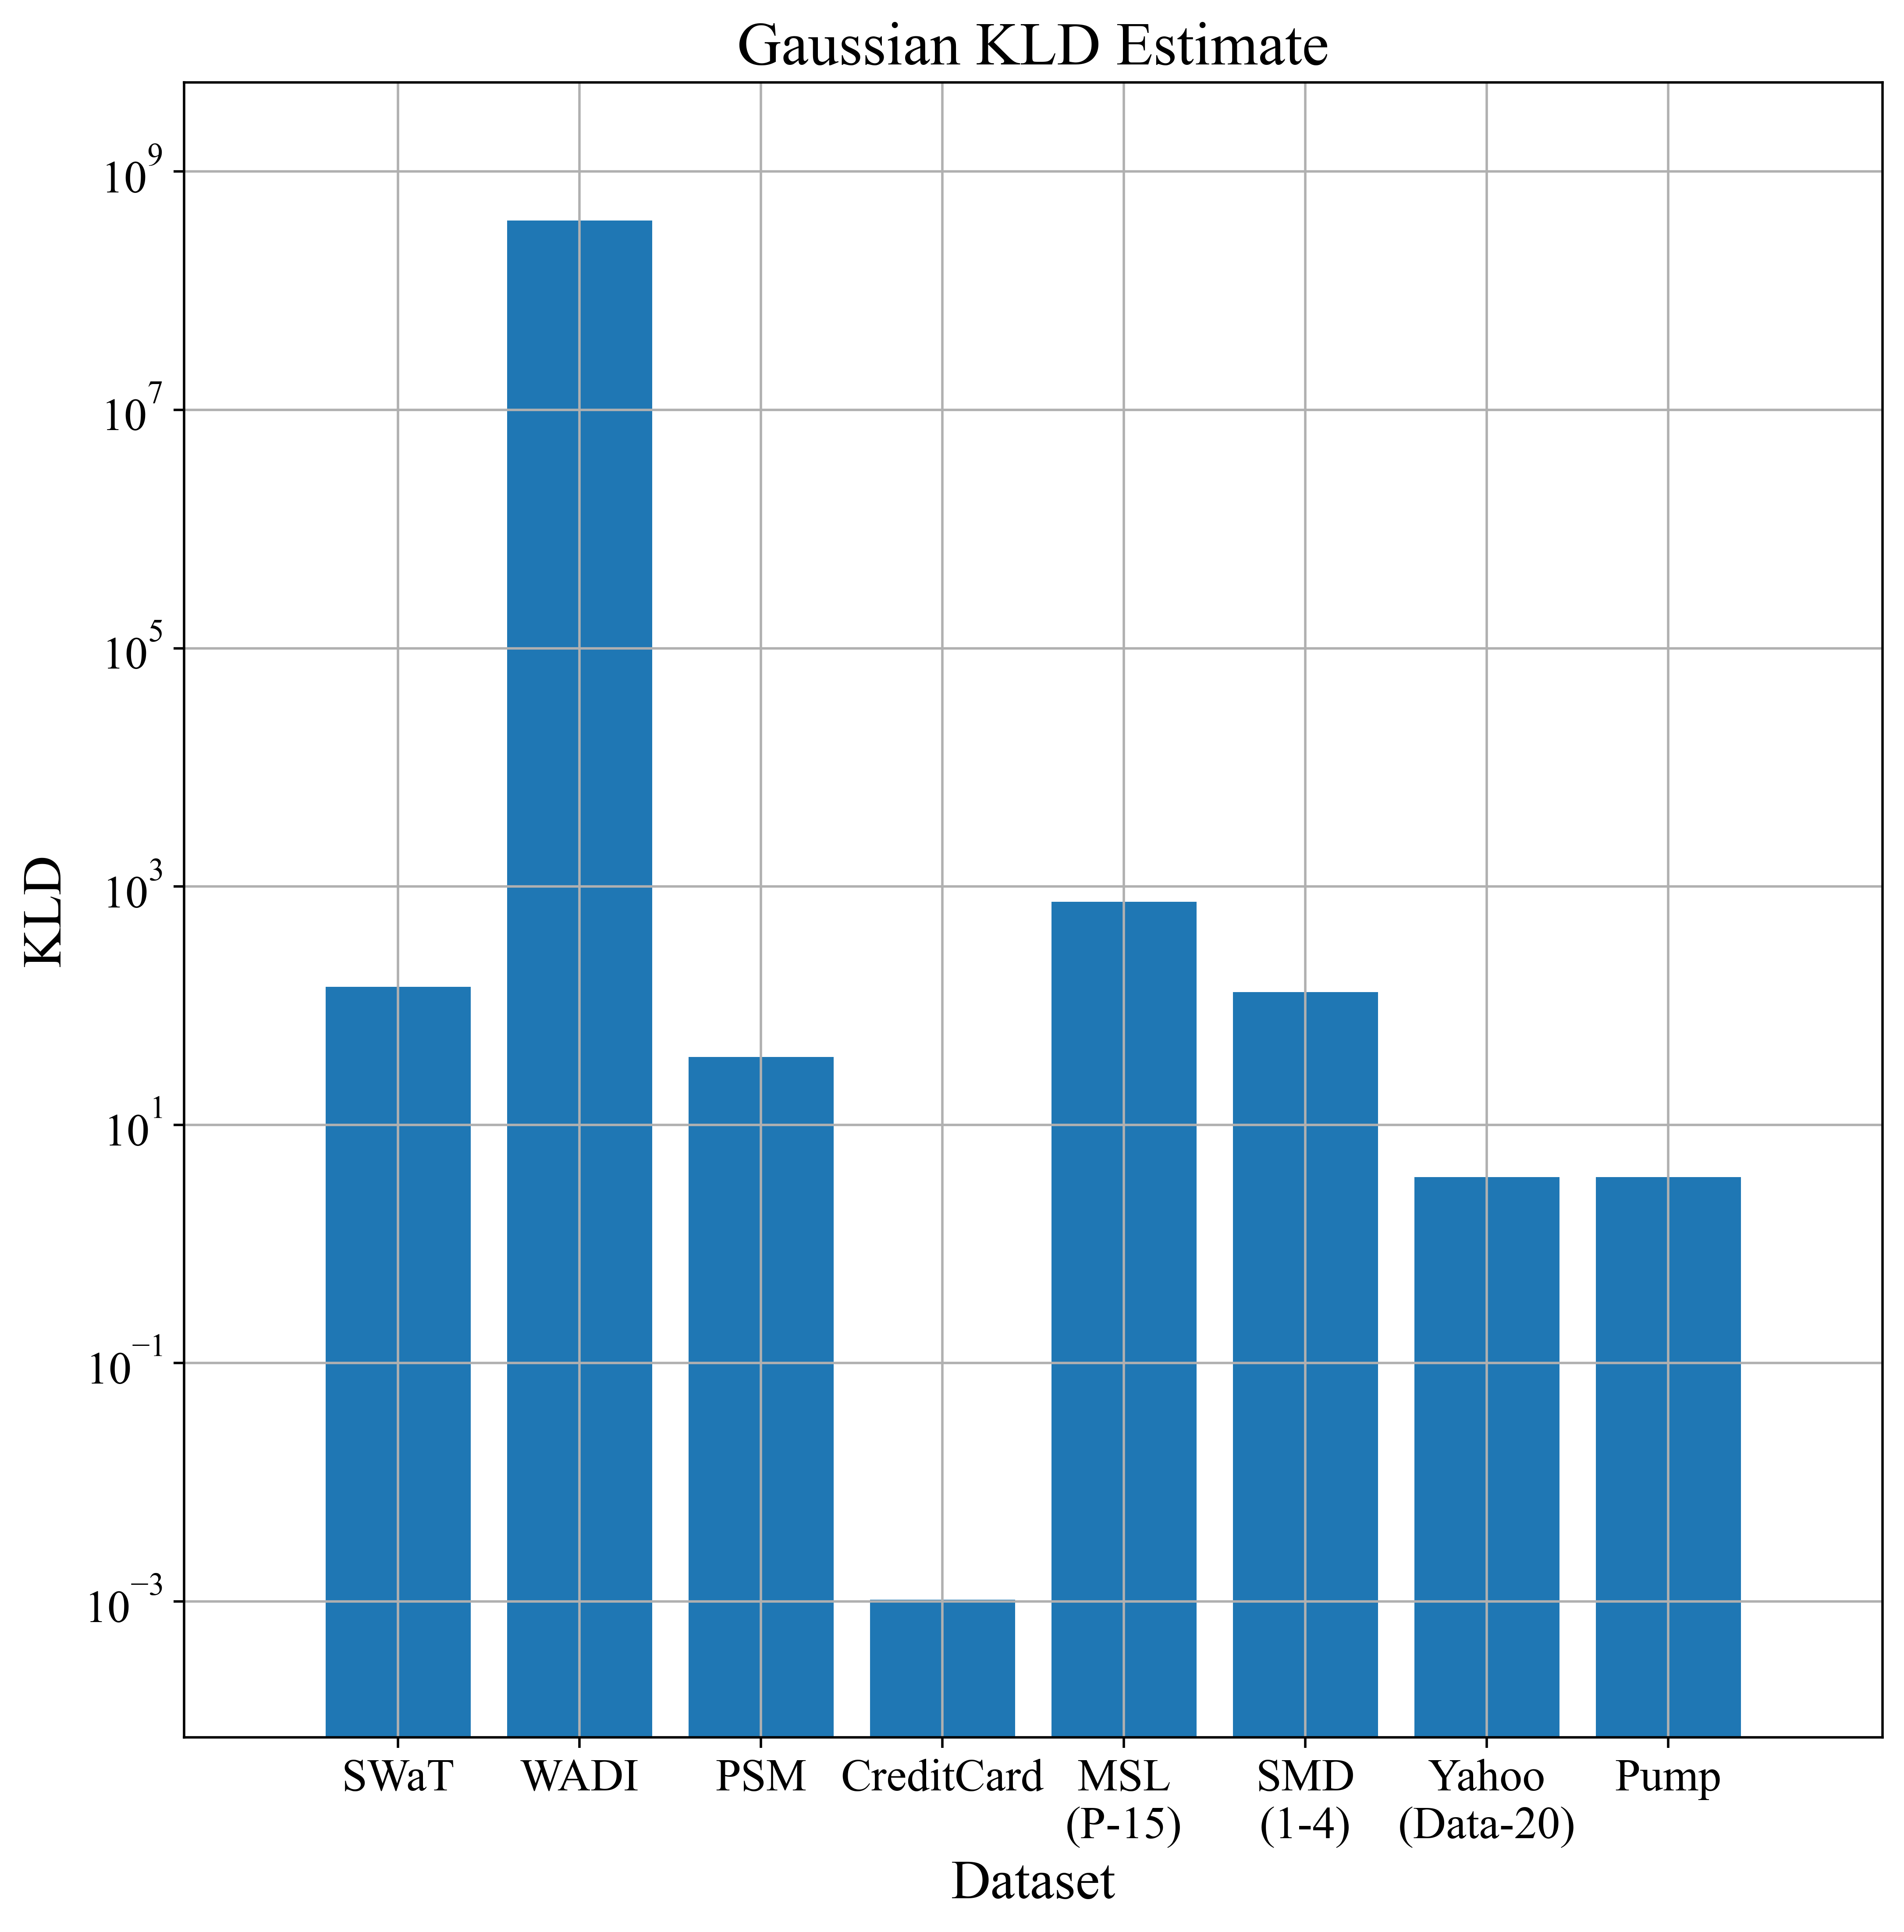

In [66]:
# Basic Bar Chart
plt.figure(figsize=(10, 10))
plt.bar(datasets_label, kld)
plt.title('Gaussian KLD Estimate', fontsize=20)
plt.xlabel('Dataset', fontsize=18)
plt.yscale('log', base=10)
plt.ylabel('KLD', fontsize=18)
plt.show()

In [80]:
off = np.array([0.7627829568, 0.1301139533, 0.5359979503, 0.1486068111, 0.358974359, 0.1, 0.06342913776, 0.1])
on = np.array([0.7903205183, 0.1422824922, 0.5375672963, 0.1009753299, 0.6153846154, 0.3, 0.6571428571428571, 0.3])

In [81]:
len(kld)

8

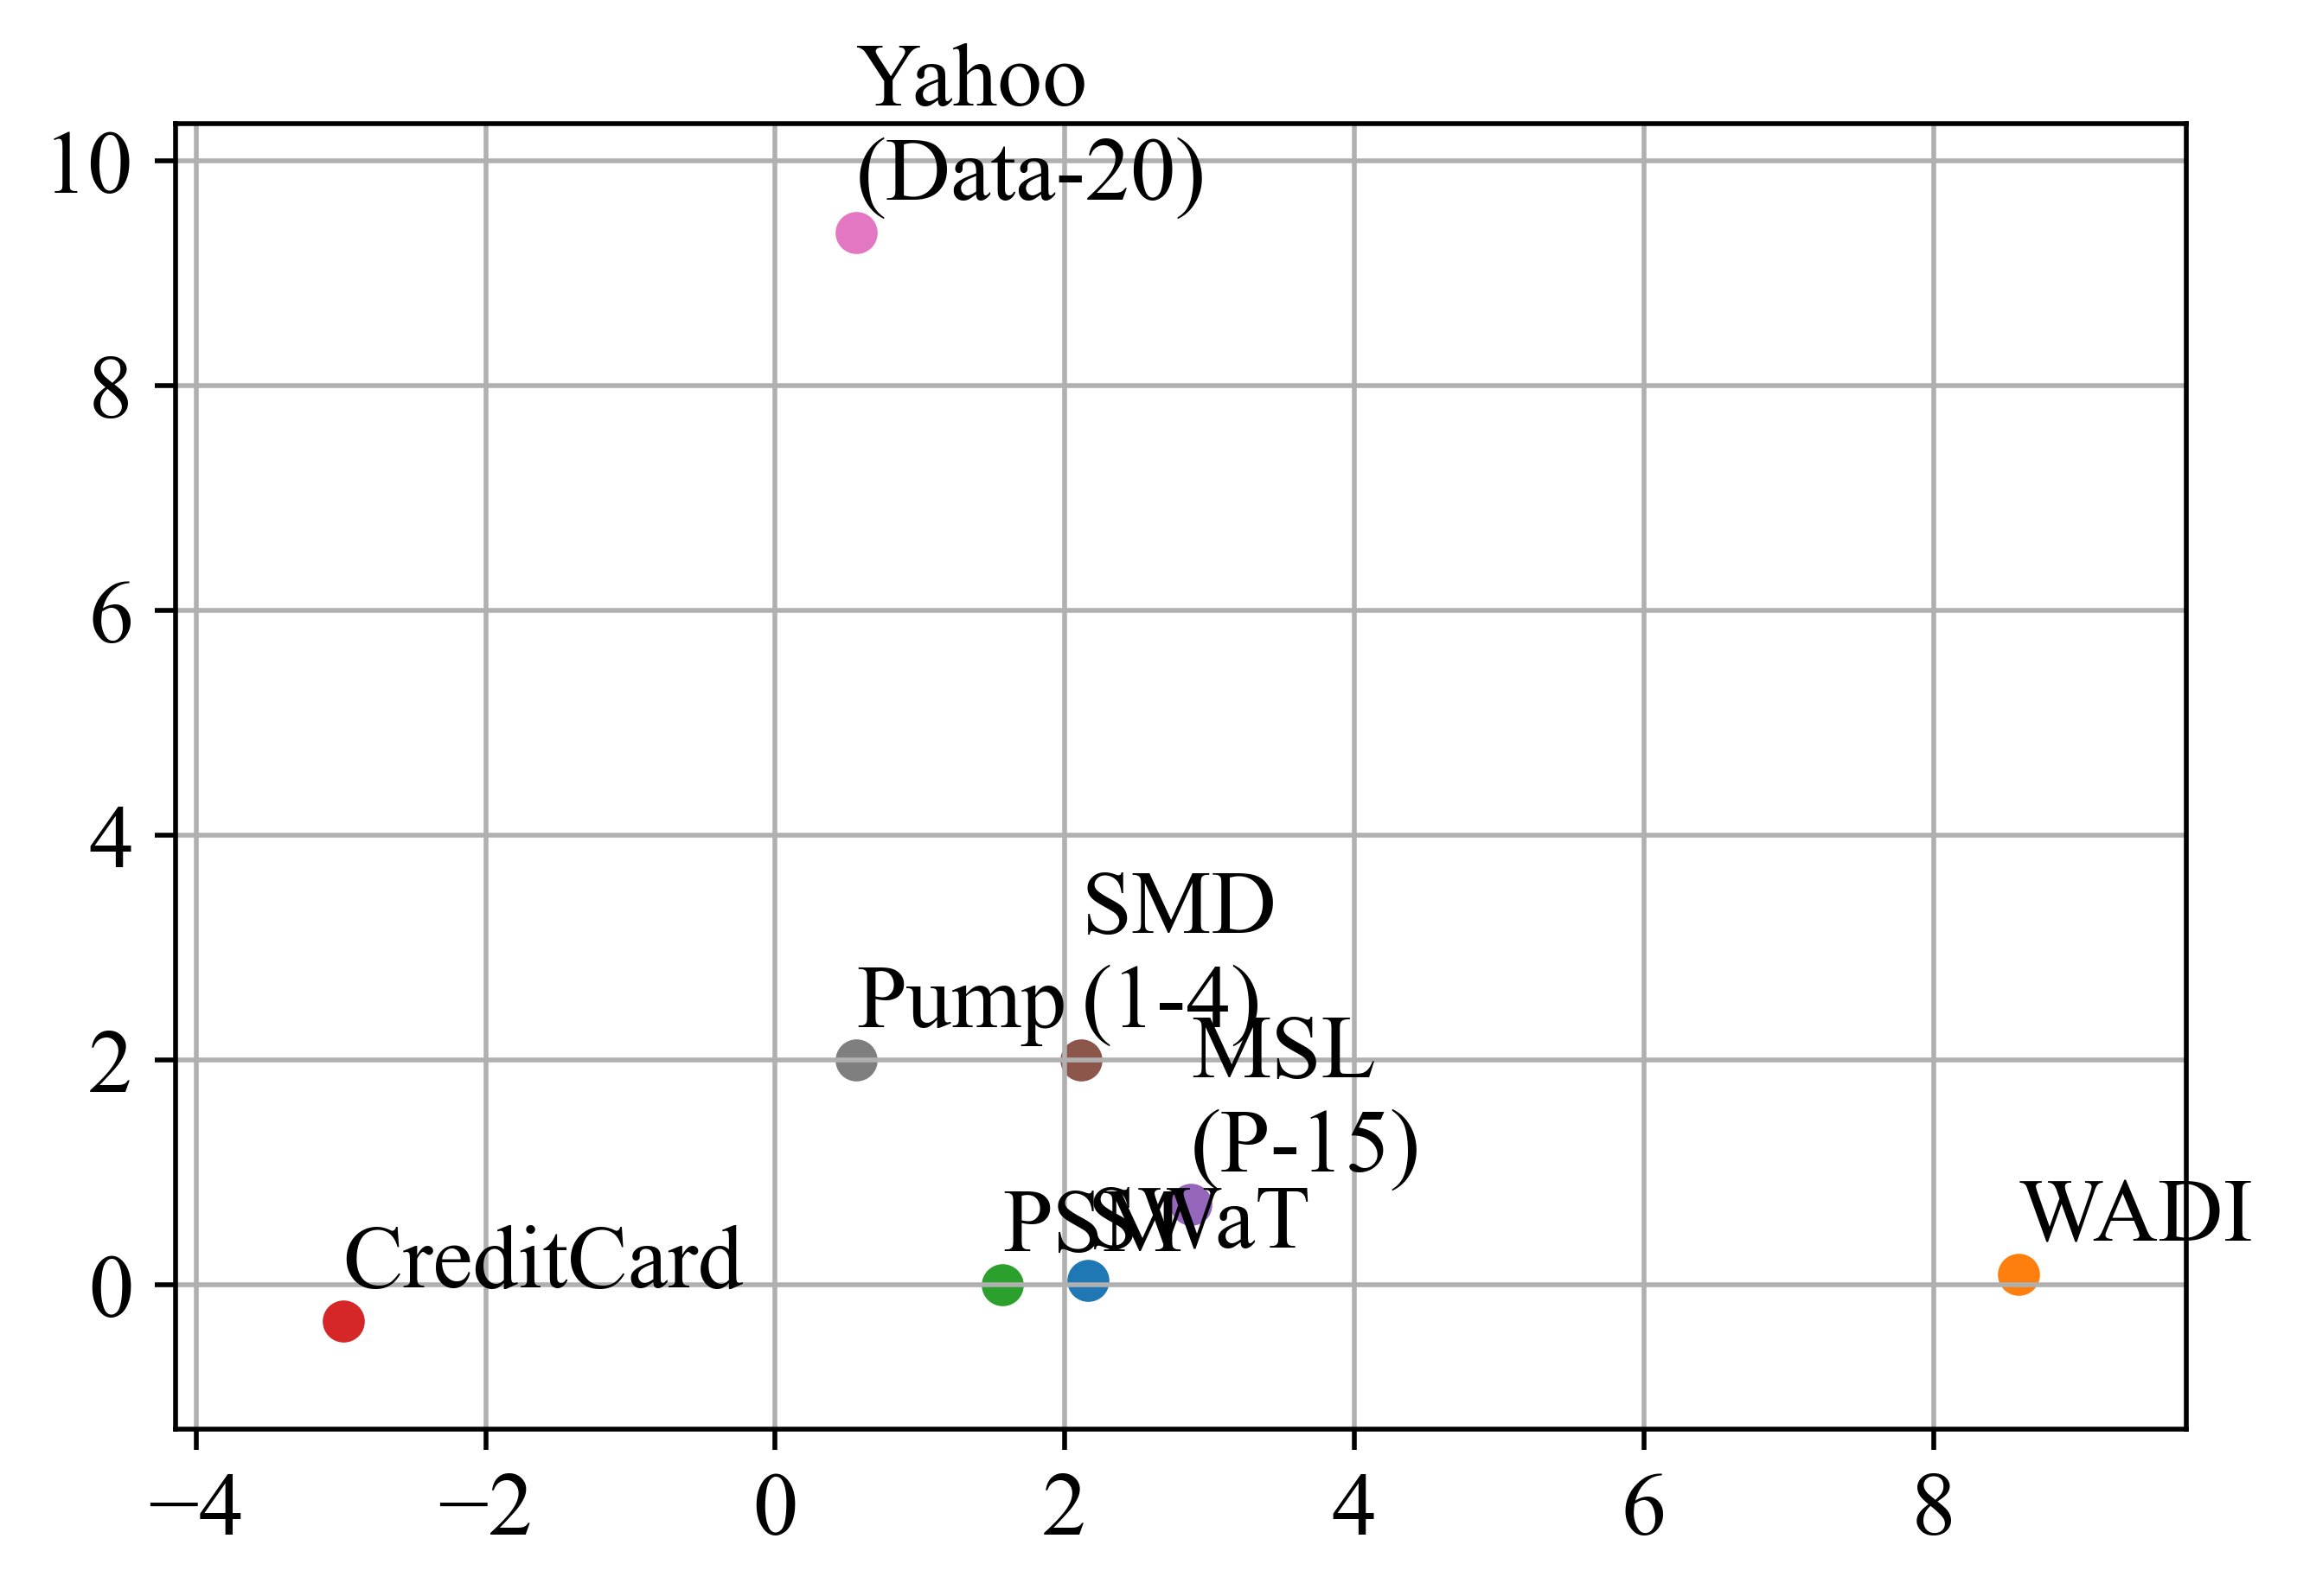

In [82]:
for x, y, data in zip(np.log10(kld), (on-off)/off, datasets_label):
    plt.scatter(x, y)
    plt.text(x, y+0.3, data)